In [61]:
import pandas as pd
import missingno as msno
import numpy as np
import re
from collections import Counter
from datetime import datetime
from geopy.geocoders import Nominatim
from transliterate import translit
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from scipy import stats

# Общая часть

## Подготовка таблицы GA_Hits

In [134]:
df_hits = pd.read_csv('data/ga_hits.csv')

In [135]:
df_hits.head()

session_id    hit_date  hit_time  \
0  5639623078712724064.1640254056.1640254056  2021-12-23  597864.0   
1  7750352294969115059.1640271109.1640271109  2021-12-23  597331.0   
2   885342191847998240.1640235807.1640235807  2021-12-23  796252.0   
3   142526202120934167.1640211014.1640211014  2021-12-23  934292.0   
4  3450086108837475701.1640265078.1640265078  2021-12-23  768741.0   

   hit_number hit_type hit_referer  \
0          30    event         NaN   
1          41    event         NaN   
2          49    event         NaN   
3          46    event         NaN   
4          79    event         NaN   

                                       hit_page_path event_category  \
0  sberauto.com/cars?utm_source_initial=google&ut...           quiz   
1  sberauto.com/cars/fiat?city=1&city=18&rental_c...           quiz   
2  sberauto.com/cars/all/volkswagen/polo/e994838f...           quiz   
3  sberauto.com/cars?utm_source_initial=yandex&ut...           quiz   
4  sberauto.com/cars/all/mercedes-benz/cla-klasse...           quiz   

  event_action event_label  event_value  
0    quiz_show         NaN          NaN  
1    quiz_show         NaN          NaN  
2    quiz_show         NaN          NaN  
3    quiz_show         NaN          NaN  
4    quiz_show         NaN          NaN

In [136]:
df_hits.shape

(15726470, 11)

In [137]:
##Проверка на дупликаты, не найдено
df_hits.duplicated().unique()

array([False])

### Извлечение информации об автомобиле из колонки hit_page_path

In [138]:
##Разделяем ссылку сплитом для поиска марки и модели автомобиля и добавляем две новых колонки
df_hits['hit_page_split'] = df_hits['hit_page_path'].str.split('/')
df_hits['car_brand'] = df_hits['hit_page_split'].str.get(3)
df_hits['car_model'] = df_hits['hit_page_split'].str.get(4)

In [139]:
##список марок машин на основе колонки car_brand
car_br = ['skoda', 'mercedes-benz', 'volkswagen', 'lada-vaz', 'kia', 'bmw','toyota','renault', 'porsche', 'lexus', 'audi',
             'volvo', 'haval', 'peugeot', 'mini', 'land-rover', 'hyundai', 'honda', 'nissan', 'infiniti', 'mitsubishi', 
             'chevrolet', 'ford', 'mazda', 'ravon', 'chery', 'jeep']


In [140]:
## split дал основной перечень автомобилей, но колонки 'car_brand' и 'car_model' содержат много некорректных значений

In [141]:
## на основе списка car_brand применяем регулярное выражение к 'hit_page_path'
def extract_car_brand(url):
    for brand in car_br:
        pattern = r'(?<![a-zA-Z])\b{}\b'.format(brand)
        if re.search(pattern, url, flags=re.IGNORECASE):
            return brand
    return None


df_hits['car_name'] = df_hits['hit_page_path'].apply(extract_car_brand)

In [142]:
dict(df_hits['car_name'].value_counts())

{'skoda': 747636,
 'mercedes-benz': 475839,
 'volkswagen': 419709,
 'lada-vaz': 407470,
 'nissan': 370193,
 'kia': 241009,
 'bmw': 199869,
 'toyota': 164725,
 'renault': 151543,
 'porsche': 63818,
 'audi': 63032,
 'lexus': 61961,
 'volvo': 51975,
 'haval': 51933,
 'mini': 34950,
 'peugeot': 27575,
 'land-rover': 25167,
 'hyundai': 21539,
 'honda': 792,
 'chevrolet': 599,
 'mitsubishi': 477,
 'ford': 447,
 'mazda': 437,
 'infiniti': 314,
 'chery': 270,
 'jeep': 141,
 'ravon': 35}

In [143]:
## уберем некоректные значения из car_model
df_hits['car_model'] = df_hits['car_model'].apply(lambda x: x if len(str(x)) < 12 else np.nan)
mod_dict = dict(df_hits['car_model'].value_counts())

In [144]:
car_mod = []
for k,v in mod_dict.items():
    if v > 50:
        car_mod.append(k)
    else:
        pass
print(car_mod)    

['rapid', 'vesta', 'polo', 'karoq', 'e-klasse', 'qashqai', 'rio', 'x-trail', 'octavia', 'duster', 'camry', 'logan', 'seltos', 'sorento', 'tiguan', 'glb', 'gla-klasse', 's90', 'jolion', '5-serii', 'g-klasse', 'cayenne', 'hatch', 'rx', '3-serii', 'x5', 'kodiaq', 'gle', 'x3', 'glc', 'c-klasse', 'nx', 'traveller', 'range-rover', 'corolla', '2-serii', 's-klasse', '911', 'fortuner', 'x6', 'solaris', 'gls-klasse', 'touareg', 'e-tron', 'a3', 'alphard', 'teramont', 'q5', 'a4', '7-serii', 'cla-klasse', 'x7', 'taos', 'soul', 'panamera', 'cerato', 'arkana', 'sale', 'x3-m', 'rav-4', 'sportage', 'passat-cc', 'macan', 'qx60', 'x1', 'eo6u', 'passat', 'defender', 'x4-m']


In [145]:
df_hits['car_model'] = df_hits['car_model'].apply(lambda x: np.nan if x not in car_mod else x)

In [146]:
dict(df_hits['car_model'].value_counts())

{'rapid': 442513,
 'vesta': 403910,
 'polo': 318075,
 'karoq': 194273,
 'e-klasse': 178467,
 'qashqai': 153153,
 'rio': 90249,
 'x-trail': 85548,
 'octavia': 77005,
 'duster': 76676,
 'camry': 73149,
 'logan': 72088,
 'seltos': 70464,
 'sorento': 69886,
 'tiguan': 62101,
 'glb': 61043,
 'gla-klasse': 55236,
 's90': 51627,
 'jolion': 51538,
 '5-serii': 40453,
 'g-klasse': 40113,
 'cayenne': 39203,
 'hatch': 34709,
 'rx': 33806,
 '3-serii': 30842,
 'x5': 30762,
 'kodiaq': 30725,
 'gle': 29760,
 'x3': 28751,
 'glc': 28516,
 'c-klasse': 27868,
 'nx': 27825,
 'traveller': 27431,
 'range-rover': 24520,
 'corolla': 23865,
 '2-serii': 22608,
 's-klasse': 21544,
 '911': 21319,
 'fortuner': 20947,
 'x6': 19864,
 'solaris': 19054,
 'gls-klasse': 18963,
 'touareg': 18785,
 'e-tron': 17566,
 'a3': 17027,
 'alphard': 16597,
 'teramont': 13564,
 'q5': 13450,
 'a4': 11986,
 '7-serii': 10929,
 'cla-klasse': 10775,
 'x7': 10238,
 'taos': 4261,
 'soul': 3107,
 'panamera': 2834,
 'cerato': 2131,
 'arkana'

### Обработка пропусков

In [147]:
df_hits.notnull().sum()

session_id        15726470
hit_date          15726470
hit_time           6566148
hit_number        15726470
hit_type          15726470
hit_referer        9451666
hit_page_path     15726470
event_category    15726470
event_action      15726470
event_label       11966286
event_value              0
hit_page_split    15726470
car_brand          3527641
car_model          3389185
car_name           3583455
dtype: int64

In [148]:
##Удаляем вспомогательные колонки и неинформативные колонки
col_to_drop = ['hit_page_path', 'hit_page_split', 'car_brand', 'hit_time', 'event_value','hit_date']

In [149]:
df_hits = df_hits.drop(columns=col_to_drop)

In [114]:
df_hits = df_hits.drop(columns ='hit_type')


In [115]:
df_hits

session_id  hit_number hit_referer  \
0         5639623078712724064.1640254056.1640254056          30       other   
1         7750352294969115059.1640271109.1640271109          41       other   
2          885342191847998240.1640235807.1640235807          49       other   
3          142526202120934167.1640211014.1640211014          46       other   
4         3450086108837475701.1640265078.1640265078          79       other   
...                                             ...         ...         ...   
15726465  6866159858916559617.1640270865.1640270865          43       other   
15726466  7310304587364460692.1640261783.1640261783          40       other   
15726467  8013702685784312179.1640270195.1640270195          43       other   
15726468  8021505554734405918.1640257821.1640257821          45       other   
15726469  1569014437485249865.1640269129.1640269129          46       other   

         event_category event_action event_label   car_model       car_name  \
0                  quiz    quiz_show       other       other          other   
1                  quiz    quiz_show       other       other          other   
2                  quiz    quiz_show       other        polo     volkswagen   
3                  quiz    quiz_show       other       other          other   
4                  quiz    quiz_show       other  cla-klasse  mercedes-benz   
...                 ...          ...         ...         ...            ...   
15726465           quiz    quiz_show       other    fortuner         toyota   
15726466           quiz    quiz_show       other  gla-klasse  mercedes-benz   
15726467           quiz    quiz_show       other     alphard         toyota   
15726468           quiz    quiz_show       other          x3            bmw   
15726469           quiz    quiz_show       other     7-serii            bmw   

          target_col  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
...              ...  
15726465           0  
15726466           0  
15726467           0  
15726468           0  
15726469           0  

[15726470 rows x 9 columns]

In [99]:
## Заменяем пропуски значением "other" в колонкax "Car_model и Car_Name"
df_hits.car_model = df_hits.car_model.fillna('other')
df_hits.car_name = df_hits.car_name.fillna('other')
df_hits.hit_referer = df_hits.hit_referer.fillna('other')
df_hits.event_label = df_hits.event_label.fillna('other')

In [116]:
df_hits.notnull().sum()

session_id        15726470
hit_number        15726470
hit_referer       15726470
event_category    15726470
event_action      15726470
event_label       15726470
car_model         15726470
car_name          15726470
target_col        15726470
dtype: int64

### Создание дополнительных колонок

In [101]:
##cписок целевых событий
target = ['sub_car_claim_click', 'sub_car_claim_submit_click', 'sub_open_dialog_click', 'sub_custom_question_submit_click', 
'sub_call_number_click', 'sub_callback_submit_click', 'sub_submit_success', 'sub_car_request_submit_click']

In [102]:
## создание колонки с признаком целевого события
df_hits['target_col'] = df_hits['event_action'].apply(lambda x: 1 if x in target else 0)

In [103]:
df_hits['target_col'].value_counts()

target_col
0    15621562
1      104908
Name: count, dtype: int64

In [117]:
df_hits.head(10)

session_id  hit_number  \
0  5639623078712724064.1640254056.1640254056          30   
1  7750352294969115059.1640271109.1640271109          41   
2   885342191847998240.1640235807.1640235807          49   
3   142526202120934167.1640211014.1640211014          46   
4  3450086108837475701.1640265078.1640265078          79   
5  6466333295973247896.1640246168.1640246168          41   
6   281215510786615563.1640245516.1640245516         102   
7  4024492994895054107.1640269084.1640269084          85   
8   555009234841130092.1640256620.1640256620         101   
9  2692901778487480807.1640206845.1640206845           1   

            hit_referer event_category event_action event_label   car_model  \
0                 other           quiz    quiz_show       other       other   
1                 other           quiz    quiz_show       other       other   
2                 other           quiz    quiz_show       other        polo   
3                 other           quiz    quiz_show       other       other   
4                 other           quiz    quiz_show       other  cla-klasse   
5                 other           quiz    quiz_show       other       other   
6                 other           quiz    quiz_show       other       other   
7                 other           quiz    quiz_show       other         glc   
8  VloVXNWduHeTjUoDkjkO           quiz    quiz_show       other     sorento   
9                 other       card_web    view_card       other     x-trail   

        car_name  target_col  
0          other           0  
1          other           0  
2     volkswagen           0  
3          other           0  
4  mercedes-benz           0  
5          other           0  
6         toyota           0  
7  mercedes-benz           0  
8            kia           0  
9         nissan           0

In [119]:
df_hits.to_csv ('data/ga_hits_clean.csv', index=False)

In [31]:
##df_group = df_hits.sort_values(by=['session_id', 'target_col'], ascending=[True, False])


In [120]:
df_group = df_hits.groupby('session_id', as_index=False).agg({'hit_number': 'first', 'hit_referer': 'first', 'event_category': 'first', 
      'event_action': 'first', 'event_label': 'first', 'car_model': 'first', 'car_name': 'first', 'target_col': 'max'})

In [121]:
df_group

session_id  hit_number  \
0        1000009318903347362.1632663668.1632663668          15   
1        1000010177899156286.1635013443.1635013443           2   
2        1000013386240115915.1635402956.1635402956           7   
3        1000017303238376207.1623489300.1623489300           3   
4        1000020580299877109.1624943350.1624943350           3   
...                                            ...         ...   
1734605   999960188766601545.1626816843.1626816843           3   
1734606    99996598443387715.1626811203.1626811203           4   
1734607   999966717128502952.1638428330.1638428330          16   
1734608   999988617151873171.1623556243.1623556243           2   
1734609   999989480451054428.1634311006.1634311006           3   

                  hit_referer    event_category         event_action  \
0        HbolMJUevblAbkHClEQa     sub_page_view              sub_faq   
1                       other     sub_page_view          sub_landing   
2                       other          card_web            view_card   
3        HbolMJUevblAbkHClEQa     sub_page_view          sub_landing   
4        HbolMJUevblAbkHClEQa              quiz            quiz_show   
...                       ...               ...                  ...   
1734605  HbolMJUevblAbkHClEQa     sub_page_view          sub_landing   
1734606  HbolMJUevblAbkHClEQa  sub_button_click  sub_view_cars_click   
1734607                 other       search_form    showed_number_ads   
1734608  HbolMJUevblAbkHClEQa     sub_page_view          sub_landing   
1734609  HbolMJUevblAbkHClEQa     sub_page_view          sub_landing   

                  event_label car_model  car_name  target_col  
0        KclpemfoHstknWHFiLit     other     other           0  
1                       other     other     other           0  
2                       other     vesta  lada-vaz           0  
3        KclpemfoHstknWHFiLit     other     other           0  
4        KclpemfoHstknWHFiLit     other     other           0  
...                       ...       ...       ...         ...  
1734605  KclpemfoHstknWHFiLit     other     other           0  
1734606  OHfyUfDKdPgBdvelDlfG     other     other           0  
1734607  hAHqGICPFQiPwtzubOzs     other     other           0  
1734608  KclpemfoHstknWHFiLit     other     other           0  
1734609  KclpemfoHstknWHFiLit     other     other           0  

[1734610 rows x 9 columns]

In [122]:
df_group.target_col.value_counts()

target_col
0    1683850
1      50760
Name: count, dtype: int64

## Подготовка таблицы Ga_sessions

In [123]:
df_ses = pd.read_csv('data/ga_sessions.csv')
df_ses.head()

C:\Users\Tomato\AppData\Local\Temp\ipykernel_12580\1013073476.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ses = pd.read_csv('data/ga_sessions.csv')


session_id          client_id  visit_date  \
0  9055434745589932991.1637753792.1637753792  2108382700.163776  2021-11-24   
1   905544597018549464.1636867290.1636867290   210838531.163687  2021-11-14   
2  9055446045651783499.1640648526.1640648526  2108385331.164065  2021-12-28   
3  9055447046360770272.1622255328.1622255328  2108385564.162225  2021-05-29   
4  9055447046360770272.1622255345.1622255345  2108385564.162225  2021-05-29   

  visit_time  visit_number            utm_source utm_medium  \
0   14:36:32             1  ZpYIoDJMcFzVoPFsHGJL     banner   
1   08:21:30             1  MvfHsxITijuriZxsqZqt        cpm   
2   02:42:06             1  ZpYIoDJMcFzVoPFsHGJL     banner   
3   05:00:00             1  kjsLglQLzykiRbcDiGcD        cpc   
4   05:00:00             2  kjsLglQLzykiRbcDiGcD        cpc   

           utm_campaign         utm_adcontent           utm_keyword  \
0  LEoPHuyFvzoNfnzGgfcd  vCIpmpaGBnIQhyYNkXqp  puhZPIYqKXeFPaUviSjo   
1  FTjNLDyTrXaWYgZymFkV  xhoenQgDQsgfEPYNPwKO  IGUCNvHlhfHpROGclCit   
2  LEoPHuyFvzoNfnzGgfcd  vCIpmpaGBnIQhyYNkXqp  puhZPIYqKXeFPaUviSjo   
3                   NaN  NOBKLgtuvqYWkXQHeYWM                   NaN   
4                   NaN                   NaN                   NaN   

  device_category device_os device_brand device_model  \
0          mobile   Android       Huawei          NaN   
1          mobile   Android      Samsung          NaN   
2          mobile   Android       Huawei          NaN   
3          mobile       NaN       Xiaomi          NaN   
4          mobile       NaN       Xiaomi          NaN   

  device_screen_resolution    device_browser geo_country     geo_city  
0                  360x720            Chrome      Russia     Zlatoust  
1                  385x854  Samsung Internet      Russia       Moscow  
2                  360x720            Chrome      Russia  Krasnoyarsk  
3                  393x786            Chrome      Russia       Moscow  
4                  393x786            Chrome      Russia       Moscow

In [125]:
##удалим неинформативные и пустые колонки
drop_col = ['utm_campaign', 'utm_adcontent', 'utm_keyword', 'device_model' ]

In [126]:
df_ses = df_ses.drop(columns=drop_col)

<Axes: >

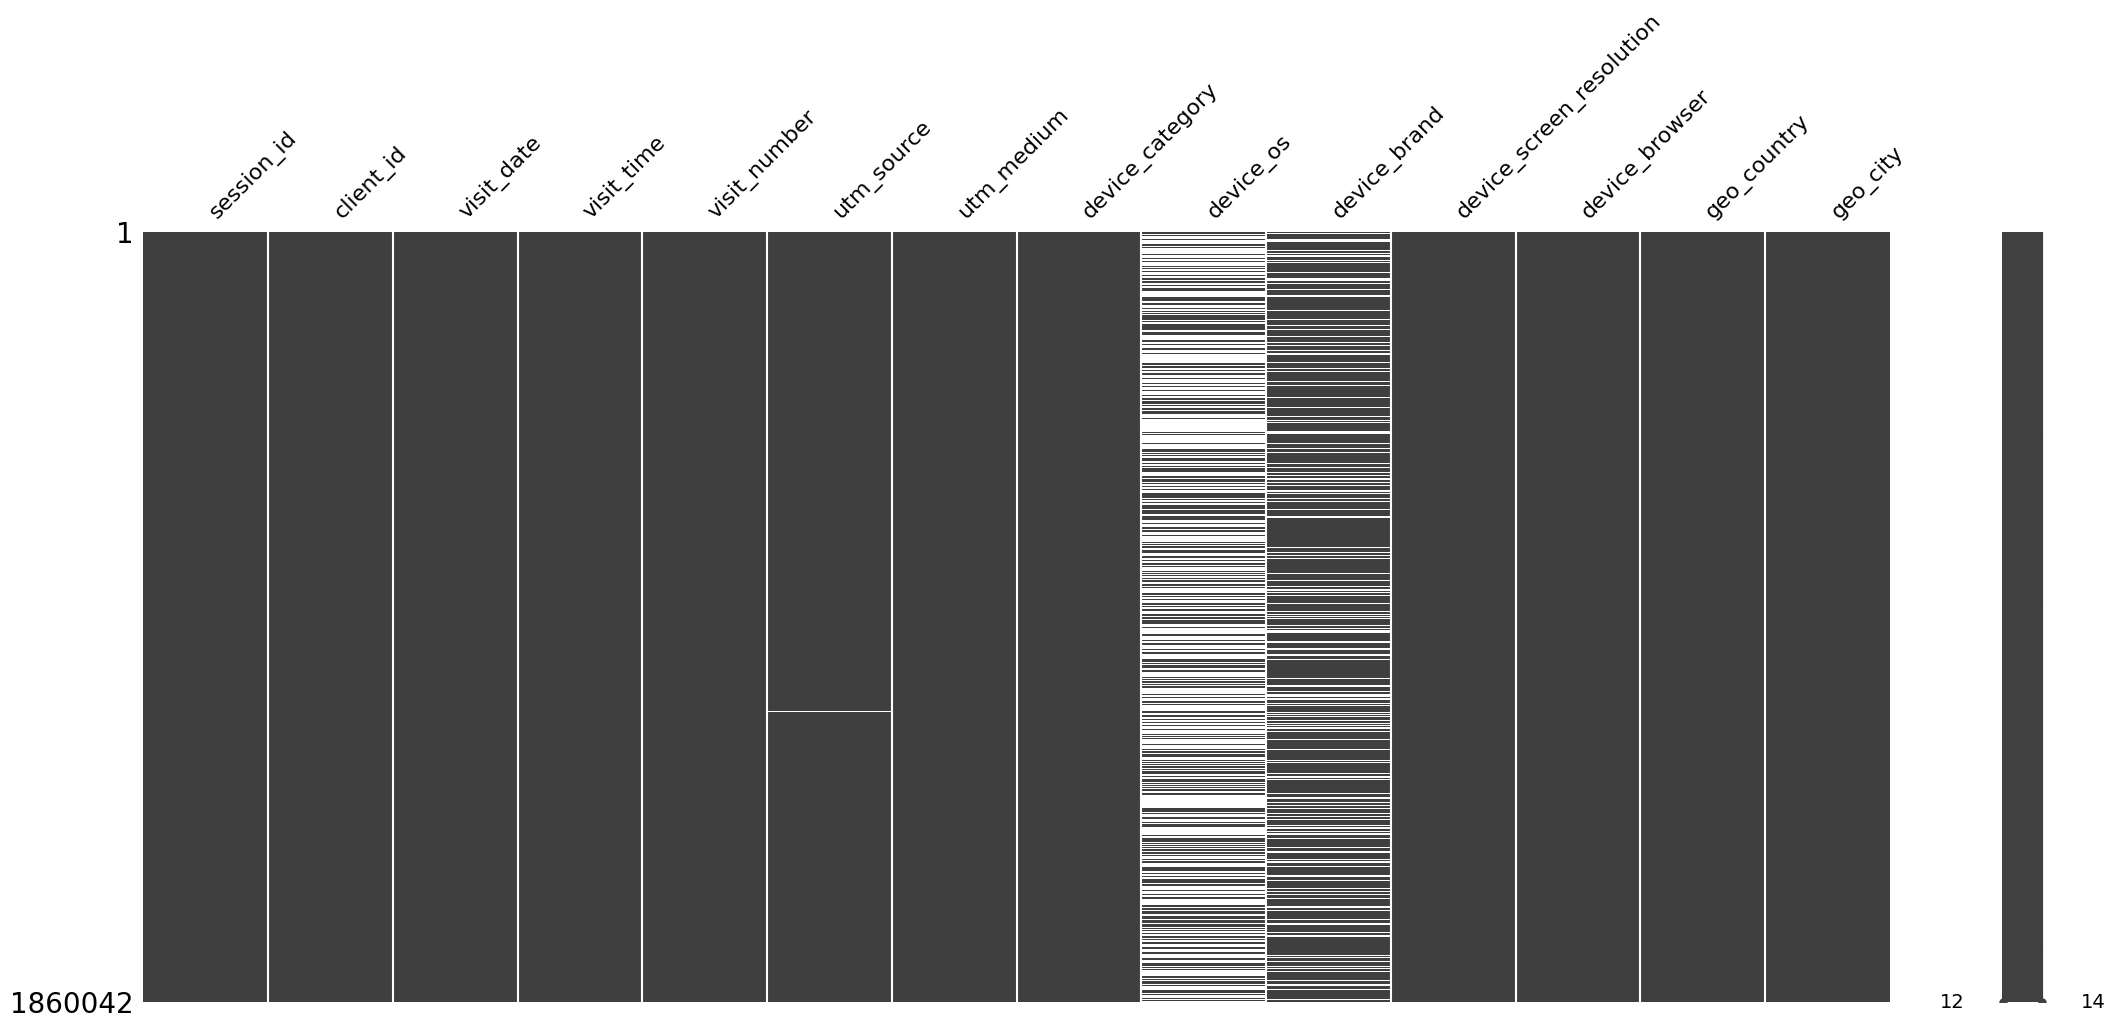

In [127]:
msno.matrix(df_ses)

### Обработка device_os и device_brand

In [128]:
dict(df_ses.device_brand.value_counts())

{'Apple': 551088,
 'Samsung': 332194,
 'Xiaomi': 288367,
 'Huawei': 185853,
 'Realme': 19058,
 '(not set)': 17545,
 'OPPO': 13504,
 'Vivo': 11740,
 'OnePlus': 9965,
 'Asus': 7929,
 'Nokia': 7285,
 'Sony': 6459,
 'ZTE': 6365,
 'Google': 5150,
 'Meizu': 3750,
 'Lenovo': 3148,
 'Blackview': 2759,
 'Tecno': 2654,
 'LG': 2447,
 'Motorola': 2357,
 'BQ': 1573,
 'itel': 1082,
 'Alcatel': 968,
 'DOOGEE': 876,
 'Oukitel': 826,
 'HTC': 790,
 'Umidigi': 661,
 'Ulefone': 511,
 'Infinix': 417,
 'Vsmart': 368,
 'LeEco': 344,
 'BlackBerry': 338,
 'Cubot': 320,
 'Philips': 299,
 'Mozilla': 295,
 'POCO': 229,
 'Sharp': 226,
 'Vertex': 198,
 'TP-Link': 194,
 'DEXP': 190,
 'Prestigio': 171,
 'Leagoo': 161,
 'Micromax': 143,
 'Wileyfox': 137,
 'Neffos': 135,
 'Inoi': 112,
 'Hisense': 103,
 'TCL': 91,
 'HOMTOM': 81,
 'CAT': 76,
 'Karbonn': 72,
 'Highscreen': 64,
 'LeTV': 64,
 'Acer': 53,
 'AGM': 49,
 'Coolpad': 49,
 'Haier': 43,
 'Fly': 37,
 'Black Fox': 36,
 'Chuwi': 34,
 'Mito': 34,
 'Vernee': 33,
 'Tecla

In [129]:
df_ses.device_os.value_counts()

device_os
Android          464054
iOS              207104
Windows           88307
Macintosh         24824
Linux              5120
(not set)           364
Chrome OS            83
BlackBerry           27
Tizen                 7
Samsung               4
Windows Phone         4
Firefox OS            3
Nokia                 3
Name: count, dtype: int64

In [130]:
##заменяем значениz not set
df_ses['device_brand'] = df_ses['device_brand'].replace('(not set)', np.nan)
df_ses['device_os'] = df_ses['device_os'].replace('(not set)', np.nan)


In [131]:
##заполняем пропуски в device_brand 
df_ses.device_brand = df_ses.device_brand.fillna('other')

In [132]:
##заполняем оставшиеся пропуски в device_os
df_ses.device_os = df_ses.device_os.fillna('other')

### Объединение даты и времени в колонку типа datetime

In [133]:
df_ses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860042 entries, 0 to 1860041
Data columns (total 14 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   session_id                object
 1   client_id                 object
 2   visit_date                object
 3   visit_time                object
 4   visit_number              int64 
 5   utm_source                object
 6   utm_medium                object
 7   device_category           object
 8   device_os                 object
 9   device_brand              object
 10  device_screen_resolution  object
 11  device_browser            object
 12  geo_country               object
 13  geo_city                  object
dtypes: int64(1), object(13)
memory usage: 198.7+ MB


In [134]:
## создаем колонку формата datetime
df_ses['visit_date_time'] = pd.to_datetime(df_ses['visit_date'] + ' ' + df_ses['visit_time'])

In [135]:
## удаляем вспомогательные колонки
df_ses = df_ses.drop(columns=['visit_date' , 'visit_time'])

### Добавление колонки с регионом города

In [136]:
##заменяем значениz not set
df_ses['geo_city'] = df_ses['geo_city'].replace('(not set)', np.nan)

In [137]:
##делаем список городов
city_list = df_ses['geo_city'].dropna().unique().tolist()

In [138]:
##используем geopy.geolokator на списке городов, чтобы выяснить регион
geolocator = Nominatim(user_agent="Tomato85")

In [139]:
regions = []
for city in city_list:
    location = geolocator.geocode(city, timeout=8)
    if location is not None and len(location.raw['display_name'].split(',')) > 2:
        regions.append(location.raw['display_name'].split(',')[2].strip())
    else:
        regions.append('Other')
data = {'City': city_list, 'Region': regions}
df = pd.DataFrame(data)

In [140]:
df.to_csv('data/CityRegion.csv')

In [141]:
##создаем словарь город: регион
dict_region =df.set_index('City')['Region'].to_dict()

In [142]:
dict_region

{'Zlatoust': 'Челябинская область',
 'Moscow': 'Россия',
 'Krasnoyarsk': 'Красноярский край',
 'Saint Petersburg': 'Florida',
 'Sochi': 'Краснодарский край',
 'Yaroslavl': 'Ярославская область',
 'Mytishchi': 'Московская область',
 'Novorossiysk': 'Краснодарский край',
 'Balashikha': 'Московская область',
 'Pushkino': 'Московская область',
 'Vladivostok': 'Приморский край',
 'Alexandrov': 'Владимирская область',
 'Astrakhan': 'Астраханская область',
 'Sunny Isles Beach': 'Florida',
 'Reutov': 'Московская область',
 'Kazan': 'Республика Татарстан',
 'Ulyanovsk': 'Ульяновская область',
 'Tula': 'Sardigna/Sardegna',
 'Yekaterinburg': 'Свердловская область',
 'Rostov-on-Don': 'Ростовская область',
 'Samara': 'Самарская область',
 'Domodedovo': 'Сельвачёво',
 'Yoshkar-Ola': 'Республика Марий Эл',
 'Chelyabinsk': 'Челябинский городской округ',
 'Krasnogorsk': 'Московская область',
 'Krasnodar': 'Россия',
 'Lipetsk': 'Россия',
 'Nakhabino': 'Московская область',
 'Kyzyl': 'Республика Тыва',
 

In [143]:
##редактируем некоторые популярные значения
dict_region['Moscow'] = "Москва"
dict_region['Saint Petersburg'] = "Санкт Петербург"
dict_region['Tula'] = "Тульская область"
dict_region['Domodedovo'] = 'Московская область'
dict_region['Chelyabinsk'] = 'Челябинская область'
dict_region['Krasnodar'] = "Краснодарский край"
dict_region['Lipetsk'] = "Липецкая область"
dict_region['Ryazan'] = "Рязанская область"
dict_region['Omsk'] = "Омская область"
dict_region['Irkutsk'] = "Иркутская область"
dict_region['Surgut'] = "Ханты-Мансийский автономный округ — Югра"
dict_region['Engels'] = "Саратовская область"
dict_region['Khabarovsk'] = "Хабаровский край"
dict_region['Ufa'] = "Башкортостан"
dict_region['Novosibirsk'] = "Новосибирская область"
dict_region['Tambov'] = "Тамбовская область"
dict_region['Tver'] = "Тверская область"
dict_region['Kursk'] = "Курская область"
dict_region['Izhevsk']= "Удмуртская Республика"
dict_region['Chita'] = "Забайкальский край"
dict_region['Cherkessk'] = "Карачаево-Черкесия"
dict_region['Kolomna'] = "Московская область"
dict_region['Zhukovskiy'] = "Московская область"
dict_region['Tomsk'] = "Томская область"
dict_region['Stavropol'] = 'Ставропольский край'
dict_region['Vologda'] = 'Вологодская область'
dict_region['Oryol'] = 'Орловская область'
dict_region['Almetyevsk'] = 'Татарстан'
dict_region['Veliky Novgorod'] = 'Новгородская область'
dict_region['Nefteyugansk'] = 'Ханты-Мансийский автономный округ — Югра'
dict_region['Velikiye Luki'] = 'Псковская область'
dict_region['Nizhnevartovsk'] = 'Ханты-Мансийский автономный округ — Югра'
dict_region['Uchaly'] = "Башкортостан"
dict_region['Smolensk'] = "Смоленская область"
dict_region['Dedovsk'] = "Московская область"
dict_region['Vsevolozhsk'] = "Ленинградская область"
dict_region['Dmitrov'] = "Московская область"
dict_region['Tosno'] = "Ленинградская область"
dict_region['Petrovo-Dalneye'] = "Московская область"
dict_region['Istra'] = "Московская область"
dict_region['Maloyaroslavets'] = "Калужская область"
dict_region['Novomoskovsk'] = "Тульская область"
dict_region['Satka'] = "Челябинская область"
dict_region['Leninsk-Kuznetskiy'] = "Кемеровская область"
dict_region['Хомутово'] = "Иркутская область"
dict_region['Penza'] = "Пензенская область"
dict_region['Lobnya'] = "Московская область"
dict_region['Naryan-Mar'] = 'Ненецкий автономный округ'
dict_region['Kamyshin'] = "Волгоградская область"
dict_region['Sertolovo'] = "Ленинградская область"
dict_region['Volzhskiy'] = "Волгоградская область"
dict_region['Meleuz'] = "Башкортостан"
dict_region['Klimovsk'] = "Московская область"
dict_region['Poltavskaya'] = "Краснодарский край"
dict_region['Pskov'] = 'Псковская область'
dict_region['Taganrog'] = 'Ростовская область'
dict_region['Tuapse'] = "Краснодарский край"
dict_region['Mozhaysk'] = "Московская область"
dict_region['Tikhoretsk'] = "Краснодарский край"
dict_region['Kommunar'] = "Ленинградская область"
dict_region['Pechora'] = "Республика Коми"
dict_region['Svetogorsk'] = "Ленинградская область"
dict_region['Bataysk'] = 'Ростовская область'
dict_region['Novocherkassk'] = 'Ростовская область'
dict_region['Magadan'] = 'Магаданская область'

In [144]:
##добавляем к датафрейму колонку с регионами
df_ses['geo_region'] = df_ses['geo_city'].map(dict_region)

In [145]:
##заполняем пропуски
df_ses[['geo_region', 'geo_city']] = df_ses[['geo_region', 'geo_city']].fillna('other')

In [146]:
df_ses.notnull().sum()

session_id                  1860042
client_id                   1860042
visit_number                1860042
utm_source                  1859945
utm_medium                  1860042
device_category             1860042
device_os                   1860042
device_brand                1860042
device_screen_resolution    1860042
device_browser              1860042
geo_country                 1860042
geo_city                    1860042
visit_date_time             1860042
geo_region                  1860042
dtype: int64

### Обработка колонки utm_source

In [147]:
df_ses.utm_source.value_counts()

utm_source
ZpYIoDJMcFzVoPFsHGJL    578290
fDLlAcSmythWSCVMvqvL    300575
kjsLglQLzykiRbcDiGcD    266354
MvfHsxITijuriZxsqZqt    186199
BHcvLfOaCWvWTykYqHVe    116320
                         ...  
GYkgJdhSxirUFPHFiYSe         1
WRHPhoRKhKxaenRCLBfo         1
tjKUGseGMhkLEzdCqBRx         1
wpmatvDuiMutnvmNVPJo         1
BellrslNBZQZaIxVFGXJ         1
Name: count, Length: 293, dtype: int64

In [148]:
df_ses.utm_source = df_ses.utm_source.fillna('other')

In [149]:
##Признаки перехода по рекламе в социальных сетях
social = ['QxAxdyPLuQMEcrdZWdWb', 'MvfHsxITijuriZxsqZqt', 'ISrKoXQCxqqYvAZICvjs', 
'IZEXUFLARCUMynmHNBGo', 'PlbkrSYoHuZBWfYjYnfw','gVRrcxiDQubJiljoTbGm']

In [150]:
df_ses['social_media'] = df_ses['utm_source'].apply(lambda x: 1 if x in social else 0)

In [151]:
df_ses = df_ses.drop(columns='utm_source')

In [152]:
df_ses.head(10)

session_id          client_id  visit_number  \
0  9055434745589932991.1637753792.1637753792  2108382700.163776             1   
1   905544597018549464.1636867290.1636867290   210838531.163687             1   
2  9055446045651783499.1640648526.1640648526  2108385331.164065             1   
3  9055447046360770272.1622255328.1622255328  2108385564.162225             1   
4  9055447046360770272.1622255345.1622255345  2108385564.162225             2   
5  9055447192389856083.1622453074.1622453074  2108385598.162245             1   
6  9055455318486370642.1640843788.1640843788  2108387490.164084             1   
7  9055461992850812764.1626107740.1626107740  2108389044.162611             1   
8  9055462349345527315.1638536723.1638536723  2108389127.163854             1   
9  9055466554104774132.1624800757.1624800757   2108390106.16248             1   

  utm_medium device_category device_os device_brand device_screen_resolution  \
0     banner          mobile   Android       Huawei                  360x720   
1        cpm          mobile   Android      Samsung                  385x854   
2     banner          mobile   Android       Huawei                  360x720   
3        cpc          mobile     other       Xiaomi                  393x786   
4        cpc          mobile     other       Xiaomi                  393x786   
5    organic          mobile     other        Apple                  375x812   
6        cpc          tablet   Android       Lenovo                 602x1029   
7     banner          mobile     other      Samsung                  360x640   
8     banner          mobile       iOS        Apple                  390x844   
9     banner          mobile     other      Samsung                  412x915   

     device_browser geo_country          geo_city     visit_date_time  \
0            Chrome      Russia          Zlatoust 2021-11-24 14:36:32   
1  Samsung Internet      Russia            Moscow 2021-11-14 08:21:30   
2            Chrome      Russia       Krasnoyarsk 2021-12-28 02:42:06   
3            Chrome      Russia            Moscow 2021-05-29 05:00:00   
4            Chrome      Russia            Moscow 2021-05-29 05:00:00   
5            Safari      Russia  Saint Petersburg 2021-05-31 12:00:00   
6         YaBrowser      Russia  Saint Petersburg 2021-12-30 08:56:28   
7            Chrome      Russia  Saint Petersburg 2021-07-12 19:00:00   
8            Safari      Russia            Moscow 2021-12-03 16:05:23   
9            Chrome      Russia            Moscow 2021-06-27 16:00:00   

            geo_region  social_media  
0  Челябинская область             0  
1               Москва             1  
2    Красноярский край             0  
3               Москва             0  
4               Москва             0  
5      Санкт Петербург             0  
6      Санкт Петербург             0  
7      Санкт Петербург             0  
8               Москва             0  
9               Москва             0

In [153]:
df_ses.to_csv ('data/ga_sessions_clean.csv', index=False)

## Объединение таблиц

In [154]:
df_full = pd.merge(df_ses, df_group, on='session_id')

In [155]:
df_full.to_csv ('data/ga_hits_sessions.csv', index=False)

In [156]:
df_full.head(20)

session_id          client_id  \
0   9055434745589932991.1637753792.1637753792  2108382700.163776   
1    905544597018549464.1636867290.1636867290   210838531.163687   
2   9055446045651783499.1640648526.1640648526  2108385331.164065   
3   9055447046360770272.1622255328.1622255328  2108385564.162225   
4   9055447046360770272.1622255345.1622255345  2108385564.162225   
5   9055447192389856083.1622453074.1622453074  2108385598.162245   
6   9055455318486370642.1640843788.1640843788  2108387490.164084   
7   9055461992850812764.1626107740.1626107740  2108389044.162611   
8   9055462349345527315.1638536723.1638536723  2108389127.163854   
9   9055466554104774132.1624800757.1624800757   2108390106.16248   
10  9055466554104774132.1629442326.1629442326   2108390106.16248   
11  9055469620715506713.1628883994.1628883994  2108390820.162888   
12  9055469620715506713.1633110583.1633110583  2108390820.162888   
13  9055469620715506713.1635878177.1635878177  2108390820.162888   
14  9055469620715506713.1636559415.1636559415  2108390820.162888   
15  9055476398179250925.1634235280.1634235280  2108392398.163424   
16  9055487268745225369.1637983385.1637983385  2108394929.163798   
17  9055487955932503299.1630493885.1630493885  2108395089.163049   
18  9055488359664698205.1635763037.1635763037  2108395183.163576   
19  9055491722626447422.1638119489.1638119489  2108395966.163812   

    visit_number utm_medium device_category device_os device_brand  \
0              1     banner          mobile   Android       Huawei   
1              1        cpm          mobile   Android      Samsung   
2              1     banner          mobile   Android       Huawei   
3              1        cpc          mobile     other       Xiaomi   
4              2        cpc          mobile     other       Xiaomi   
5              1    organic          mobile     other        Apple   
6              1        cpc          tablet   Android       Lenovo   
7              1     banner          mobile     other      Samsung   
8              1     banner          mobile       iOS        Apple   
9              1     banner          mobile     other      Samsung   
10             2     banner          mobile     other      Samsung   
11             1     (none)          mobile     other      Samsung   
12             2     (none)          mobile     other      Samsung   
13             3   referral          mobile   Android      Samsung   
14             4        cpc          mobile   Android      Samsung   
15             1     banner          mobile     other      Samsung   
16             1     banner          mobile       iOS        Apple   
17             1     banner          mobile     other       Xiaomi   
18             1     banner          mobile       iOS        Apple   
19             1     banner          mobile   Android       Huawei   

   device_screen_resolution    device_browser geo_country  ...  \
0                   360x720            Chrome      Russia  ...   
1                   385x854  Samsung Internet      Russia  ...   
2                   360x720            Chrome      Russia  ...   
3                   393x786            Chrome      Russia  ...   
4                   393x786            Chrome      Russia  ...   
5                   375x812            Safari      Russia  ...   
6                  602x1029         YaBrowser      Russia  ...   
7                   360x640            Chrome      Russia  ...   
8                   390x844            Safari      Russia  ...   
9                   412x915            Chrome      Russia  ...   
10                  412x915            Chrome      Russia  ...   
11                  412x869   Android Webview      Russia  ...   
12                  412x869   Android Webview      Russia  ...   
13                  412x869   Android Webview      Russia  ...   
14                  412x869   Android Webview      Russia  ...   
15                  412x915            Chrome      Russia  ...   
16           

In [157]:
df_full.notnull().sum()

session_id                  1732266
client_id                   1732266
visit_number                1732266
utm_medium                  1732266
device_category             1732266
device_os                   1732266
device_brand                1732266
device_screen_resolution    1732266
device_browser              1732266
geo_country                 1732266
geo_city                    1732266
visit_date_time             1732266
geo_region                  1732266
social_media                1732266
hit_number                  1732266
hit_referer                 1732266
event_category              1732266
event_action                1732266
event_label                 1732266
car_model                   1732266
car_name                    1732266
target_col                  1732266
dtype: int64

In [158]:
df_full.duplicated().unique()

array([False])

## Визуализации

In [5]:
df_full = pd.read_csv('data/ga_hits_sessions.csv')

In [6]:
##создание признака органического/неорганического трафика
traf = ['organic', 'referral', '(none)']
df_full['traffic'] = df_full['utm_medium'].apply(lambda x: 1 if x in traf else 0)

In [7]:
## преобразуем дату и время в формат datetime, добавляем отдельно колонки с месяцем, днем недели и часом
df_full['visit_date_time'] = pd.to_datetime(df_full['visit_date_time'])
df_full['month'] = df_full['visit_date_time'].dt.month
df_full['day_of_week'] = df_full['visit_date_time'].dt.weekday
df_full['hour'] = df_full['visit_date_time'].dt.hour

In [8]:
df_full_copy = df_full.copy()

In [9]:
df_full_copy

session_id     client_id  \
0        9055434745589932991.1637753792.1637753792  2.108383e+09   
1         905544597018549464.1636867290.1636867290  2.108385e+08   
2        9055446045651783499.1640648526.1640648526  2.108385e+09   
3        9055447046360770272.1622255328.1622255328  2.108386e+09   
4        9055447046360770272.1622255345.1622255345  2.108386e+09   
...                                            ...           ...   
1732261  9055415581448263752.1640159305.1640159305  2.108378e+09   
1732262  9055421130527858185.1622007305.1622007305  2.108380e+09   
1732263  9055422955903931195.1636979515.1636979515  2.108380e+09   
1732264   905543020766873816.1638189404.1638189404  2.108382e+08   
1732265  9055430416266113553.1640968742.1640968742  2.108382e+09   

         visit_number utm_medium device_category device_os device_brand  \
0                   1     banner          mobile   Android       Huawei   
1                   1        cpm          mobile   Android      Samsung   
2                   1     banner          mobile   Android       Huawei   
3                   1        cpc          mobile     other       Xiaomi   
4                   2        cpc          mobile     other       Xiaomi   
...               ...        ...             ...       ...          ...   
1732261             1        cpc         desktop   Windows        other   
1732262             1     (none)          mobile     other        Apple   
1732263             1     (none)          mobile       iOS        Apple   
1732264             1     banner          mobile   Android       Xiaomi   
1732265             1        cpm         desktop     Linux        other   

        device_screen_resolution    device_browser geo_country  ...  \
0                        360x720            Chrome      Russia  ...   
1                        385x854  Samsung Internet      Russia  ...   
2                        360x720            Chrome      Russia  ...   
3                        393x786            Chrome      Russia  ...   
4                        393x786            Chrome      Russia  ...   
...                          ...               ...         ...  ...   
1732261                1920x1080            Chrome      Russia  ...   
1732262                  390x844            Safari      Russia  ...   
1732263                  375x667            Safari      Russia  ...   
1732264                  393x851            Chrome      Russia  ...   
1732265                 1366x768            Chrome      Russia  ...   

        event_category        event_action           event_label  car_model  \
0        sub_page_view         sub_landing                 other      other   
1        sub_page_view         sub_landing                 other      other   
2          search_form  search_form_region  KWTCzSIXzoqUWjfUQMgP      other   
3        sub_page_view         sub_landing  KclpemfoHstknWHFiLit      other   
4                 quiz           quiz_show  KclpemfoHstknWHFiLit      other   
...                ...                 ...                   ...        ...   
1732261  sub_page_view         sub_landing                 other      other   
1732262  sub_page_view         sub_landing  KclpemfoHstknWHFiLit      other   
1732263       card_web           view_card                 other        glc   
1732264  sub_page_view         sub_landing                 other      other   
1732265       card_web       view_new_card                 other   e-klasse   

              car_name target_col traffic month day_of_week hour  
0                other          0       0    11           2   14  
1                other          0       0    11           6    8  
2                other          0       0    12           1    2  
3                other          0       0     5           5    5  
4                other          0       0     5           5    5  
...                ...        ...     ...   ...         ...  ...  
1732261          other          0       0    12    

### Основные соотношения

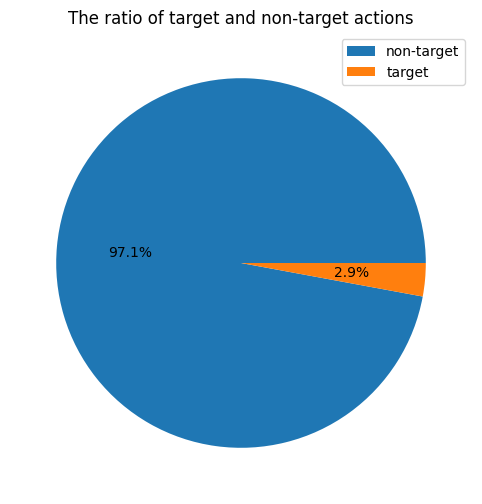

In [436]:
## соотношение целевых и нецелевых действий
counts = df_full_copy['target_col'].value_counts()

plt.figure(figsize= (12, 6))
plt.pie(counts, autopct='%1.1f%%')
plt.title('The ratio of target and non-target actions')
plt.legend(['non-target', 'target'], loc='upper right')

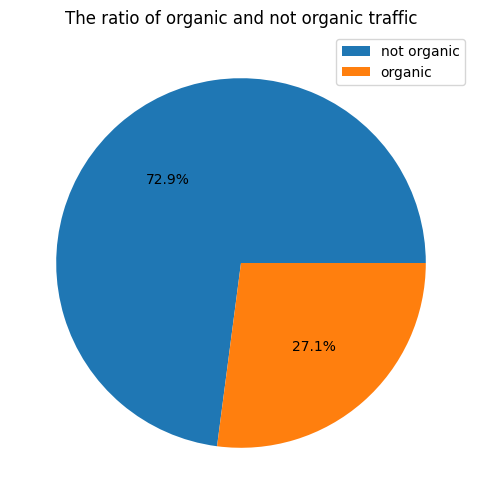

In [437]:
## соотношение органического и неорганического трафика
counts = df_full_copy['traffic'].value_counts()
plt.figure(figsize= (12, 6))
plt.pie(counts, autopct='%1.1f%%')
plt.title('The ratio of organic and not organic traffic')
plt.legend(['not organic', 'organic'], loc='upper right')

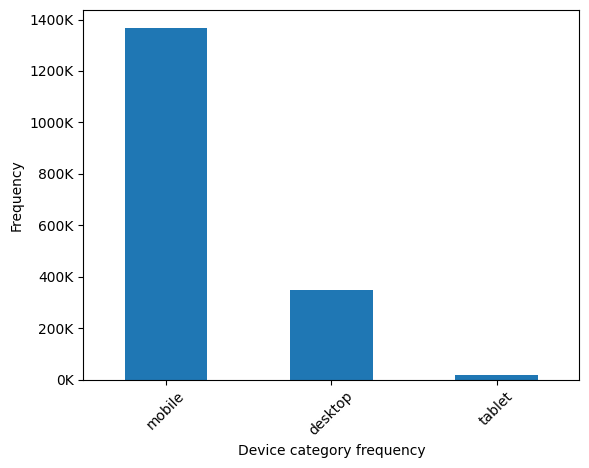

In [438]:
## Распределение типов устройств
device_category = df_full['device_category'].value_counts()
ax = device_category.plot(kind='bar')
plt.xlabel('Device category frequency')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1000:.0f}K'))
plt.show()

In [167]:
## Распределение операционных систем
## Сначала заменим редко встречаемые OC на other
os_counts = df_full_copy['device_os'].value_counts()
df_full_copy['device_os'] = df_full_copy['device_os'].replace(os_counts[os_counts < 1000].index, 'other')

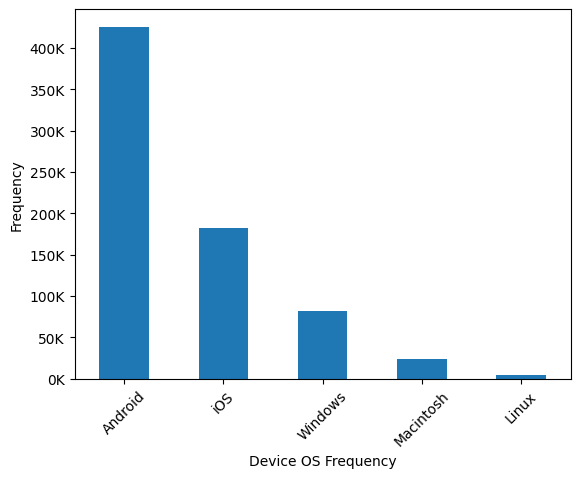

In [168]:
## График без учета "other"
df_filtered = df_full_copy[df_full_copy['device_os'] != 'other']
device_os = df_filtered['device_os'].value_counts()
ax = device_os.plot(kind='bar')
plt.xlabel('Device OS Frequency')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1000:.0f}K'))

plt.show()

In [439]:
##распределение марок автомобилей
## Сначала заменим редко встречаемые OC на other
cars_counts = df_full_copy['car_name'].value_counts()
df_full_copy['car_name'] = df_full_copy['car_name'].replace(cars_counts[cars_counts < 100].index, 'other')
 

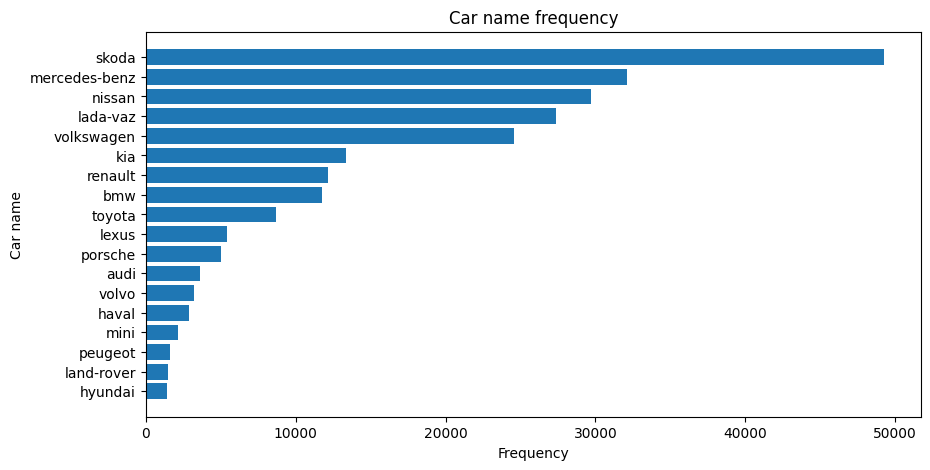

In [440]:
## График без учета "other"
df_filtered = df_full_copy[df_full_copy['car_name'] != 'other']
fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(car_name_sorted.index, car_name_sorted.values)
plt.xlabel('Frequency')
plt.ylabel('Car name')
plt.title('Car name frequency')
plt.show()

In [172]:
## распределение по регионам
region_count = df_full.geo_region.value_counts()
region_count_sorted = region_count.sort_values(ascending=True)
df_full_copy['geo_region'] = df_full_copy['geo_region'].replace(region_count[region_count< 5000].index, 'other')


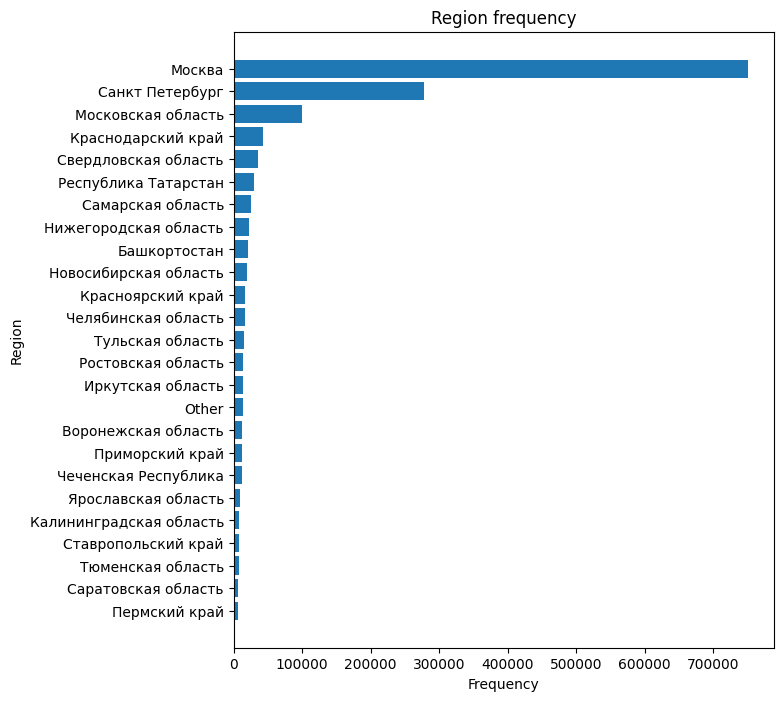

In [173]:
df_filtered = df_full_copy[df_full_copy['geo_region'] != 'other']
region_count = df_filtered.geo_region.value_counts()
region_count_sorted = region_count.sort_values(ascending=True)
fig, ax = plt.subplots(figsize=(9, 8))
ax.barh(region_count_sorted.index, region_count_sorted.values)
plt.xlabel('Frequency')
plt.ylabel('Region')
plt.title('Region frequency')
plt.subplots_adjust(left=0.3)
plt.show()

### Динамика событий по времени

In [443]:
df_full_copy.set_index('visit_date_time', inplace=True)

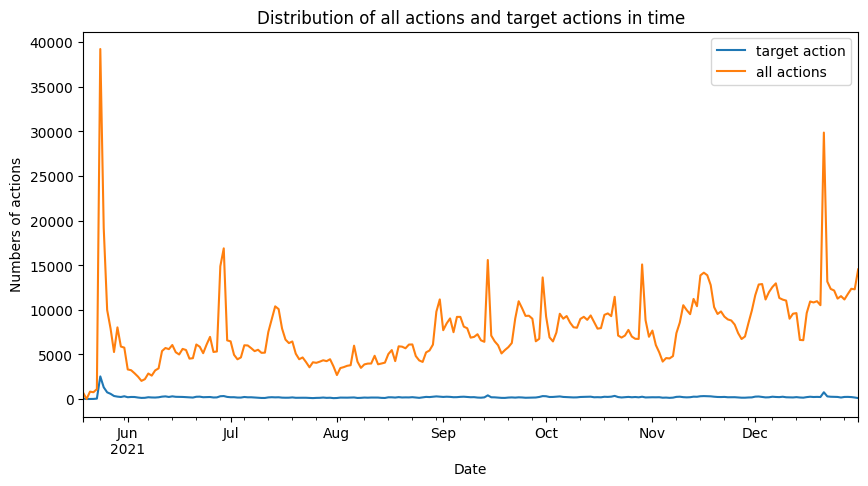

In [454]:
## Распределение целевых и нецелевых действий по времени
target_col = 'target_col'
fig, ax = plt.subplots(figsize=(10,5))
df_full_copy[target_col].resample('D').sum().plot(ax=ax)
df_full_copy.resample('D').count().plot(y='target_col', ax=ax)
plt.title('Distribution of all actions and target actions in time')
plt.xlabel('Date')
plt.ylabel('Numbers of actions')
ax.legend(['target action', 'all actions'])
plt.show()

По графику видно, что время от времени наблюдаются пики ативности пользователей

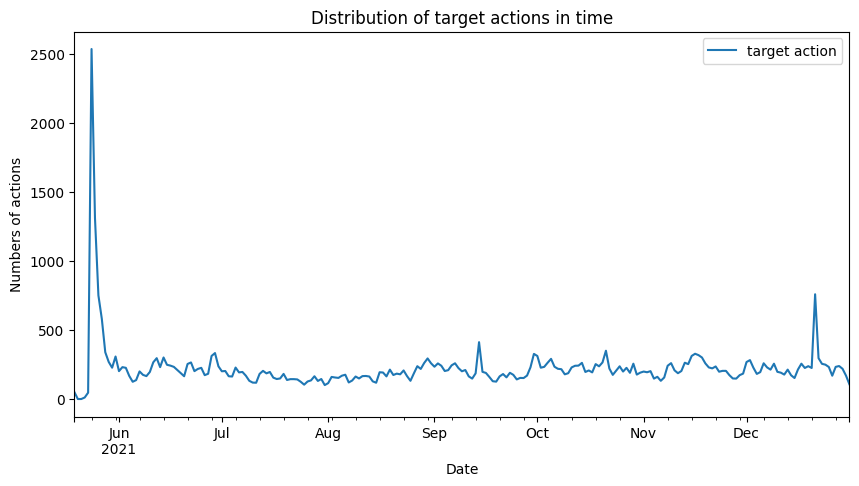

In [445]:
## Распределение целевых действий по времени
fig, ax = plt.subplots(figsize=(10, 5))
df_full_copy[target_col].resample('D').sum().plot()
plt.title('Distribution of target actions in time')
plt.xlabel('Date')
plt.ylabel('Numbers of actions')
ax.legend(['target action'])
plt.show()

In [461]:
## Дни когда происходили пики активности
df_full_copy[target_col].resample('D').count().sort_values(ascending=False).head(20)

visit_date_time
2021-05-24    39230
2021-12-21    29864
2021-05-25    19160
2021-06-29    16887
2021-09-14    15583
2021-10-29    15085
2021-06-28    14880
2021-12-31    14531
2021-11-16    14162
2021-11-17    13878
2021-11-15    13861
2021-09-30    13629
2021-12-22    13169
2021-12-07    12966
2021-12-03    12886
2021-12-02    12834
2021-11-18    12775
2021-12-06    12554
2021-12-29    12356
2021-12-23    12339
Name: target_col, dtype: int64

Если сопоставить эти даты с событиями и нововведениями, проводимыми компанией в то или иное время можно попробовать понять, что именно приводит образованию пиков посещения ресурса, но для такого анализа необходима дополнительная информация.

In [460]:
## Дни когда происходили пики целевых действий
df_full_copy[target_col].resample('D').sum().sort_values(ascending=False).head(20)

visit_date_time
2021-05-24    2536
2021-05-25    1311
2021-12-21     759
2021-05-26     751
2021-05-27     580
2021-09-14     412
2021-10-21     350
2021-05-28     339
2021-06-29     333
2021-11-16     328
2021-09-30     327
2021-11-17     318
2021-10-01     312
2021-11-15     312
2021-06-28     312
2021-05-31     308
2021-11-18     301
2021-06-14     301
2021-06-12     296
2021-12-22     296
Name: target_col, dtype: int64

Пиковые даты для общего количества действий и целевых действий вцелом совпадают. Максимальные значения в основном приходятся на конец мая (начало исследуемого периода) и конец декабря. 

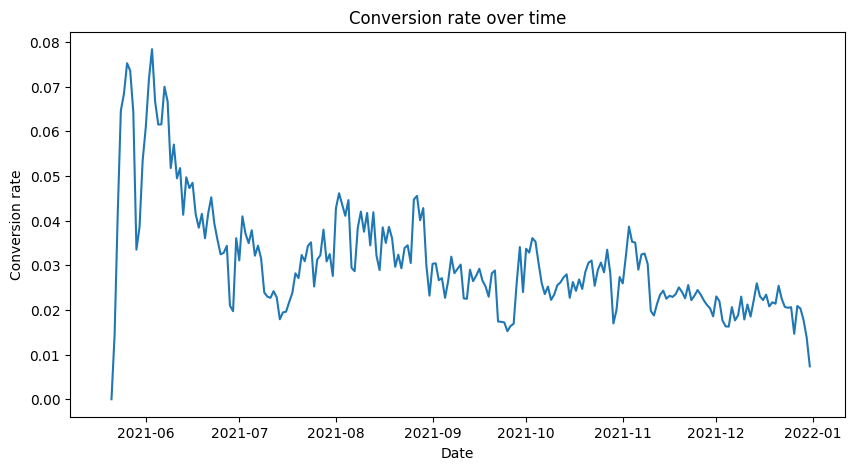

In [448]:
conversion_rate = df_full_copy[target_col].resample('D').mean()
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(conversion_rate)
plt.title('Conversion rate over time')
plt.xlabel('Date')
plt.ylabel('Conversion rate')
plt.show()

Видна общая тенденция для конверсии в целевое действие - ее снижение со временем. 

Для более точного анализа распределения целевых и нецелевых действий по времени можно посмотреть данные за несколько лет, тк тут может играть роль фактор сезонности

In [177]:
##Распределение целевых и нецелевых действий по дням недели
df_full_copy = df_full.copy()

In [178]:
grouped_day = df_full_copy.groupby([df_full_copy['visit_date_time'].dt.weekday, 'target_col']).size().unstack()

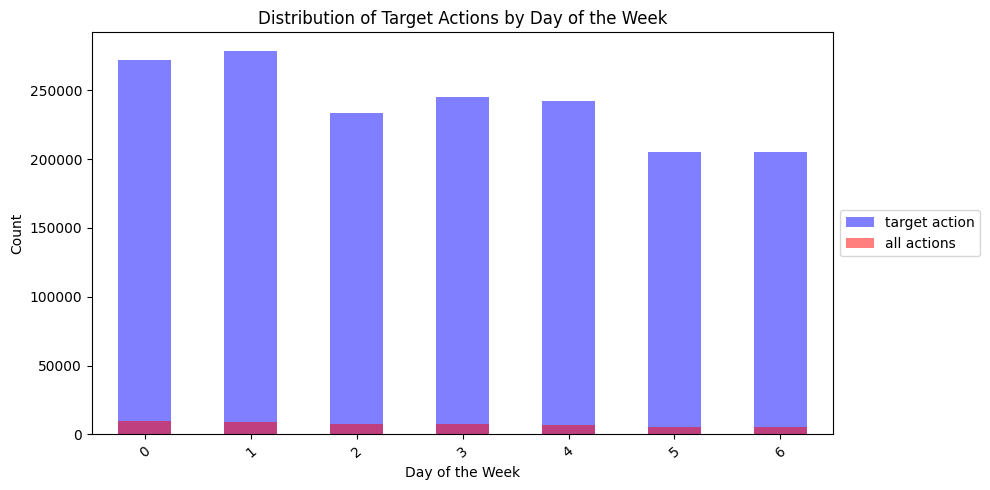

In [462]:
plt.figure(figsize= (10, 5))
ax1 = grouped_day[0].plot(kind='bar', color='blue', alpha=0.5)
ax1.set_xlabel('Day of the Week')
ax1.set_ylabel('Count')
ax1.set_title('Distribution of Non-Target Actions by Day of the Week')


ax2 = grouped_day[1].plot(kind='bar', color='red', alpha=0.5)
ax2.set_xlabel('Day of the Week')
ax2.set_ylabel('Count')
ax2.set_title('Distribution of Target Actions by Day of the Week')

plt.legend(['target action', 'all actions'], loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xticks(rotation=40)
plt.xticks(range(len(grouped_day[0].index)), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.tight_layout()

Пользователи чаще посещают ресурс вначале недели. В выходные значения самые низкие

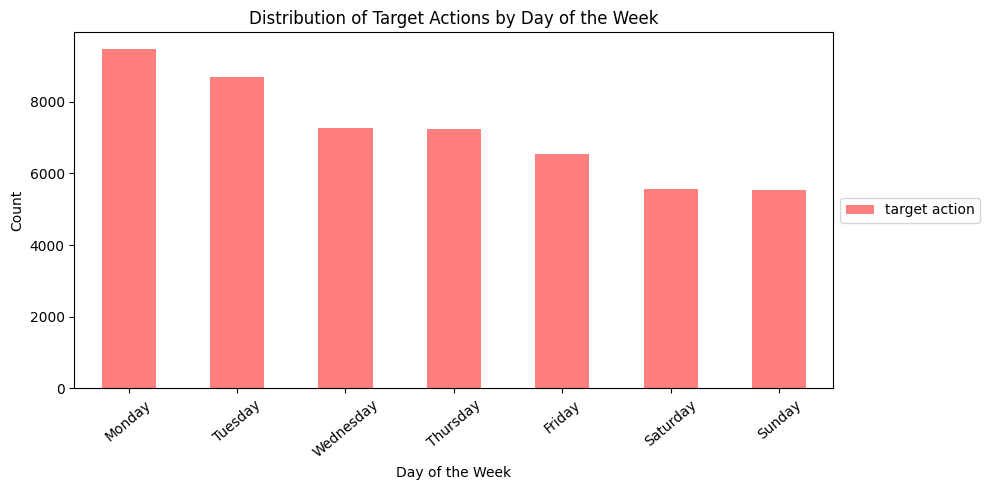

In [485]:
##Распределение целевых действий по дням недели
plt.figure(figsize= (10, 5))
ax = grouped_day[1].plot(kind='bar', color='red', alpha=0.5)
ax.set_xlabel('Day of the Week')
ax.set_ylabel('Count')
ax.set_title('Distribution of Target Actions by Day of the Week')
plt.legend(['target action'], loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xticks(rotation=40)
plt.xticks(range(len(grouped_day[0].index)), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.tight_layout()

В начале недели целевых действий совершается больше, чем в конце недели

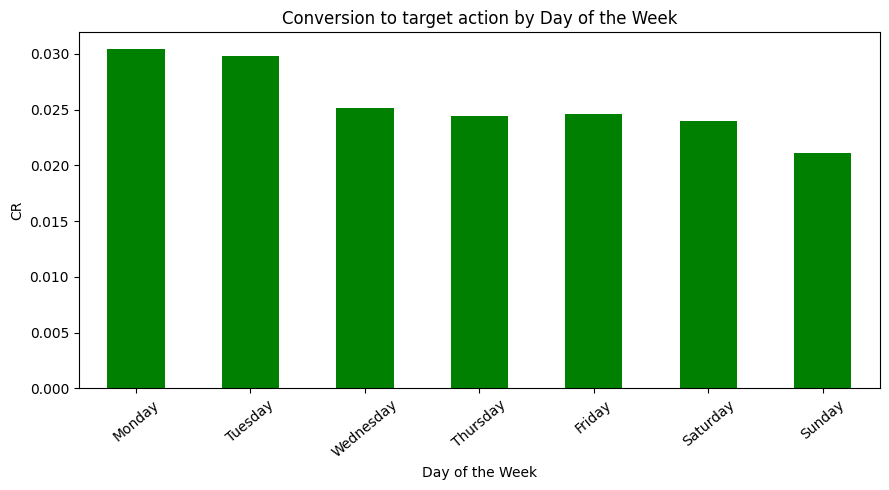

In [490]:
plt.figure(figsize= (9, 5))
grouped_day['conversion'] = grouped[1] / (grouped[0] + grouped[1])
ax = grouped_day['conversion'].plot(kind='bar', color = 'green')
ax.set_xlabel('Day of the Week')
ax.set_ylabel('CR')
ax.set_title('Conversion to target action by Day of the Week')
plt.xticks(rotation=40)
plt.xticks(range(len(grouped_day[0].index)), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.tight_layout()

СR немного выше в начале недели, чем в конце

In [181]:
## Распределение целевых и нецелевых действий по часам
df_full_copy['hour'] = df_full_copy['visit_date_time'].dt.hour
grouped_hour = df_full_copy.groupby(['hour', 'target_col']).size().unstack()

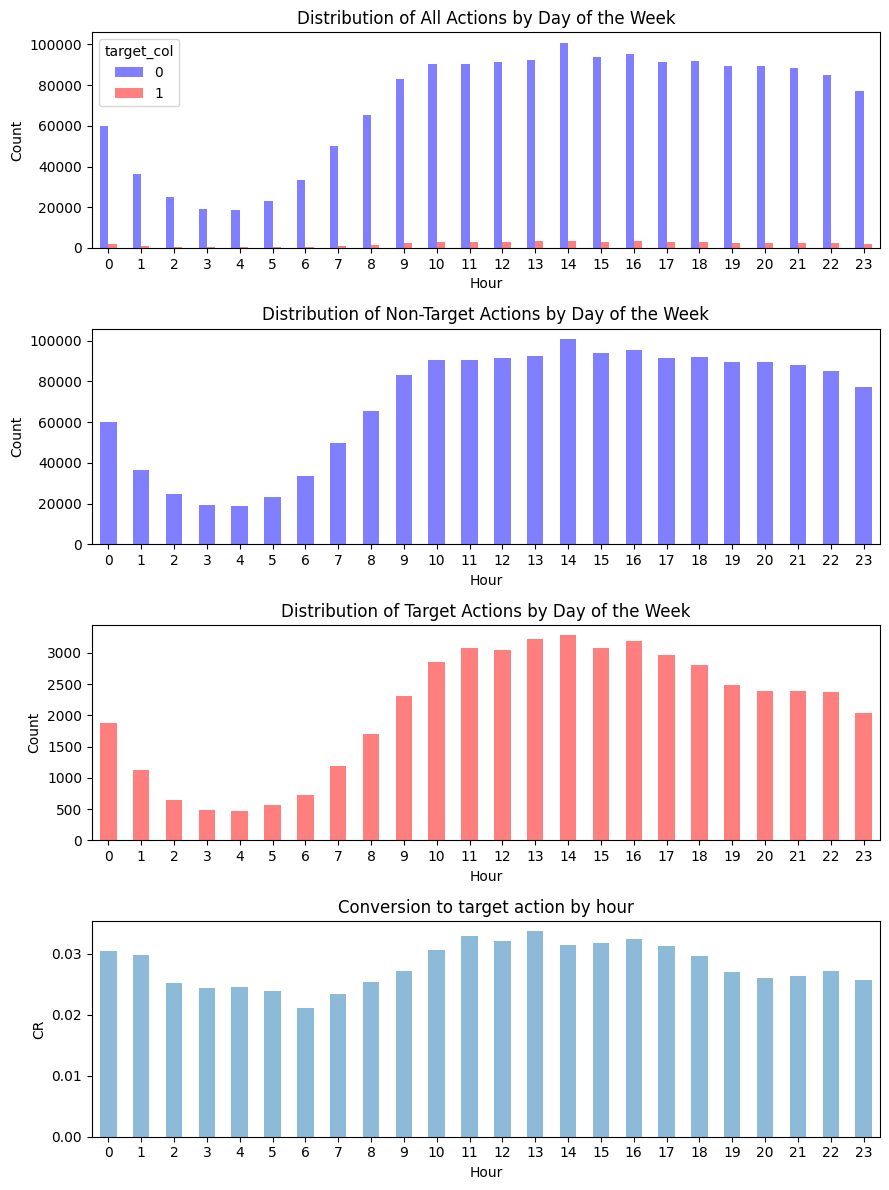

In [479]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(9, 12))
grouped_hour.plot(kind='bar', color=['blue', 'red'] , alpha=0.5, ax=ax1)
ax1.set_xlabel('Hour')
ax1.set_ylabel('Count')
ax1.set_title('Distribution of All Actions by Day of the Week')
ax1.set_xticklabels(ax1.get_xticks(), rotation = 0)

grouped_hour[0].plot(kind='bar', color='blue', alpha=0.5, ax=ax2)
ax2.set_xlabel('Hour')
ax2.set_ylabel('Count')
ax2.set_title('Distribution of Non-Target Actions by Day of the Week')
ax2.set_xticklabels(ax2.get_xticks(), rotation = 0)

grouped_hour[1].plot(kind='bar', color='red', alpha=0.5, ax=ax3)
ax3.set_xlabel('Hour')
ax3.set_ylabel('Count')
ax3.set_title('Distribution of Target Actions by Day of the Week')
ax3.set_xticklabels(ax3.get_xticks(), rotation = 0)

grouped = df_full_copy.groupby(['hour', 'target_col']).size().unstack()
grouped['conversion'] = grouped[1] / (grouped[0] + grouped[1])
grouped['conversion'].plot(kind='bar', alpha=0.5, ax=ax4)
ax4.set_xlabel('Hour')
ax4.set_ylabel('CR')
ax4.set_title('Conversion to target action by hour')
ax4.set_xticklabels(ax3.get_xticks(), rotation = 0)

plt.tight_layout()

Пользователи более активно пользуются ресурсом с 9 до 23, целевые действия наиболее активно совершаются в промежуток с 10 до 18.

### Корелляции численных признаков

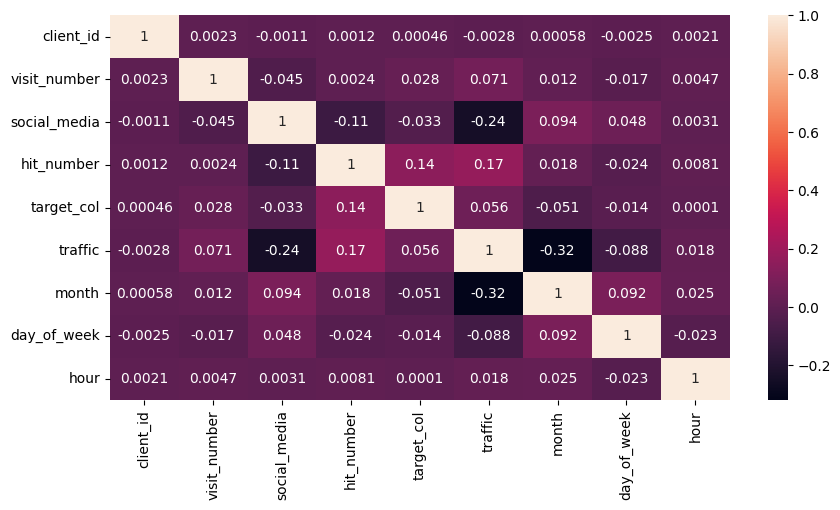

In [491]:
## Построим таблицу корреляций численных переменных 
numeric_cols = df_full_copy.select_dtypes(include=['Float64', 'Int64', 'Int32']).columns
corr_matrix = df_full_copy[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True)
plt.gcf().set_size_inches(10, 5)

Кореляций не обнаружено (все значения меньше 0.5 по модулю)

In [184]:
df_target = df_full_copy[df_full_copy['target_col'] == 1]

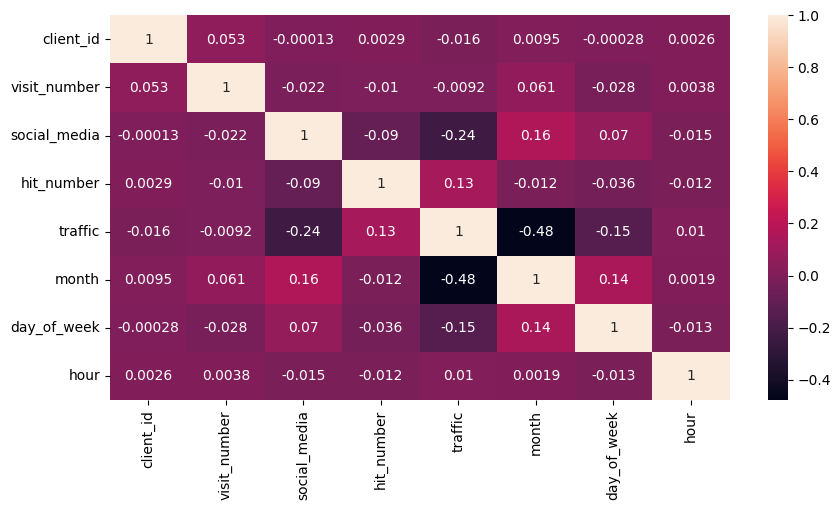

In [493]:
##Построим таблицу корелляций только для целевых действий
numeric_cols = df_target.select_dtypes(include=['Float64', 'Int64', 'Int32']).columns
corr_matrix = df_target[numeric_cols].corr()
sns.heatmap(corr_matrix.drop('target_col', axis=1).drop('target_col', axis=0), annot=True)
plt.gcf().set_size_inches(10, 5)

Значение коэффициента корелляции между traffic(органически или неорганический трафик) и month(месяц) равен 0.48. Примем это за слабую корелляцию и посмотрим эту взаимосвязь на графике

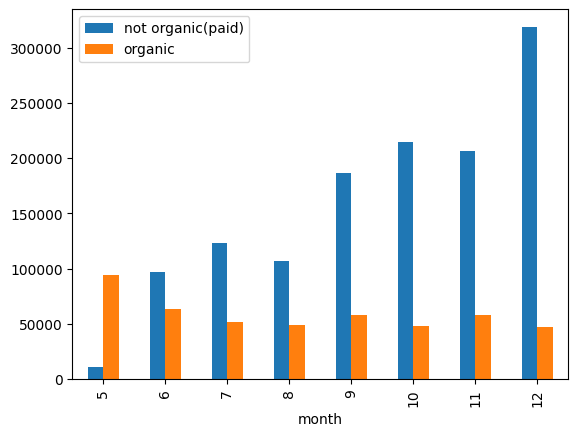

In [494]:
## Для всех значений
df_full_copy.groupby(['month', 'traffic']).size().unstack().plot(kind='bar')
plt.legend(['not organic(paid)', 'organic'])
plt.show()

На графике виден рост платного трафика, в то время как органический трафик после ондго падения в июне держит примерно одинаковые позиции. Рост платного трафика скорее всего связан увеличением количества рекламы ресурса в интернете

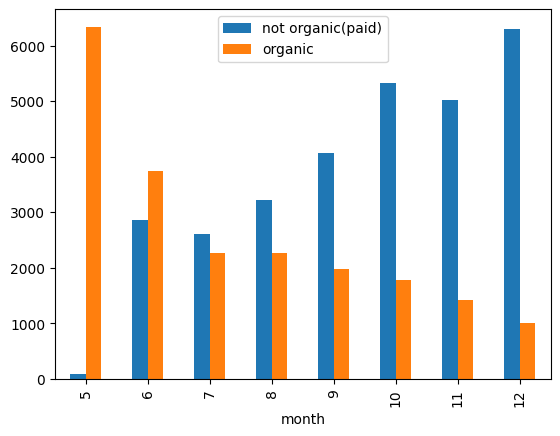

In [495]:
## Для целевых действий
df_target.groupby(['month', 'traffic']).size().unstack().plot(kind='bar')
plt.legend(['not organic(paid)', 'organic'])
plt.show()

Хорошо проглядывается отрицательная корреляция обнаруженная на heatmap. Количество целевых действий в органическом трафике со временем падает, а в платном растет.

# DA

## Проверка гипотез

### Органический трафик не отличается от платного с точки зрения CR (Conversion Rate) в целевые события.

In [11]:
df_full_copy['date'] = df_full_copy['visit_date_time'].dt.date

In [82]:
result = df_full_copy.groupby(['traffic', 'target_col']).size().unstack(fill_value=0)
result['CR %'] = result[1] / (result[0] + result[1])*100
print(result)

target_col        0      1      CR %
traffic                             
0           1233844  29502  2.335227
1            448108  20812  4.438284


CR для органического трафика равен 4.44%, для платного  2.36%. 
Органический трафик отличается от платного с точки зрения CR в целевые события почти в два раза, несмотря на то, что общее количество пользователей платного трафика намного больше. 


Из этой предварительной оценки сформулируем гипотезы и проверим их

Нулевая гипотеза - органический трафик не отличается от платного с точки зрения CR (Conversion Rate) в целевые события.
Альтернативная гипотеза - органический трафик отличается от платного с точки зрения CR (Conversion Rate) в целевые события в большую сторону

In [ ]:
hypothesis = df_full_copy.groupby(['date', 'traffic'])['target_col'].mean()

hypothesis_df = hypothesis.reset_index()

In [67]:
groups = hypothesis_df.groupby('traffic')

In [68]:
df_0 = groups.get_group(0)
df_1 = groups.get_group(1)

In [69]:
df_1 = df_1.drop('traffic', axis=1)
df_0 = df_0.drop('traffic', axis=1)
df_1.rename(columns={'target_col': 'CR_organic'}, inplace=True)
df_0.rename(columns={'target_col': 'CR_paid'}, inplace=True)

In [93]:
df_paid_organic = pd.merge(df_0, df_1, on='date')

In [94]:
df_paid_organic

date   CR_paid  CR_organic
0    2021-05-19  0.000000    0.071736
1    2021-05-21  0.000000    0.000000
2    2021-05-22  0.014706    0.014430
3    2021-05-23  0.025424    0.045819
4    2021-05-24  0.030303    0.064995
..          ...       ...         ...
221  2021-12-27  0.022141    0.016177
222  2021-12-28  0.021912    0.012239
223  2021-12-29  0.017629    0.018430
224  2021-12-30  0.013582    0.016260
225  2021-12-31  0.007305    0.008523

[226 rows x 3 columns]

Выборки зависимы, даты одни и те же.
Проверим нормальные ли распределения, тест Шапиро-Уилка

In [95]:
stats.shapiro(df_paid_organic.CR_organic)

ShapiroResult(statistic=0.9760780930519104, pvalue=0.0007057650364004076)

In [97]:
stats.shapiro(df_paid_organic.CR_paid)

ShapiroResult(statistic=0.9524452090263367, pvalue=8.639231623419619e-07)

Распределения ненормальные в обоих случаях. Pvalue очень мало, менее 5% (отвергаем нулевую гипотезу о нормальности распределений)

Используем тест Вилкоксона для сравнения конверсии в целевое действие платного и органического трафика.

In [98]:
stats.wilcoxon(df_paid_organic.CR_organic, df_paid_organic.CR_paid, alternative='greater')

WilcoxonResult(statistic=23889.0, pvalue=1.4226943703120147e-30)

Значение pvalue менее 5%, отвергаем нулевую гипотезу. Органический трафик отличается от платного с точки зрения CR (Conversion Rate) в целевые события в большую сторону

Платный трафик существенно увеличивает количество пользователей посетивших ресурс, но не увеличивает пропорционально количество совершаемых целевых действий. Пользователи достаточно заинтересованы, что бы посетить ресурс, но недостаточно заинтересованы предпринимать какие-то дальнейшие действия

### Трафик с мобильных устройств не отличается от трафика с десктопных устройств с точки зрения CR (Conversion Rate) в целевые события

In [497]:
result = df_full_copy.groupby(['device_category', 'target_col']).size().unstack(fill_value=0)
result['CR %'] = result[1] / (result[0] + result[1])*100
print(result)

target_col             0      1      CR %
device_category                          
desktop           335378  11513  3.318910
mobile           1330300  38379  2.804091
tablet             16274    422  2.527552


CR для мобильных устройств равен 2.8%, для десктопных устройств 3.3%. 

Нулевая гипотеза - трафик с мобильных устройств не отличается от трафика с десктопных устройств с точки зрения CR в целевые события.

Альтернативная гипотеза - трафик с мобильных устройств отличается от трафика с десктопных устройств в меньшую сторону с точки зрения CR в целевые события.

In [84]:
hypothesis = df_full_copy.groupby(['date', 'device_category'])['target_col'].mean()

hypothesis_df = hypothesis.reset_index()

In [85]:
hypothesis_df

date device_category  target_col
0    2021-05-19         desktop    0.072727
1    2021-05-19          mobile    0.069841
2    2021-05-19          tablet    0.000000
3    2021-05-21         desktop    0.000000
4    2021-05-21          mobile    0.000000
..          ...             ...         ...
673  2021-12-30          mobile    0.015794
674  2021-12-30          tablet    0.025000
675  2021-12-31         desktop    0.000321
676  2021-12-31          mobile    0.012663
677  2021-12-31          tablet    0.010753

[678 rows x 3 columns]

In [102]:
groups = hypothesis_df.groupby('device_category')

In [89]:
groups

In [111]:
df_mobile = groups.get_group('mobile')
df_desktop = groups.get_group('desktop')

In [112]:
df_mobile = df_mobile.drop('device_category', axis=1)
df_desktop = df_desktop.drop('device_category', axis=1)
df_mobile.rename(columns={'target_col': 'CR_mobile'}, inplace=True)
df_desktop.rename(columns={'target_col': 'CR_desktop'}, inplace=True)

In [113]:
df_mobile_desktop = pd.merge(df_mobile, df_desktop, on='date')

In [114]:
df_mobile_desktop

date  CR_mobile  CR_desktop
0    2021-05-19   0.069841    0.072727
1    2021-05-21   0.000000    0.000000
2    2021-05-22   0.013944    0.016000
3    2021-05-23   0.041775    0.041667
4    2021-05-24   0.064452    0.064996
..          ...        ...         ...
221  2021-12-27   0.020402    0.024487
222  2021-12-28   0.021531    0.012952
223  2021-12-29   0.018829    0.009907
224  2021-12-30   0.015794    0.004140
225  2021-12-31   0.012663    0.000321

[226 rows x 3 columns]

Выборки зависимы, проверим нормальные ли распределения, тест Шапиро-Уилка

In [116]:
stats.shapiro(df_mobile_desktop.CR_mobile)

ShapiroResult(statistic=0.9079797863960266, pvalue=1.385312420332241e-10)

In [117]:
stats.shapiro(df_mobile_desktop.CR_desktop)

ShapiroResult(statistic=0.8776528239250183, pvalue=1.5786438996301388e-12)

Распределения ненормальные в обоих случаях. Pvalue очень мало, менее 5% (отвергаем нулевую гипотезу о нормальности распределений)

Используем тест Вилкоксона для сравнения конверсии в целевое действие трафика с мобильных и десктопных устройств.

In [120]:
stats.wilcoxon(df_mobile_desktop.CR_mobile, df_mobile_desktop.CR_desktop, alternative='less')

WilcoxonResult(statistic=10260.0, pvalue=0.00605563222246603)

Значение pvalue менее 5%, отвергаем нулевую гипотезу. Трафик с мобильных устройств отличается от трафика с десктопных устройств в меньшую сторону с точки зрения CR в целевые события.

Стоит отметить, что трафика с мобильных устройств намного больше, чем с десктопных, одкако CR у мобильных ниже. Пользователь сидя за компьтером с большей вероятностью совершит целевое действие, чем пользователь с мобильным.  

### Трафик из городов присутствия (Москва и область, Санкт-Петербург) не отличается от трафика из иных регионов с точки зрения CR (Conversion Rate) в целевые события

In [122]:
## Отделим города присутсвия от остальных городов
def is_moscow_or_spb(region):
    if region in ['Москва', 'Московская область', 'Санкт Петербург']:
        return 1
    else:
        return 0

df_full_copy['is_moscow_or_spb'] = df_full_copy['geo_region'].apply(is_moscow_or_spb)

In [123]:
result = df_full_copy.groupby(['is_moscow_or_spb', 'target_col']).size().unstack(fill_value=0)
result['CR %'] = result[1] / (result[0] + result[1])*100
print(result)

target_col              0      1      CR %
is_moscow_or_spb                          
0                  586126  16510  2.739631
1                 1095826  33804  2.992484


CR для городов присутствия равен 2.99%, для иных регионов 2.74%. На первый взгляд разница несущественна

Нулевая гипотеза - трафик из городов присутствия (Москва и область, Санкт-Петербург) не отличается от трафика из иных регионов с точки зрения CR в целевые события

Альернативнвя гипотеза - трафик из городов присутствия (Москва и область, Санкт-Петербург) отличается от трафика из иных регионов с точки зрения CR в целевые события

In [124]:
hypothesis = df_full_copy.groupby(['date', 'is_moscow_or_spb'])['target_col'].mean()

hypothesis_df = hypothesis.reset_index()

In [126]:
groups = hypothesis_df.groupby('is_moscow_or_spb')

In [127]:
df_0 = groups.get_group(0)
df_1 = groups.get_group(1)

In [128]:
df_1 = df_1.drop('is_moscow_or_spb', axis=1)
df_0 = df_0.drop('is_moscow_or_spb', axis=1)
df_1.rename(columns={'target_col': 'CR_moscow_spb'}, inplace=True)
df_0.rename(columns={'target_col': 'CR_other'}, inplace=True)

In [129]:
df_cities = pd.merge(df_0, df_1, on='date')

In [130]:
df_cities

date  CR_other  CR_moscow_spb
0    2021-05-19  0.000000       0.119048
1    2021-05-21  0.000000       0.000000
2    2021-05-22  0.008368       0.017241
3    2021-05-23  0.020408       0.052999
4    2021-05-24  0.065182       0.064399
..          ...       ...            ...
221  2021-12-27  0.022045       0.019799
222  2021-12-28  0.020966       0.019720
223  2021-12-29  0.018466       0.017166
224  2021-12-30  0.017370       0.011525
225  2021-12-31  0.011917       0.005667

[226 rows x 3 columns]

Выборки зависимы, проверим нормальные ли распределения, тест Шапиро-Уилка

In [131]:
stats.shapiro(df_cities.CR_moscow_spb)

ShapiroResult(statistic=0.8400492072105408, pvalue=1.5875969023573452e-14)

In [132]:
stats.shapiro(df_cities.CR_other)

ShapiroResult(statistic=0.9081176519393921, pvalue=1.4167240991458385e-10)

Распределения ненормальные в обоих случаях. Pvalue очень мало, менее 5% (отвергаем нулевую гипотезу о нормальности распределений)

Используем тест Вилкоксона для сравнения конверсии в целевое действие трафика из городов присутсвия и из других регионов

In [133]:
stats.wilcoxon(df_cities.CR_other, df_cities.CR_moscow_spb)

WilcoxonResult(statistic=11363.0, pvalue=0.16742458385288517)

Значение Pvalue больше 5%. Нет оснований отвергать нулевую гипотезу. Трафик из городов присутствия существенно не отличается от трафика из иных регионов с точки зрения CR в целевые события

## Ответы на вопросы продуктовой команды

### Из каких источников / кампаний / устройств / локаций к нам идёт самый целевой трафик (и с точки зрения объёма трафика, и с точки  зрения CR)

In [193]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1732266 entries, 0 to 1732265
Data columns (total 26 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   session_id                object        
 1   client_id                 float64       
 2   visit_number              int64         
 3   utm_medium                object        
 4   device_category           object        
 5   device_os                 object        
 6   device_brand              object        
 7   device_screen_resolution  object        
 8   device_browser            object        
 9   geo_country               object        
 10  geo_city                  object        
 11  visit_date_time           datetime64[ns]
 12  geo_region                object        
 13  social_media              int64         
 14  hit_number                int64         
 15  hit_referer               object        
 16  event_category            object        
 17  event_ac

In [360]:
df_full_copy = df_full.copy()

In [398]:
df_full_copy.head(10)

session_id     client_id  visit_number  \
0  9055434745589932991.1637753792.1637753792  2.108383e+09             1   
1   905544597018549464.1636867290.1636867290  2.108385e+08             1   
2  9055446045651783499.1640648526.1640648526  2.108385e+09             1   
3  9055447046360770272.1622255328.1622255328  2.108386e+09             1   
4  9055447046360770272.1622255345.1622255345  2.108386e+09             2   
5  9055447192389856083.1622453074.1622453074  2.108386e+09             1   
6  9055455318486370642.1640843788.1640843788  2.108387e+09             1   
7  9055461992850812764.1626107740.1626107740  2.108389e+09             1   
8  9055462349345527315.1638536723.1638536723  2.108389e+09             1   
9  9055466554104774132.1624800757.1624800757  2.108390e+09             1   

  utm_medium device_category device_os device_brand device_screen_resolution  \
0     banner          mobile   Android       Huawei                  360x720   
1        cpm          mobile   Android      Samsung                  385x854   
2     banner          mobile   Android       Huawei                  360x720   
3        cpc          mobile     other       Xiaomi                  393x786   
4        cpc          mobile     other       Xiaomi                  393x786   
5    organic          mobile     other        Apple                  375x812   
6        cpc          tablet   Android       Lenovo                 602x1029   
7     banner          mobile     other      Samsung                  360x640   
8     banner          mobile       iOS        Apple                  390x844   
9     banner          mobile     other      Samsung                  412x915   

     device_browser geo_country  ... event_category            event_action  \
0            Chrome      Russia  ...  sub_page_view             sub_landing   
1  Samsung Internet      Russia  ...  sub_page_view             sub_landing   
2            Chrome      Russia  ...    search_form      search_form_region   
3            Chrome      Russia  ...  sub_page_view             sub_landing   
4            Chrome      Russia  ...           quiz               quiz_show   
5            Safari      Russia  ...  sub_page_view             sub_landing   
6         YaBrowser      Russia  ...       card_web           view_new_card   
7            Chrome      Russia  ...    search_form  search_form_search_btn   
8            Safari      Russia  ...  sub_page_view             sub_landing   
9            Chrome      Russia  ...  sub_page_view             sub_landing   

            event_label  car_model  car_name target_col traffic month  \
0                 other      other     other          0       0    11   
1                 other      other     other          0       0    11   
2  KWTCzSIXzoqUWjfUQMgP      other     other          0       0    12   
3  KclpemfoHstknWHFiLit      other     other          0       0     5   
4  KclpemfoHstknWHFiLit      other     other          0       0     5   
5  KclpemfoHstknWHFiLit      other     other          0       1     5   
6                 other      rapid     skoda          0       0    12   
7  ghOrjqpgskpGHSFfBBsi      other     other          0       0     7   
8                 other      other     other          0       0    12   
9  KclpemfoHstknWHFiLit      other     other          0       0     6   

  day_of_week hour  
0           2   14  
1           6    8  
2           1    2  
3           5    5  
4           5    5  
5           0   12  
6           3    8  
7           0   19  
8           4   16  
9           6   16  

[10 rows x 26 columns]

#### utm_medium — тип привлечения

In [361]:
## utm_medium — тип привлечения
counts = df_full_copy.utm_medium.value_counts()
df_full_copy['utm_medium'] = df_full_copy['utm_medium'].apply(lambda x: 'other' if counts[x] < 100 else x)

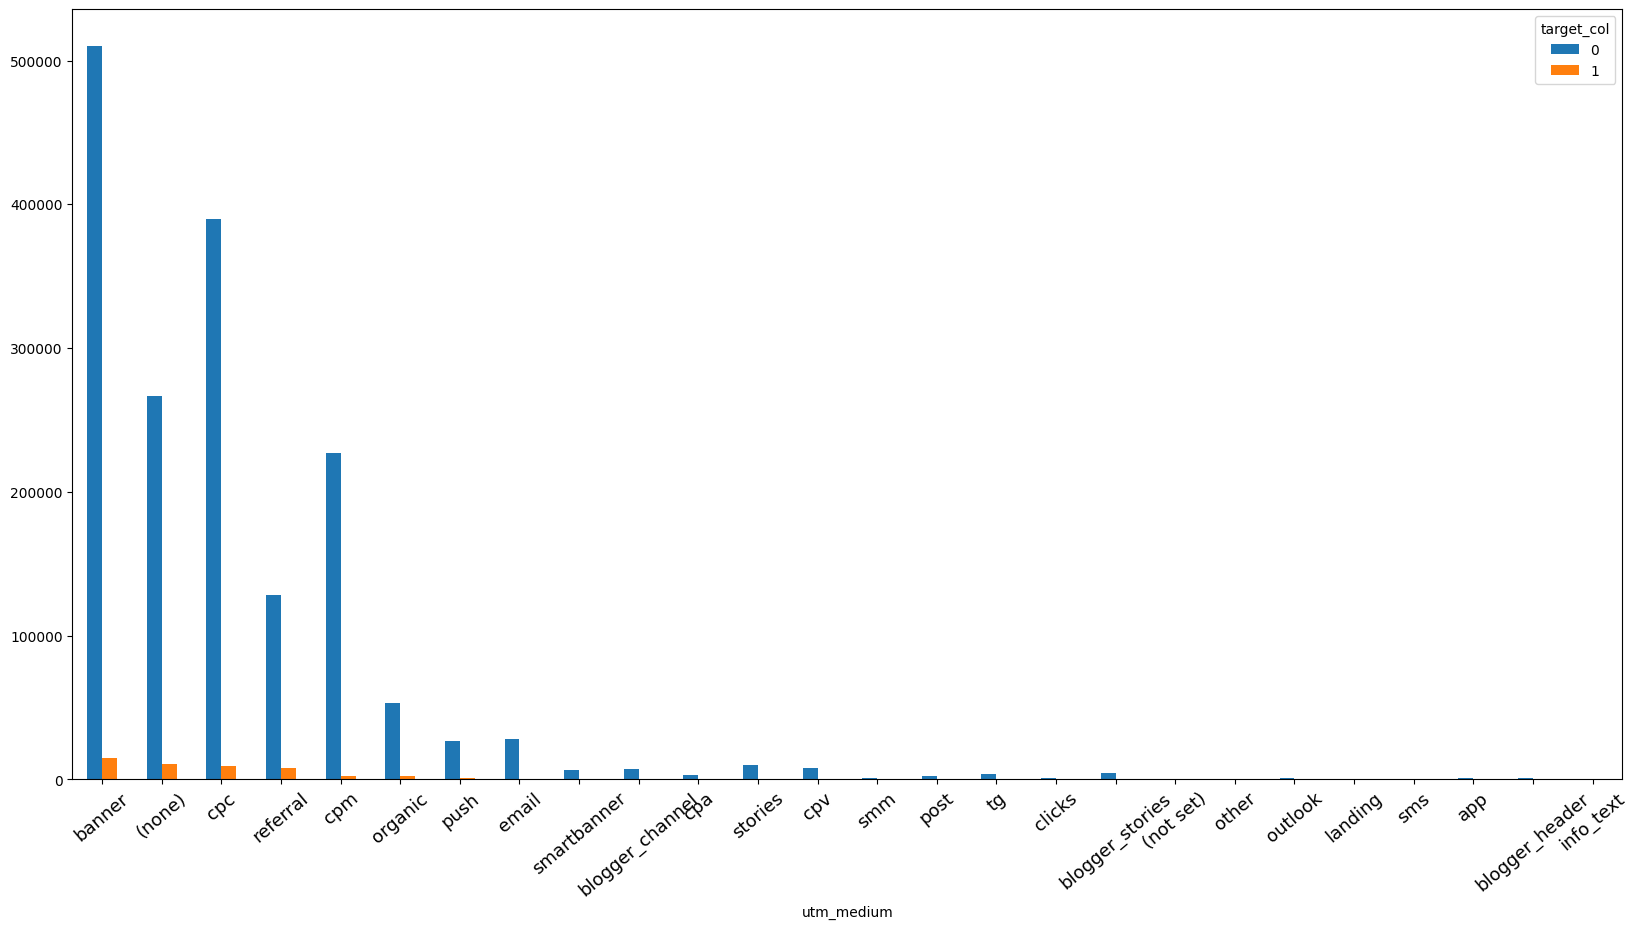

In [362]:
##Объем трафика
fig, ax = plt.subplots(figsize=(20, 10))
df_full_copy.groupby(['utm_medium', 'target_col']).size().unstack().sort_values(by=1, ascending=False).plot(kind='bar', ax=ax)
plt.xticks(rotation=40, size=13)
plt.show()

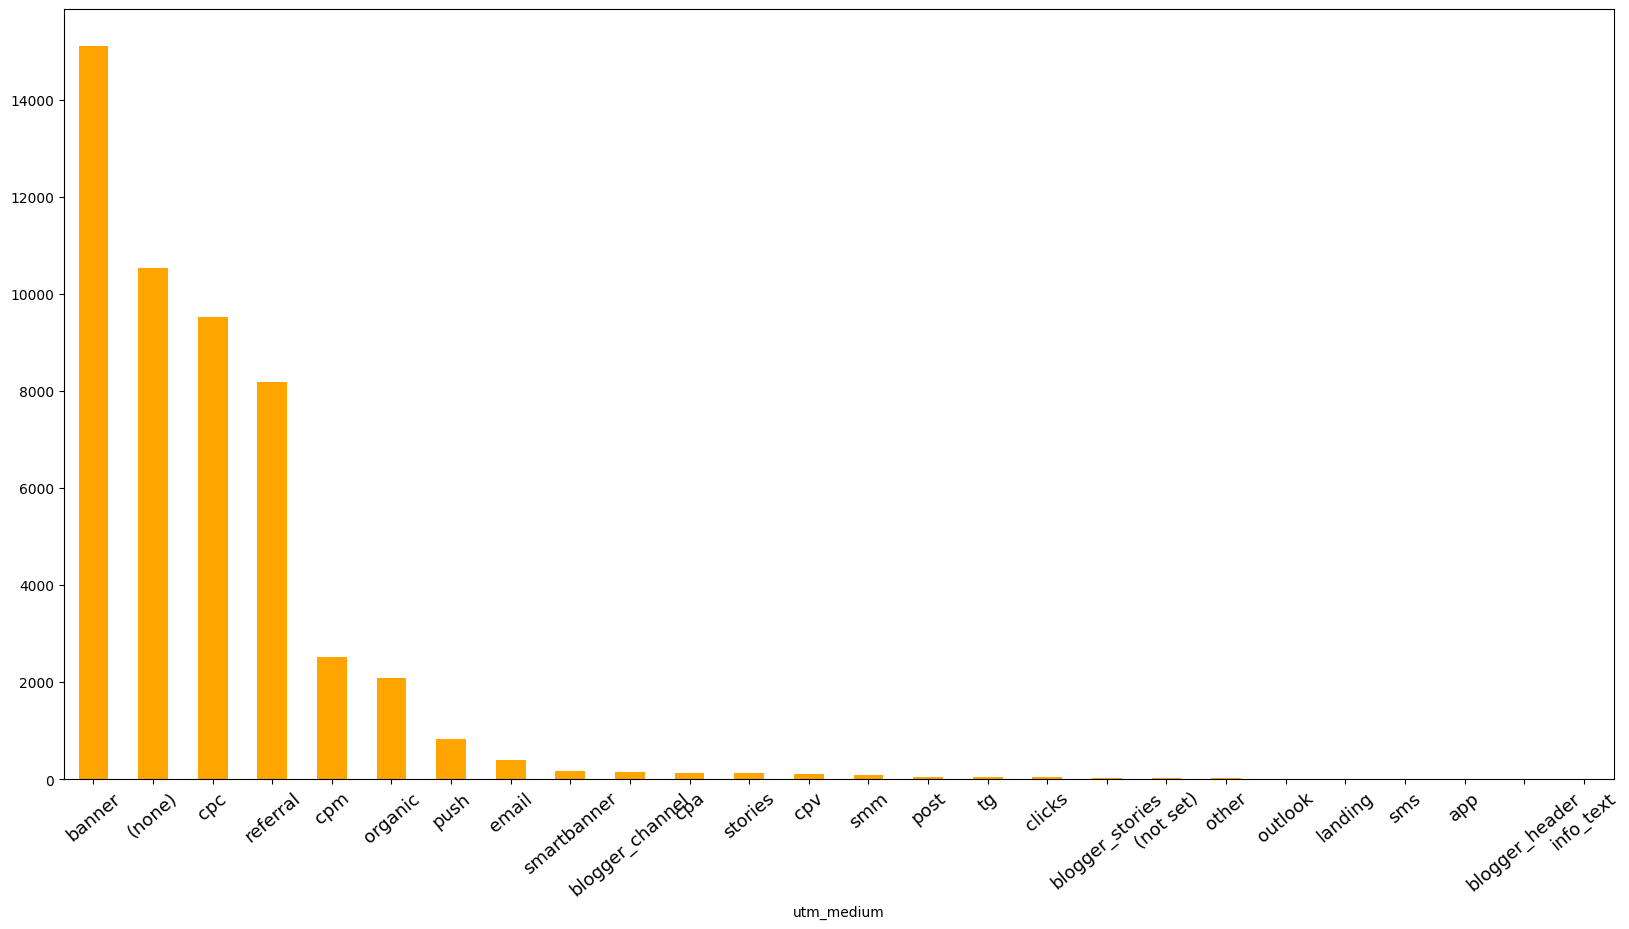

In [364]:
##Объем трафика (целевые действия)
fig, ax = plt.subplots(figsize=(20, 10))
grouped = df_full_copy.groupby('utm_medium')['target_col'].sum()
grouped = grouped.sort_values(ascending=False)
grouped.plot(kind='bar', color = 'orange')
plt.xticks(rotation=40, size=13)
plt.show()

In [365]:
## Трафик
grouped.sort_values(ascending=False)

utm_medium
banner             15107
(none)             10531
cpc                 9529
referral            8181
cpm                 2519
organic             2100
push                 840
email                401
smartbanner          179
blogger_channel      162
cpa                  131
stories              126
cpv                  115
smm                   87
post                  54
tg                    51
clicks                42
blogger_stories       35
(not set)             28
other                 27
outlook               19
landing               19
sms                   16
app                   11
blogger_header         2
info_text              2
Name: target_col, dtype: int64

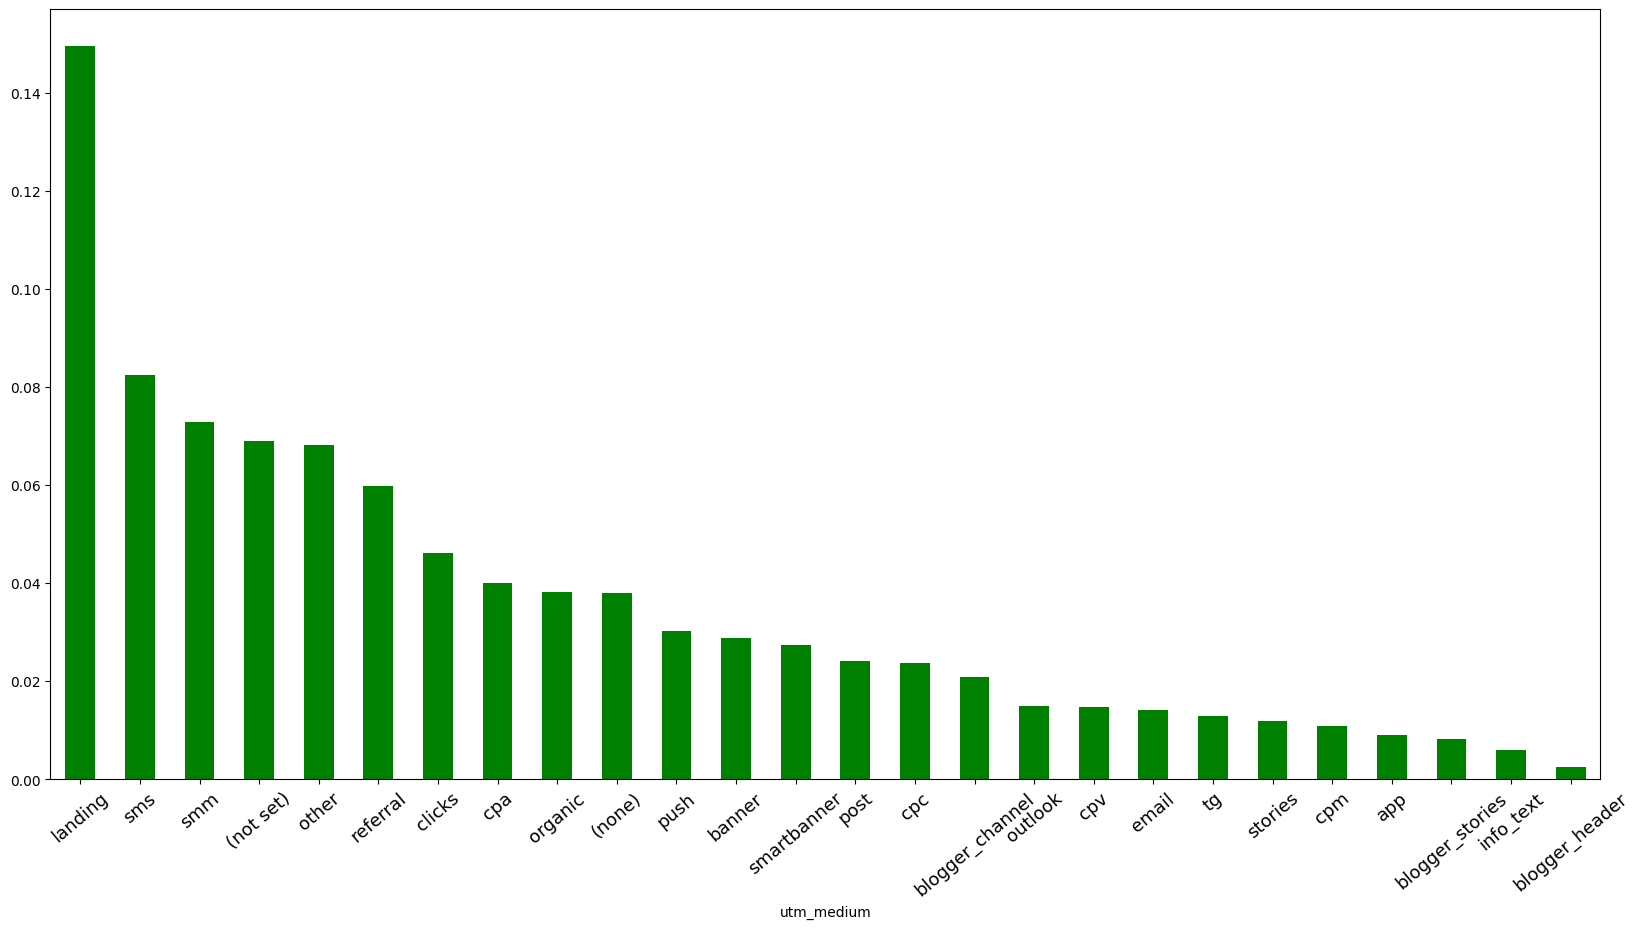

In [279]:
## Конверсия в целевое действие CR
fig, ax = plt.subplots(figsize=(20, 10))
grouped = df_full_copy.groupby('utm_medium')['target_col'].mean()
grouped = grouped.sort_values(ascending=False)
grouped.plot(kind='bar', color = 'green')
plt.xticks(rotation=40, size=13)
plt.show()

In [281]:
grouped.sort_values(ascending=False)

utm_medium
landing            0.149606
sms                0.082474
smm                0.072864
(not set)          0.069136
other              0.068182
referral           0.059780
clicks             0.046256
cpa                0.040110
organic            0.038176
(none)             0.038010
push               0.030314
banner             0.028764
smartbanner        0.027534
post               0.024248
cpc                0.023859
blogger_channel    0.020955
outlook            0.014972
cpv                0.014715
email              0.014176
tg                 0.013010
stories            0.012032
cpm                0.010962
app                0.009083
blogger_stories    0.008282
info_text          0.005970
blogger_header     0.002632
Name: target_col, dtype: float64

Максимальный трафик идет на ресурс через банеры.
С точки зрения CR максимально успешен лендинг

#### event_category - тип действия

In [352]:
df_full_copy = df_full.copy()

In [353]:
counts = df_full_copy.event_category.value_counts()
df_full_copy['event_category'] = df_full_copy['event_category'].apply(lambda x: 'other' if counts[x] < 300 else x)

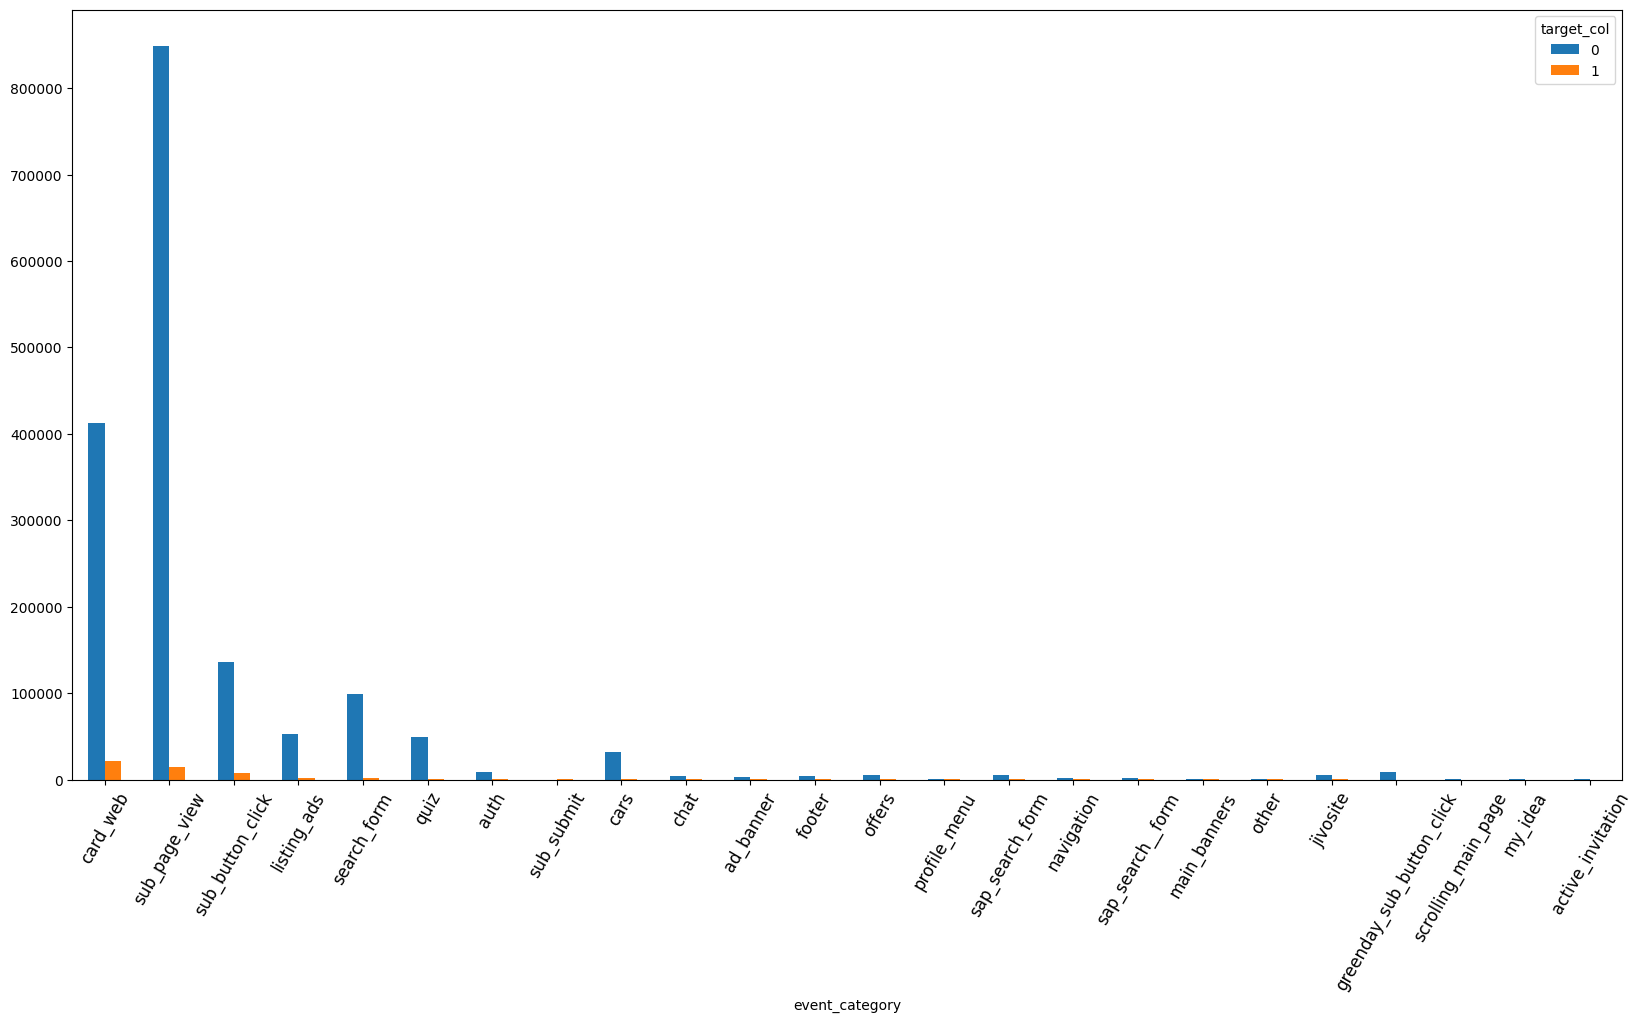

In [354]:
fig, ax = plt.subplots(figsize=(20, 10))
df_full_copy.groupby(['event_category', 'target_col']).size().unstack().sort_values(by=1, ascending=False).plot(kind='bar', ax=ax)
plt.xticks(rotation=60, size=12)
plt.show()

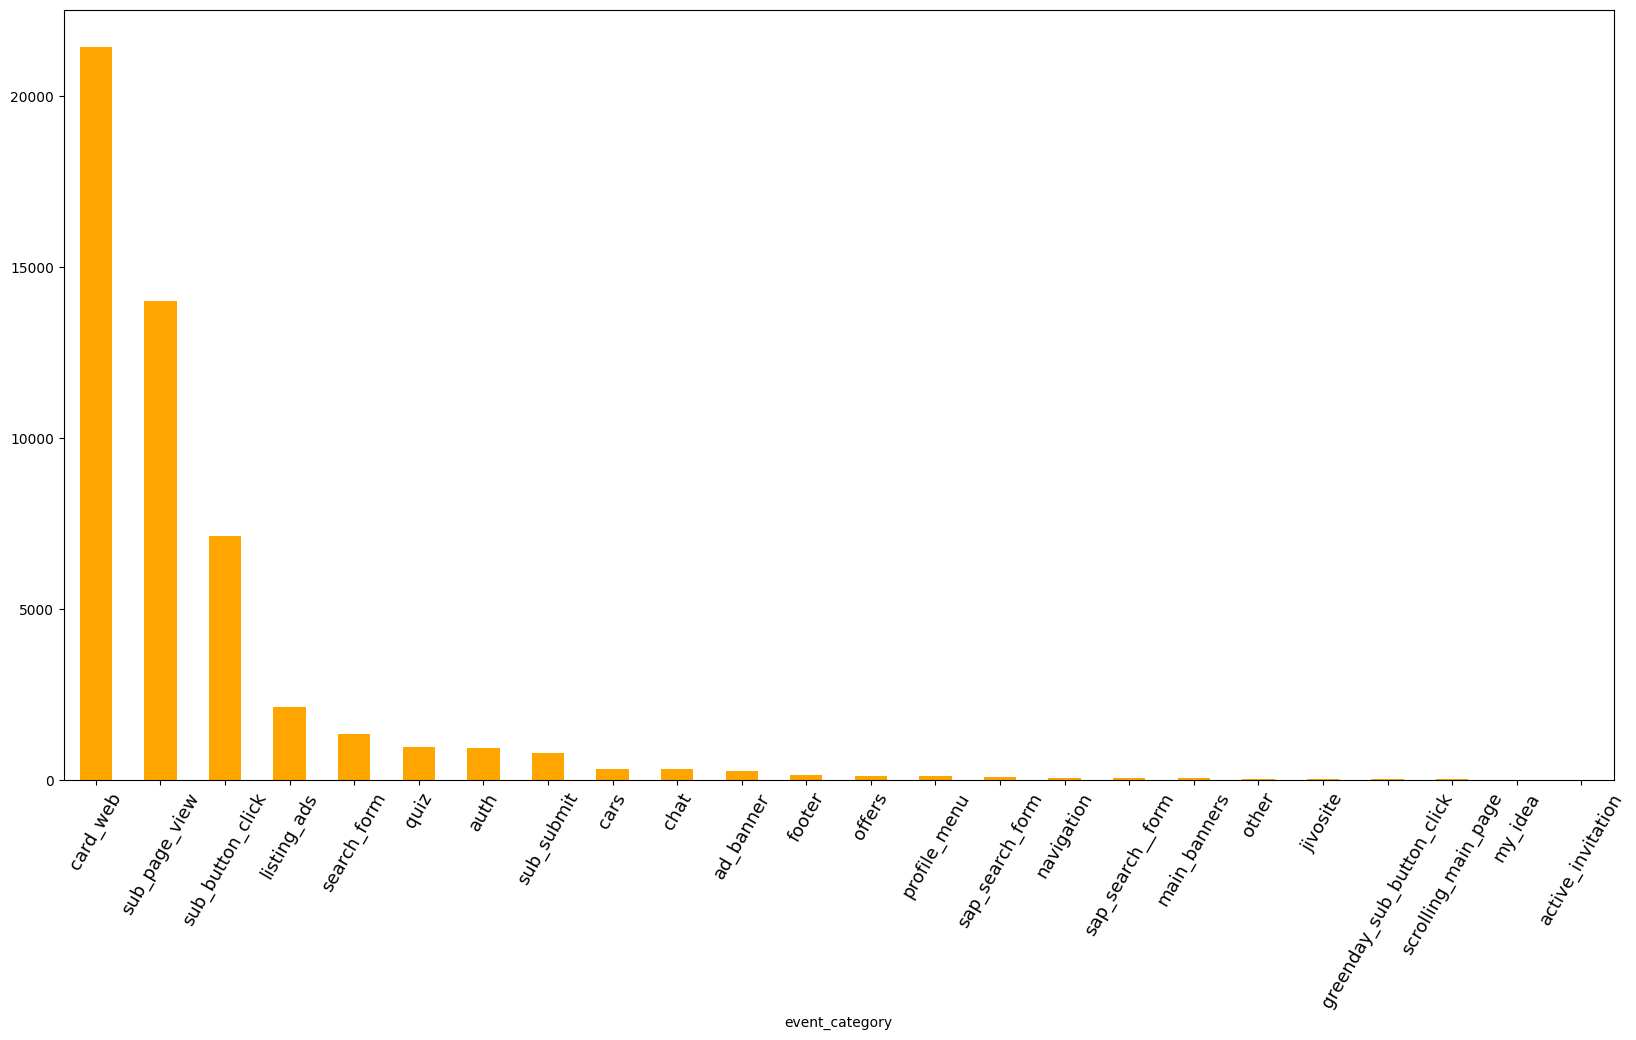

In [358]:
##Объем трафика (целевые действия)
fig, ax = plt.subplots(figsize=(20, 10))
grouped = df_full_copy.groupby('event_category')['target_col'].sum()
grouped = grouped.sort_values(ascending=False)
grouped.plot(kind='bar', color = 'orange')
plt.xticks(rotation=60, size=13)
plt.show()

In [356]:
## Трафик
grouped.sort_values(ascending=False)

event_category
card_web                     21455
sub_page_view                14005
sub_button_click              7130
listing_ads                   2127
search_form                   1347
quiz                           953
auth                           941
sub_submit                     784
cars                           309
chat                           305
ad_banner                      252
footer                         139
offers                         109
profile_menu                    98
sap_search_form                 86
navigation                      63
sap_search__form                57
main_banners                    53
other                           35
jivosite                        30
greenday_sub_button_click       13
scrolling_main_page             12
my_idea                          9
active_invitation                2
Name: target_col, dtype: int64

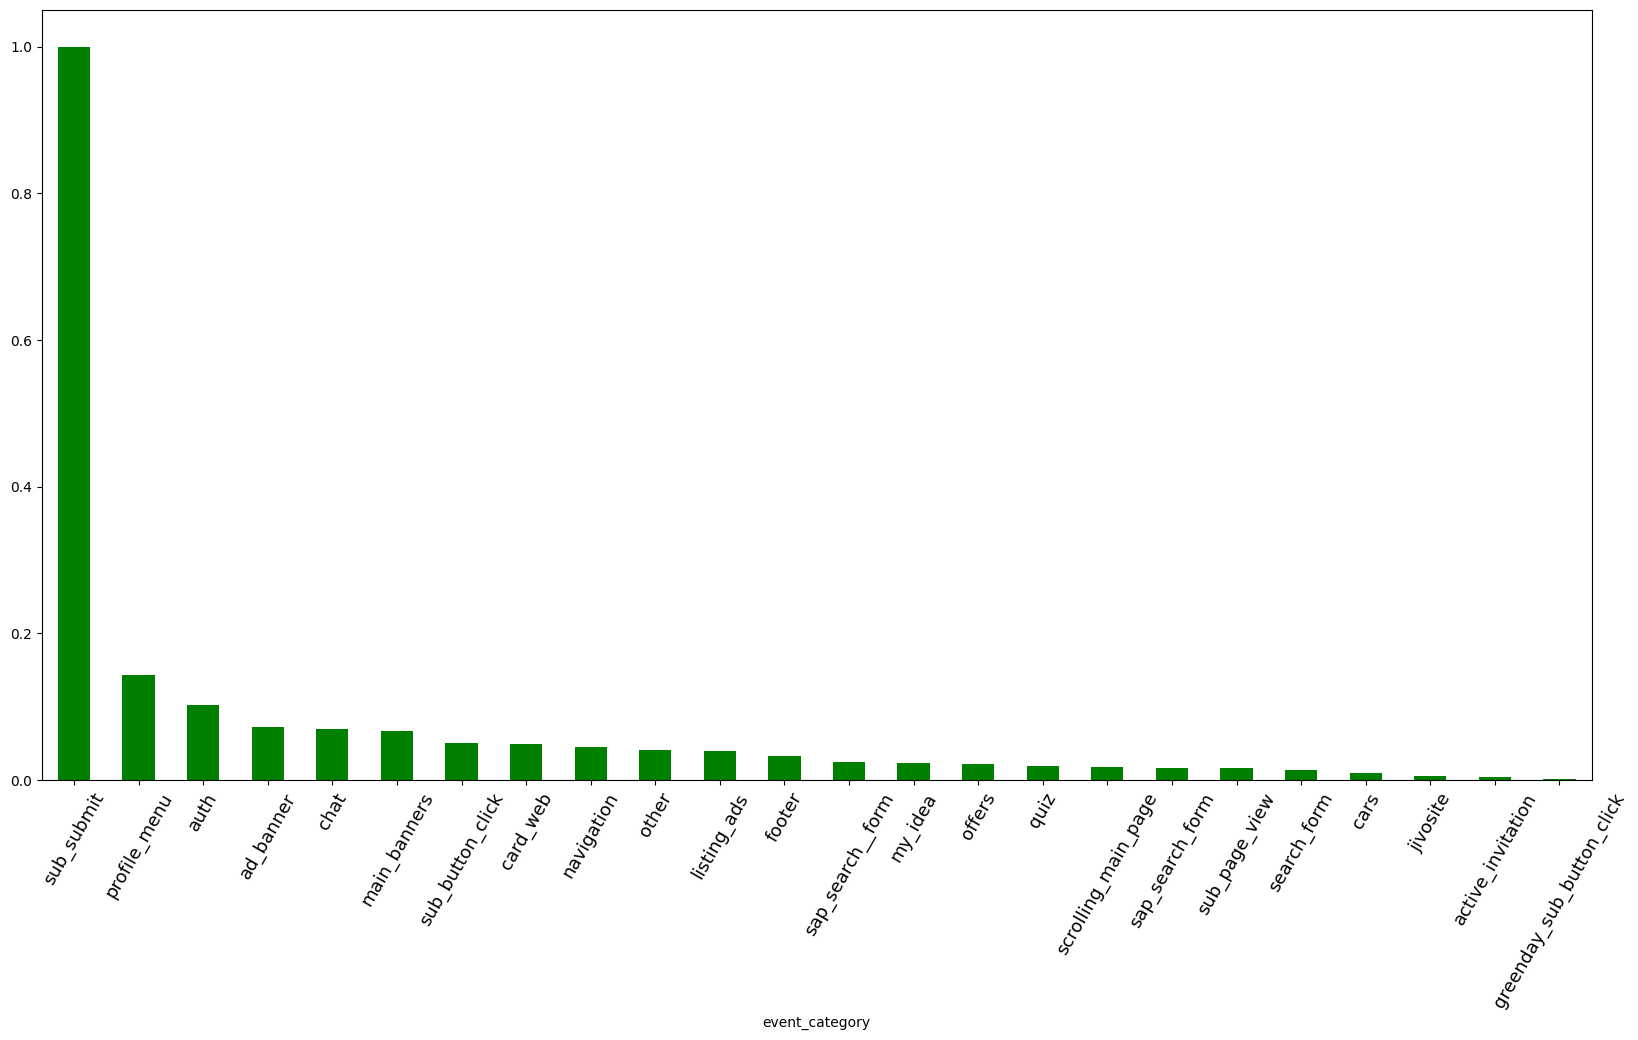

In [359]:
## Конверсия в целевое действие CR
fig, ax = plt.subplots(figsize=(20, 10))
grouped = df_full_copy.groupby('event_category')['target_col'].mean()
grouped = grouped.sort_values(ascending=False)
grouped.plot(kind='bar', color = 'green')
plt.xticks(rotation=60, size=13)
plt.show()

In [273]:
grouped.sort_values(ascending=False)

event_category
sub_submit                   1.000000
profile_menu                 0.142857
auth                         0.101554
ad_banner                    0.071429
chat                         0.069667
main_banners                 0.066085
sub_button_click             0.049766
card_web                     0.049368
navigation                   0.044335
other                        0.040230
listing_ads                  0.038840
footer                       0.032768
sap_search__form             0.024224
my_idea                      0.022388
offers                       0.022025
quiz                         0.019068
scrolling_main_page          0.017570
sap_search_form              0.016689
sub_page_view                0.016234
search_form                  0.013393
cars                         0.009694
jivosite                     0.005242
active_invitation            0.003390
greenday_sub_button_click    0.001496
Name: target_col, dtype: float64

#### device_brand  -  устройство

In [519]:
df_full_copy = df_full.copy()

In [520]:
df_full_copy.device_brand.value_counts()

device_brand
Apple        503533
other        363588
Samsung      311641
Xiaomi       269251
Huawei       173828
              ...  
Smarteo           1
Star              1
Mobiistar         1
Fero              1
Maxvi             1
Name: count, Length: 200, dtype: int64

In [521]:
counts = df_full_copy.device_brand.value_counts()
df_full_copy['device_brand'] = df_full_copy['device_brand'].apply(lambda x: 'other' if counts[x] < 300 else x)

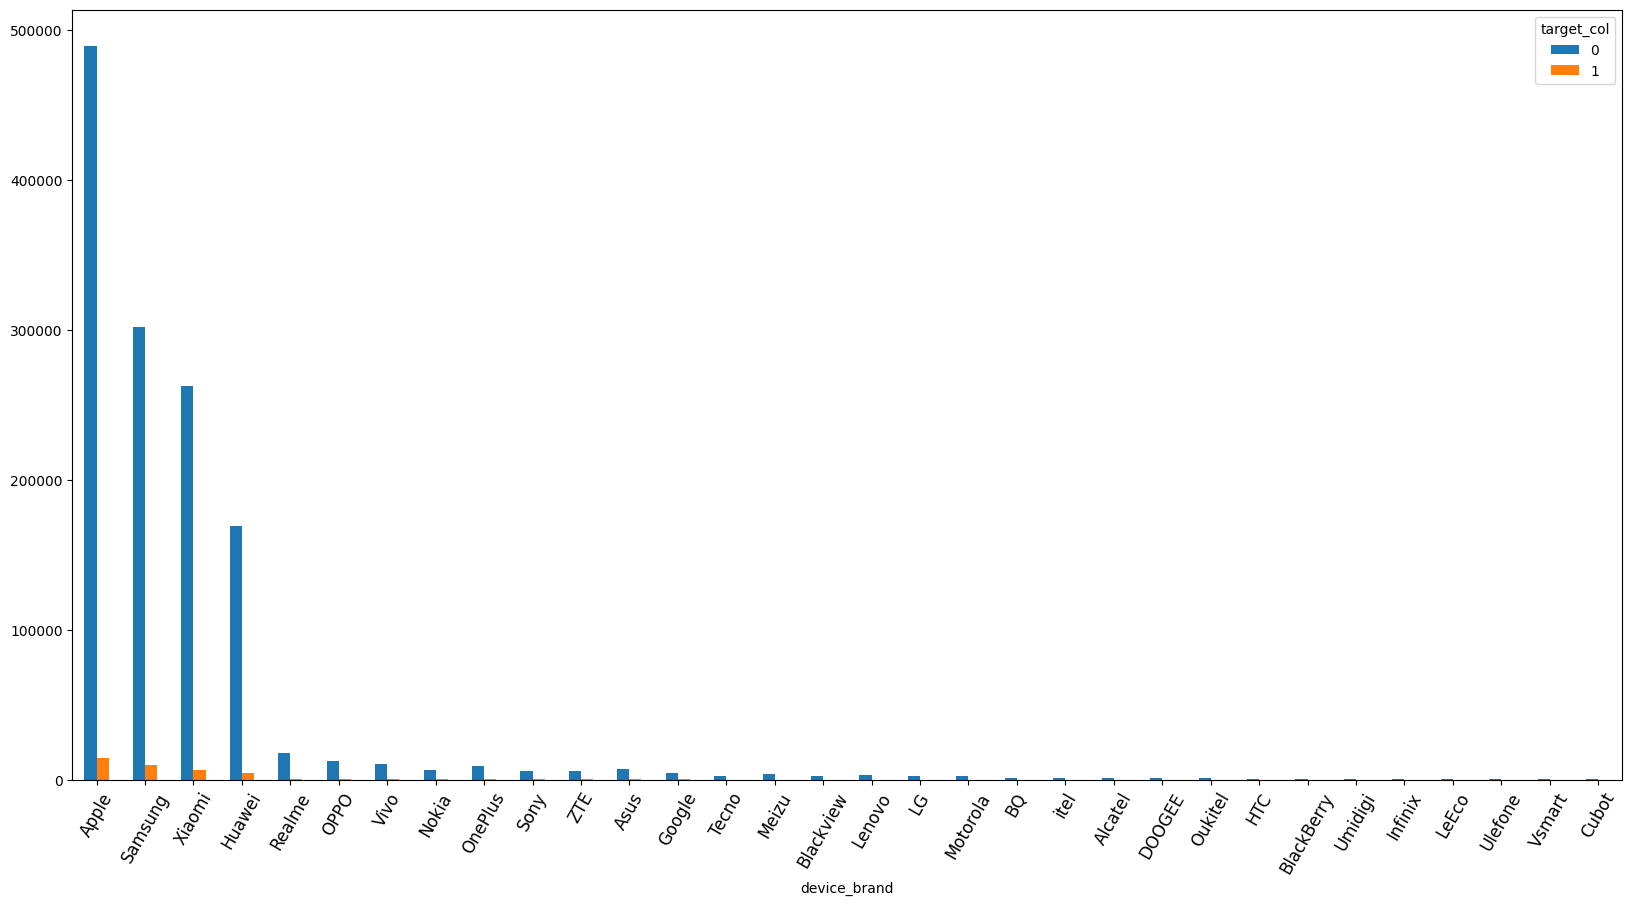

In [523]:
df_filtered = df_full_copy[df_full_copy['device_brand'] != 'other']
fig, ax = plt.subplots(figsize=(20, 10))
df_filtered.groupby(['device_brand', 'target_col']).size().unstack().sort_values(by=1, ascending=False).plot(kind='bar', ax=ax)
plt.xticks(rotation=60, size=12)
plt.show()

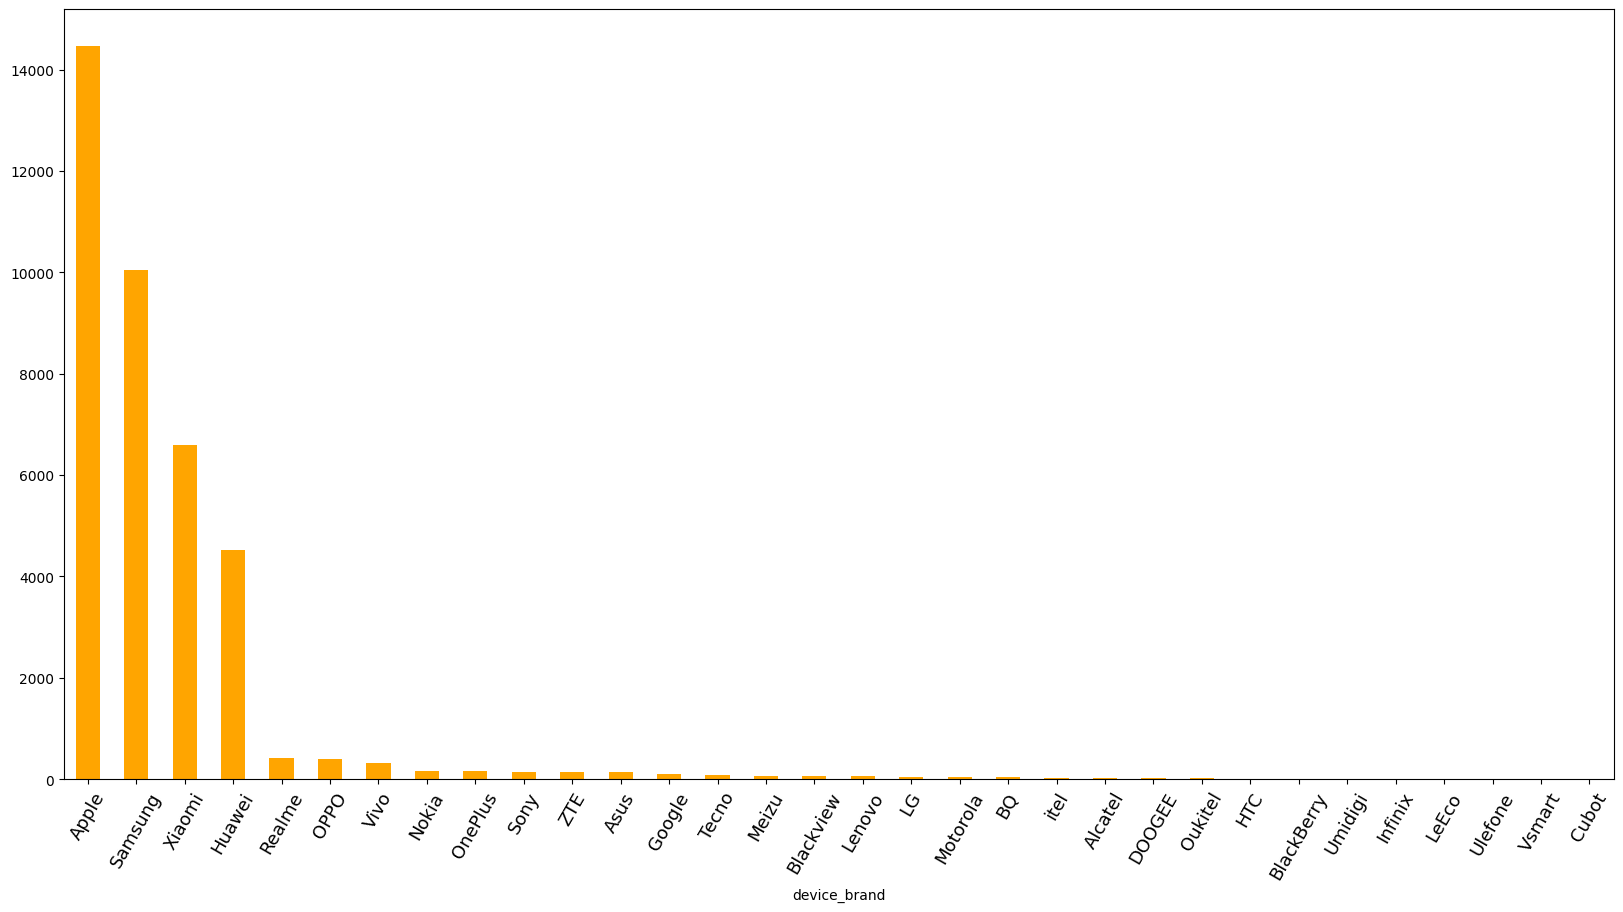

In [524]:
##Объем трафика (целевые действия)
fig, ax = plt.subplots(figsize=(20, 10))
grouped = df_filtered.groupby('device_brand')['target_col'].sum()
grouped = grouped.sort_values(ascending=False)
grouped.plot(kind='bar', color = 'orange')
plt.xticks(rotation=60, size=13)
plt.show()

In [525]:
##Самые пополярные устройства с точки зрения целеыого трафика
grouped.sort_values(ascending=False).head()

device_brand
Apple      14467
Samsung    10054
Xiaomi      6592
Huawei      4519
Realme       421
Name: target_col, dtype: int64

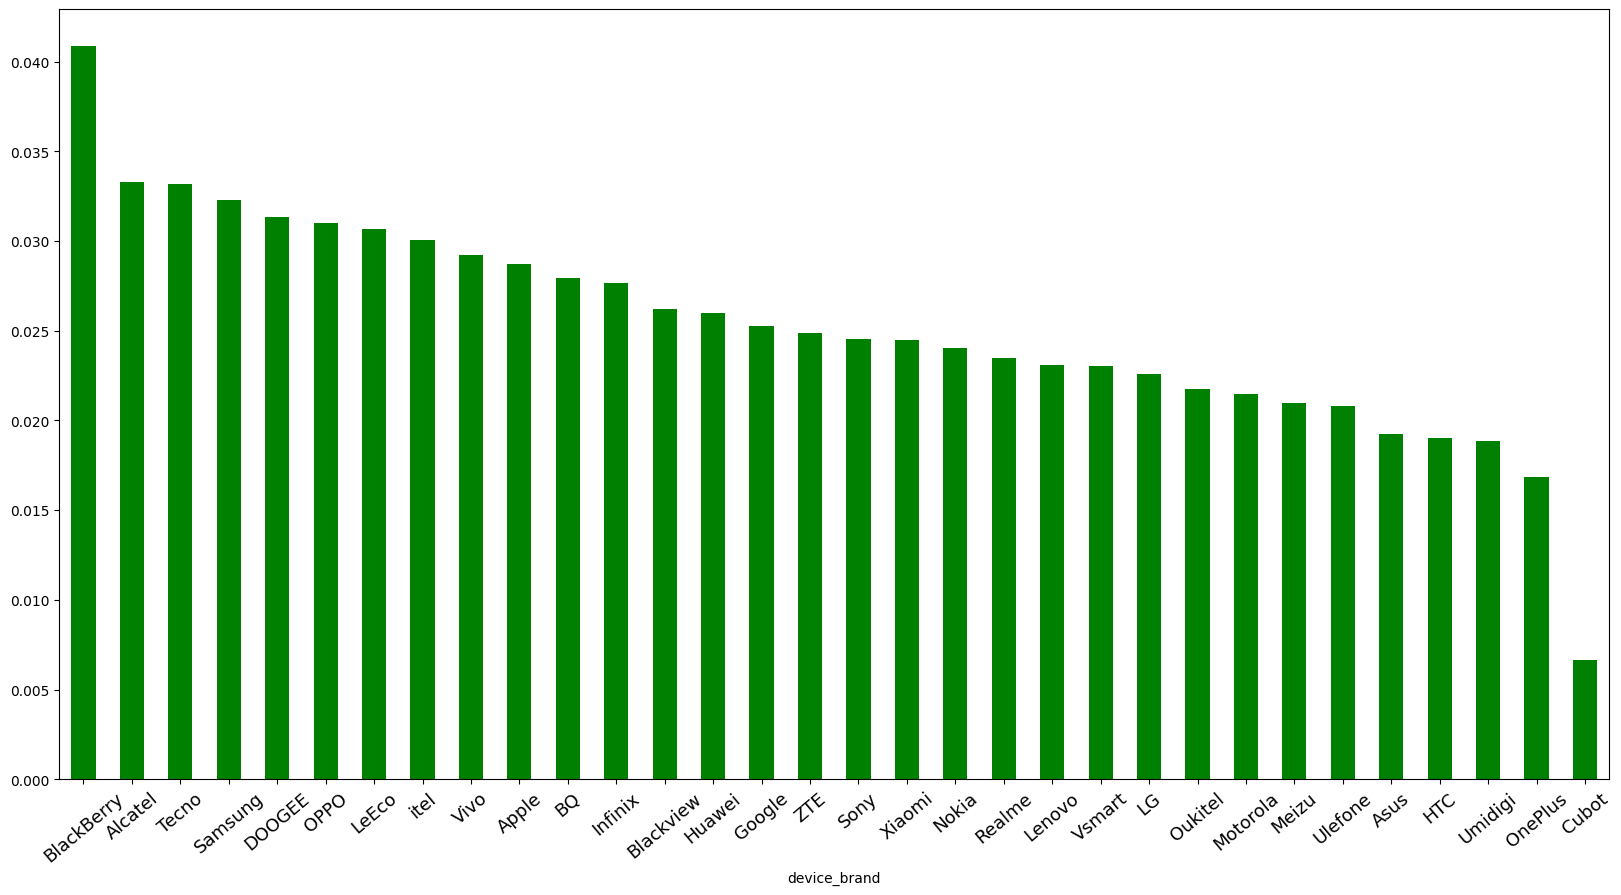

In [526]:
## Конверсия в целевое действие CR
fig, ax = plt.subplots(figsize=(20, 10))
grouped = df_filtered.groupby('device_brand')['target_col'].mean()
grouped = grouped.sort_values(ascending=False)
grouped.plot(kind='bar', color = 'green')
plt.xticks(rotation=40, size=13)
plt.show()

In [528]:
##CR
grouped.sort_values(ascending=False)

device_brand
BlackBerry    0.040881
Alcatel       0.033296
Tecno         0.033187
Samsung       0.032261
DOOGEE        0.031325
OPPO          0.030998
LeEco         0.030675
itel          0.030068
Vivo          0.029204
Apple         0.028731
BQ            0.027967
Infinix       0.027638
Blackview     0.026235
Huawei        0.025997
Google        0.025268
ZTE           0.024887
Sony          0.024566
Xiaomi        0.024483
Nokia         0.024038
Realme        0.023485
Lenovo        0.023114
Vsmart        0.023055
LG            0.022606
Oukitel       0.021767
Motorola      0.021471
Meizu         0.020969
Ulefone       0.020790
Asus          0.019233
HTC           0.019048
Umidigi       0.018868
OnePlus       0.016842
Cubot         0.006645
Name: target_col, dtype: float64

#### car_name - марка автомобиля

In [340]:
df_full_copy = df_full.copy()

In [341]:
df_full_copy.car_name.value_counts()

car_name
other            1496350
skoda              49239
mercedes-benz      32110
nissan             29718
lada-vaz           27333
volkswagen         24580
kia                13390
renault            12178
bmw                11752
toyota              8711
lexus               5421
porsche             5005
audi                3605
volvo               3236
haval               2892
mini                2181
peugeot             1588
land-rover          1450
hyundai             1396
chevrolet             25
mitsubishi            24
honda                 23
mazda                 20
ford                  15
chery                 13
infiniti               7
jeep                   3
ravon                  1
Name: count, dtype: int64

In [342]:
counts = df_full_copy.car_name.value_counts()
df_full_copy['car_name'] = df_full_copy['car_name'].apply(lambda x: 'other' if counts[x] < 100 else x)

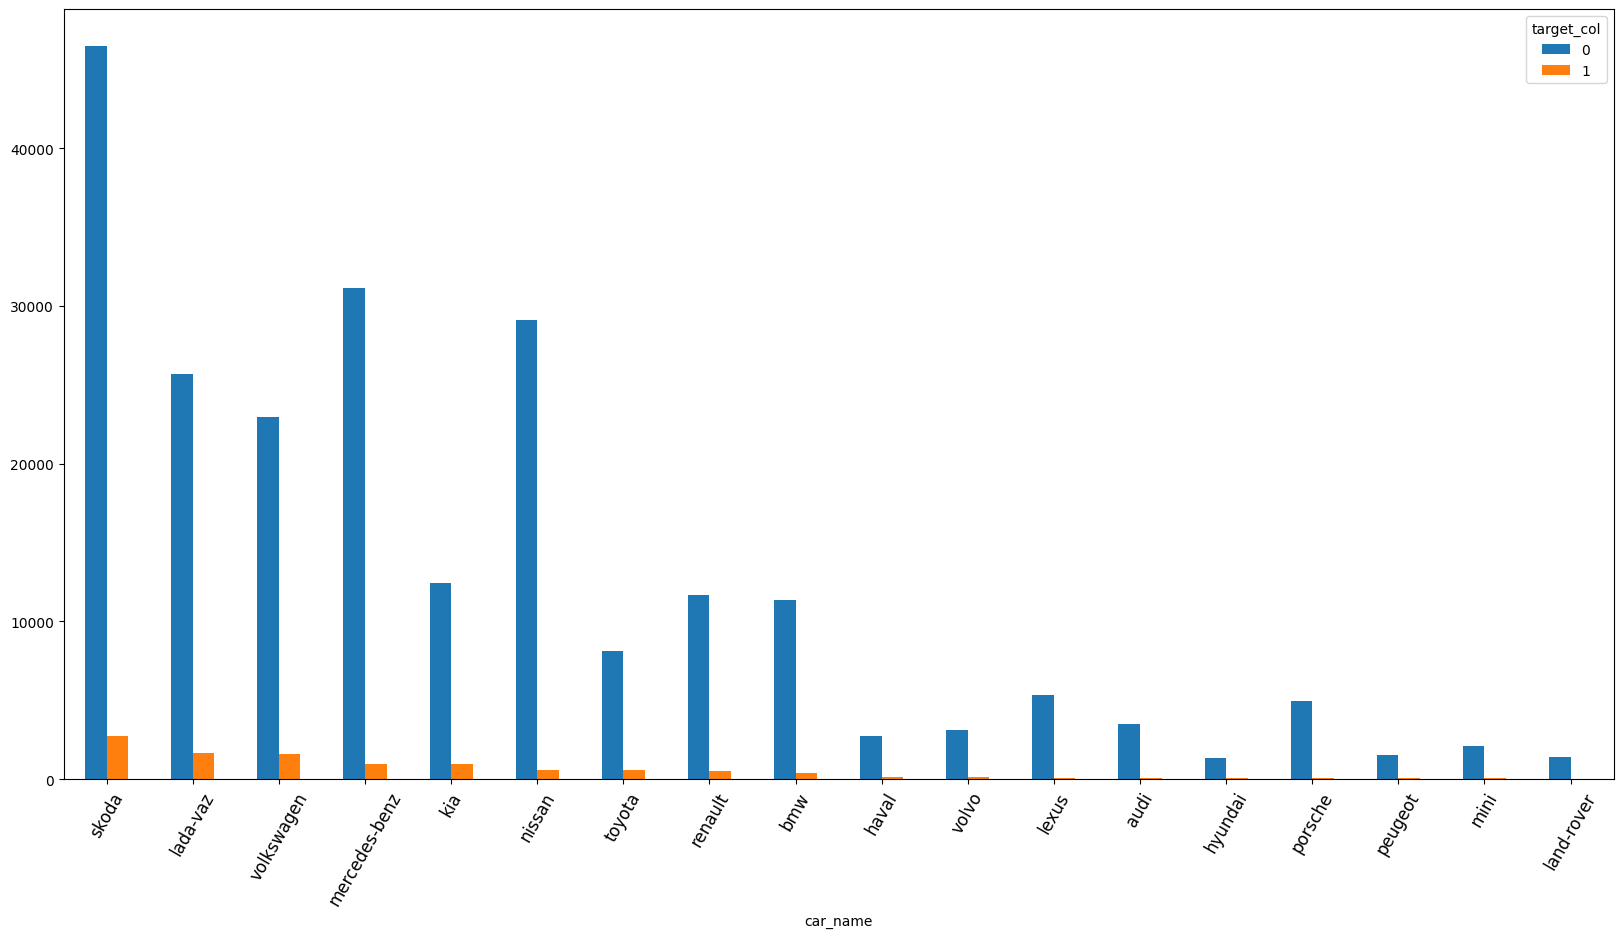

In [343]:
df_filtered = df_full_copy[df_full_copy['car_name'] != 'other']
fig, ax = plt.subplots(figsize=(20, 10))
df_filtered.groupby(['car_name', 'target_col']).size().unstack().sort_values(by=1, ascending=False).plot(kind='bar', ax=ax)
plt.xticks(rotation=60, size=12)
plt.show()

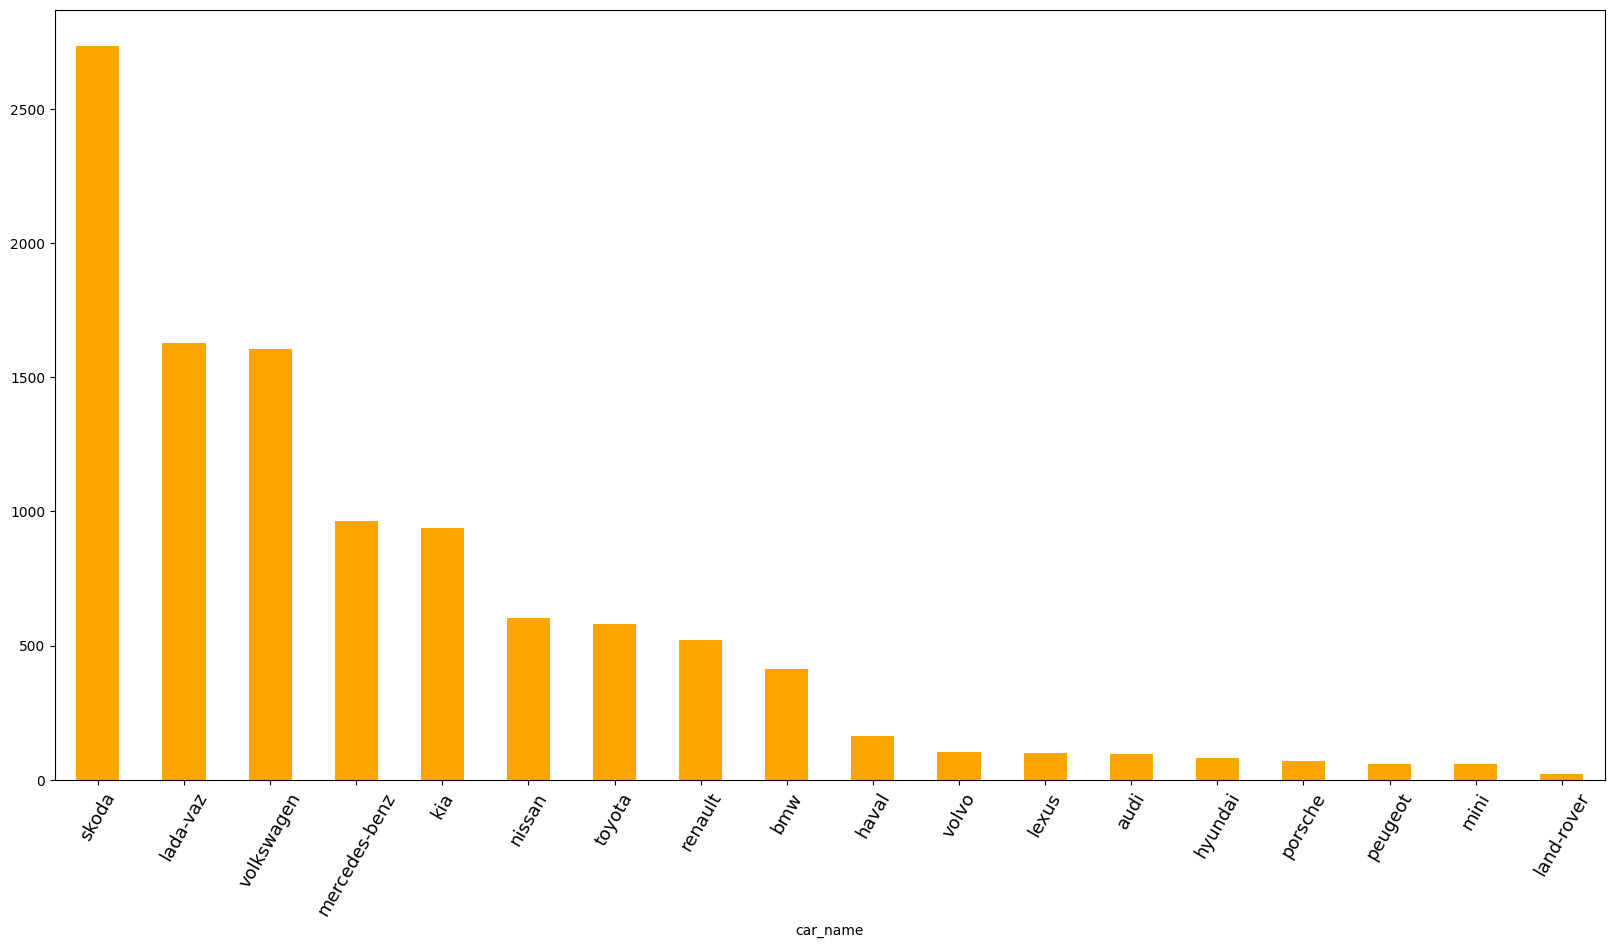

In [344]:
##Объем трафика (целевые действия)
fig, ax = plt.subplots(figsize=(20, 10))
grouped = df_filtered.groupby('car_name')['target_col'].sum()
grouped = grouped.sort_values(ascending=False)
grouped.plot(kind='bar', color = 'orange')
plt.xticks(rotation=60, size=13)
plt.show()

In [345]:
## Самые популярные автомобили с точки зрения цeлевого трафика
grouped.sort_values(ascending=False)

car_name
skoda            2733
lada-vaz         1626
volkswagen       1604
mercedes-benz     966
kia               939
nissan            602
toyota            580
renault           522
bmw               414
haval             164
volvo             105
lexus              98
audi               97
hyundai            81
porsche            70
peugeot            60
mini               59
land-rover         22
Name: target_col, dtype: int64

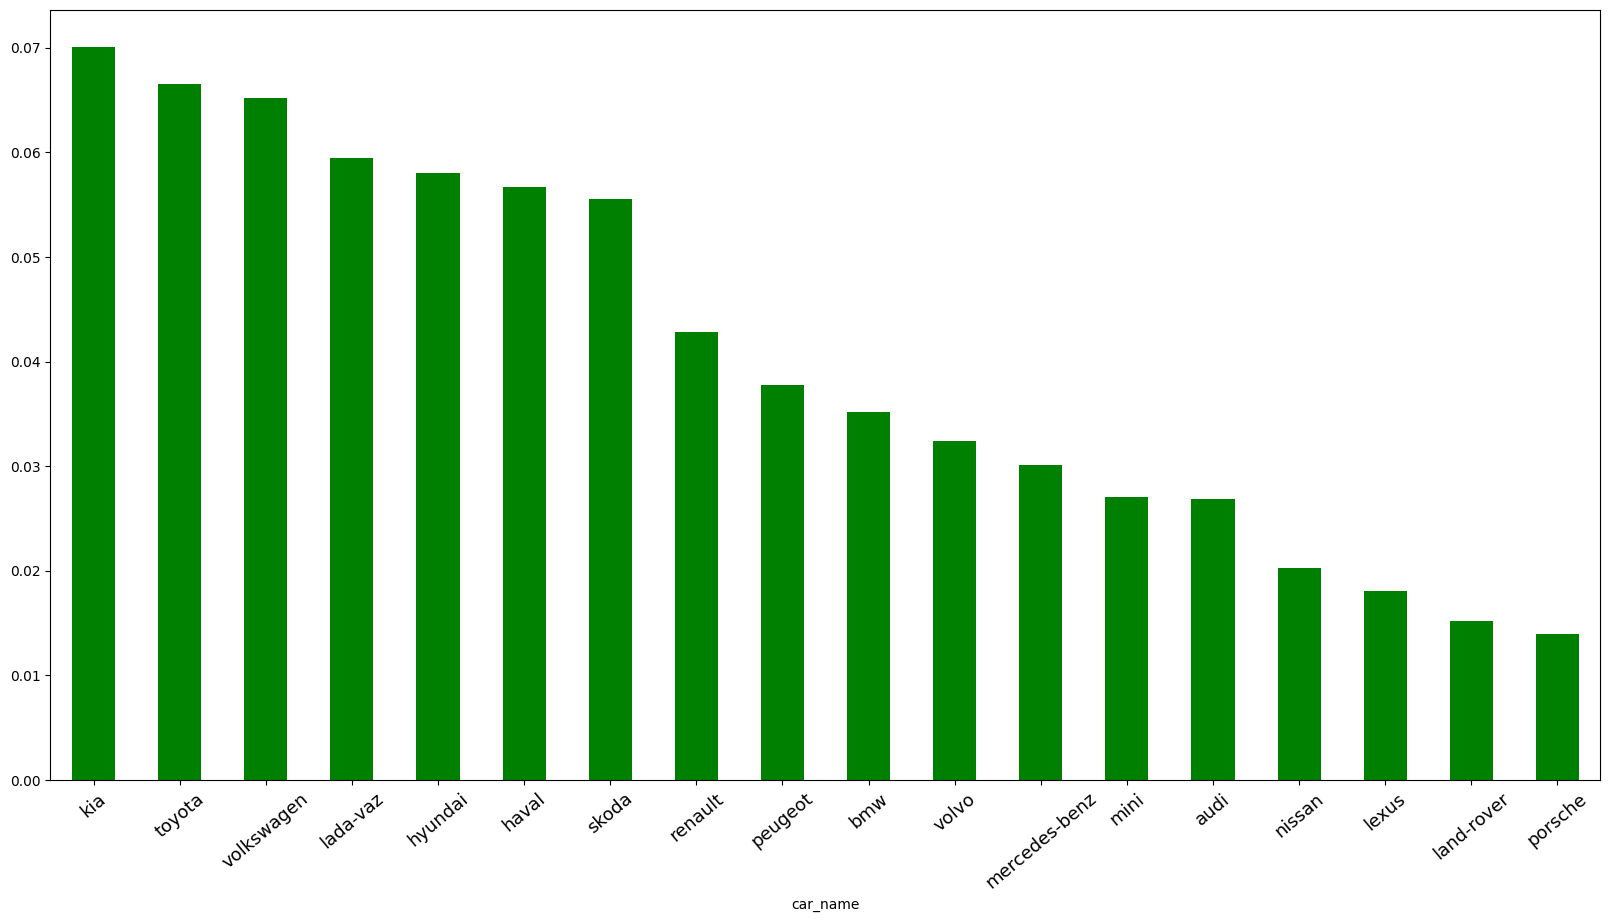

In [289]:
## Конверсия в целевое действие CR
fig, ax = plt.subplots(figsize=(20, 10))
grouped = df_filtered.groupby('car_name')['target_col'].mean()
grouped = grouped.sort_values(ascending=False)
grouped.plot(kind='bar', color = 'green')
plt.xticks(rotation=40, size=13)
plt.show()

In [290]:
## Самые популярные автомобили с точки зрения CR
grouped.sort_values(ascending=False)

car_name
kia              0.070127
toyota           0.066582
volkswagen       0.065256
lada-vaz         0.059489
hyundai          0.058023
haval            0.056708
skoda            0.055505
renault          0.042864
peugeot          0.037783
bmw              0.035228
volvo            0.032447
mercedes-benz    0.030084
mini             0.027052
audi             0.026907
nissan           0.020257
lexus            0.018078
land-rover       0.015172
porsche          0.013986
Name: target_col, dtype: float64

#### geo_region - локация

In [504]:
df_full_copy = df_full.copy()

In [505]:
df_full_copy.geo_region.value_counts()

geo_region
Москва                          750928
Санкт Петербург                 278402
Московская область              100300
other                            73297
Краснодарский край               42378
                                 ...  
Περιφερειακή Ενότητα Ευβοίας         1
Mažeikių rajono savivaldybė          1
Pulau Pinang                         1
Жмеринський район                    1
中部地方                                 1
Name: count, Length: 957, dtype: int64

In [506]:
counts = df_full_copy.geo_region.value_counts()
df_full_copy['geo_region'] = df_full_copy['geo_region'].replace('Other', 'other')
df_full_copy['geo_region'] = df_full_copy['geo_region'].apply(lambda x: 'other' if counts[x] < 4000 else x)

In [507]:
df_full_copy.geo_region.value_counts()

geo_region
Москва                     750928
Санкт Петербург            278402
other                      220273
Московская область         100300
Краснодарский край          42378
Свердловская область        36199
Республика Татарстан        29805
Самарская область           25216
Нижегородская область       21785
Башкортостан                20762
Новосибирская область       20115
Красноярский край           16681
Челябинская область         16209
Тульская область            15266
Ростовская область          13862
Иркутская область           13604
Воронежская область         12701
Приморский край             12022
Чеченская Республика        12003
Ярославская область          9493
Калининградская область      8213
Ставропольский край          8183
Тюменская область            7898
Саратовская область          6840
Пермский край                6163
Удмуртская Республика        4952
Калужская область            4774
Волгоградская область        4462
Кемеровская область          4361
Лип

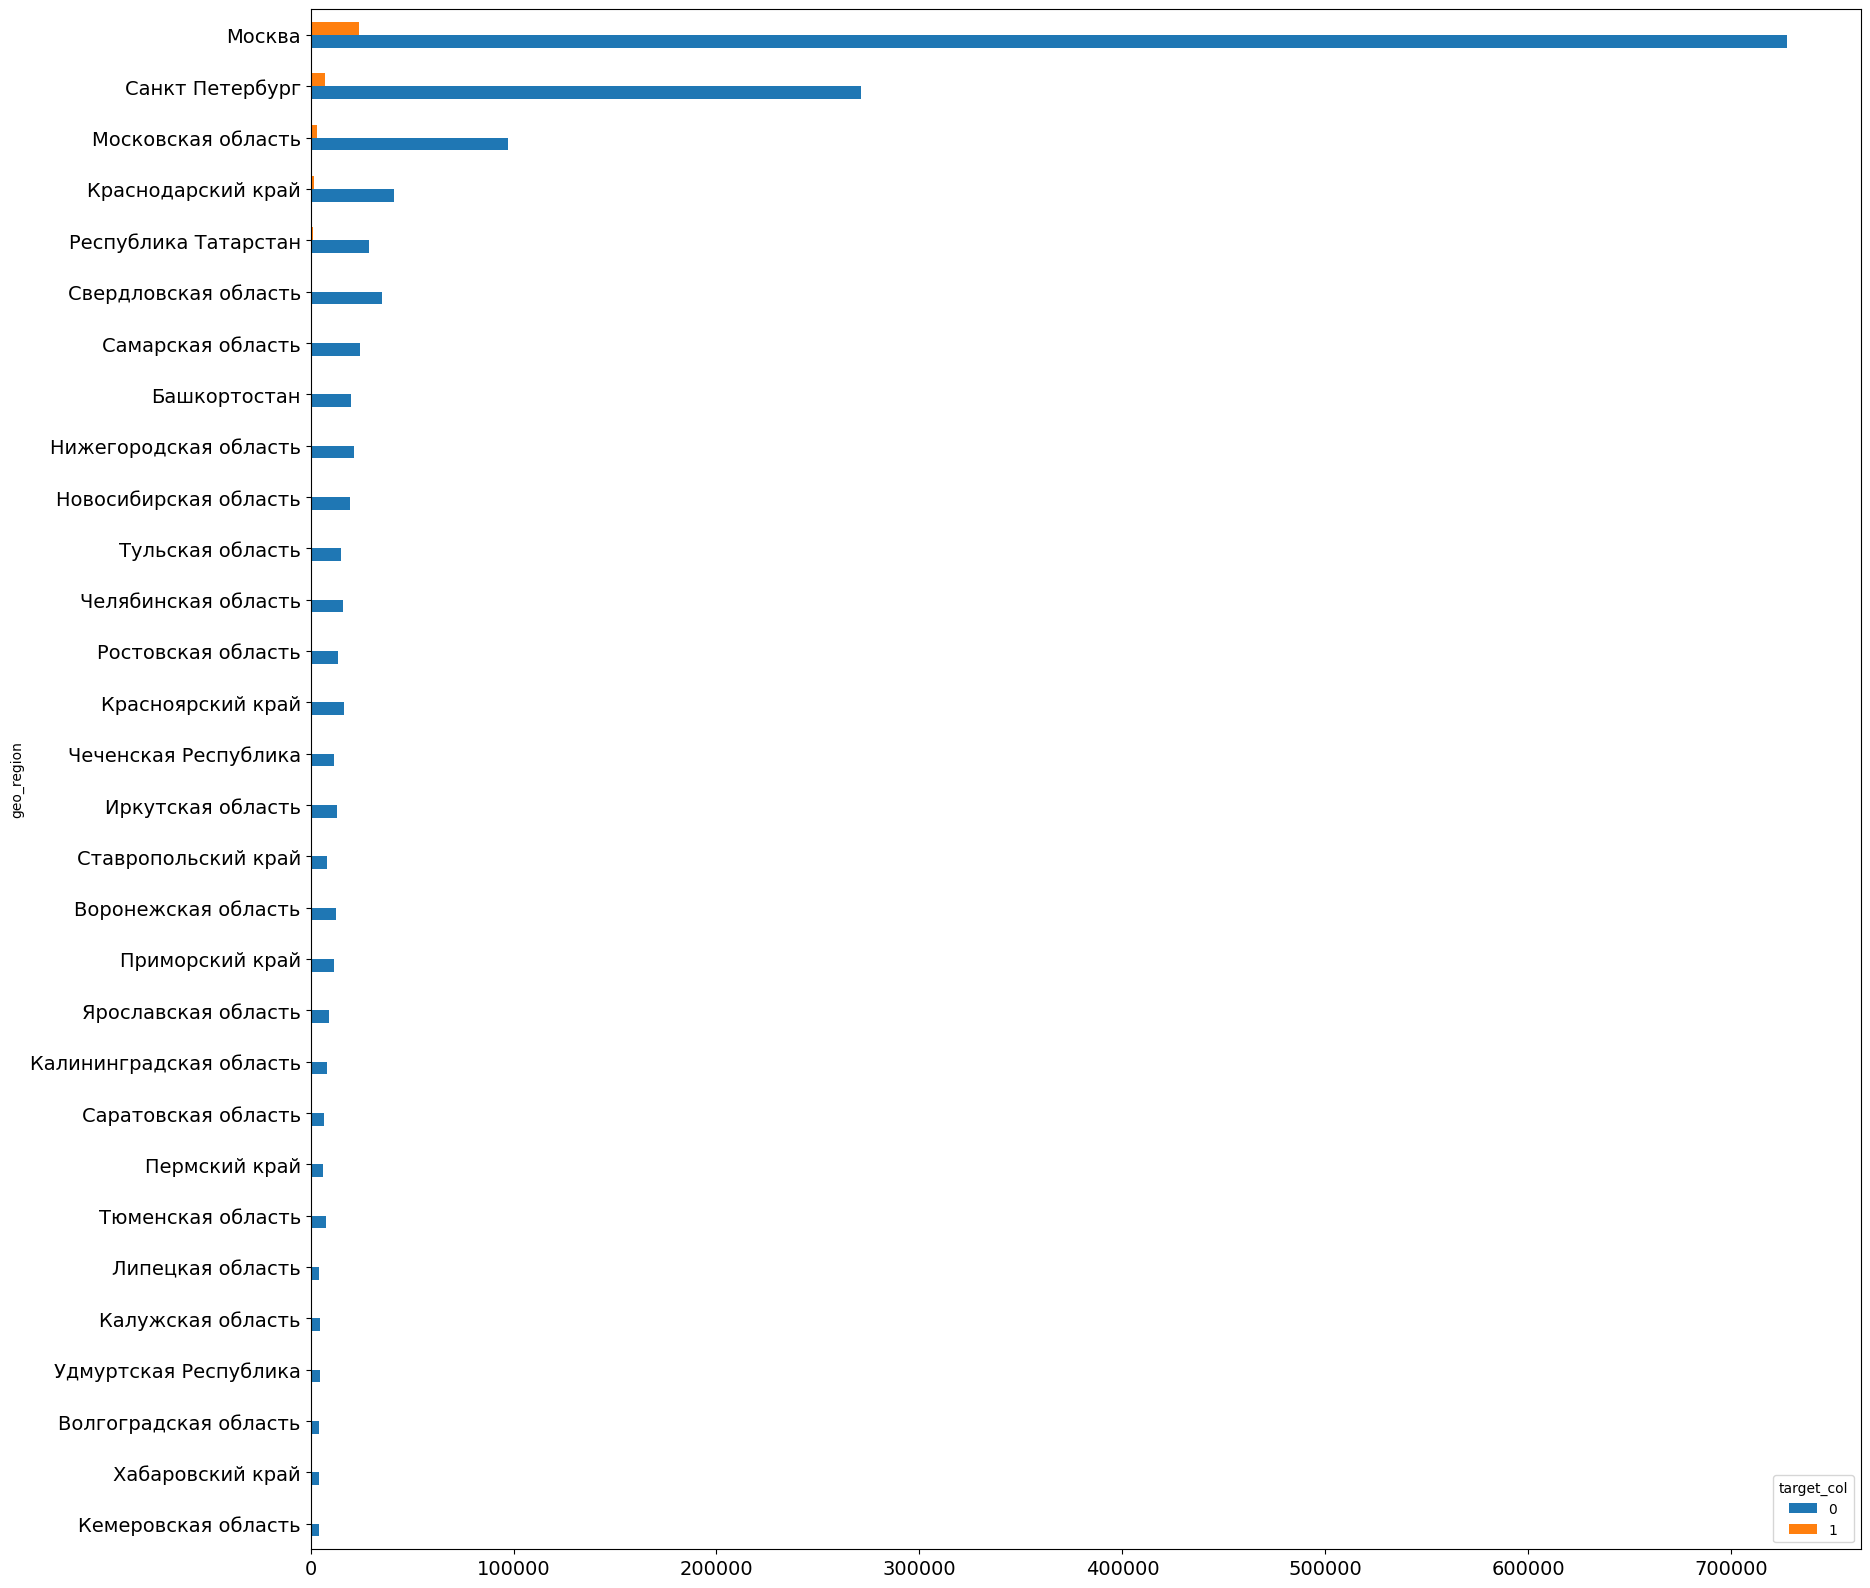

In [508]:
df_filtered = df_full_copy[df_full_copy['geo_region'] != 'other']
fig, ax = plt.subplots(figsize=(20, 20))
df_filtered.groupby(['geo_region', 'target_col']).size().unstack().sort_values(by=1).plot(kind='barh', ax=ax)
plt.yticks(size=14)
plt.xticks(size=14)
plt.show()

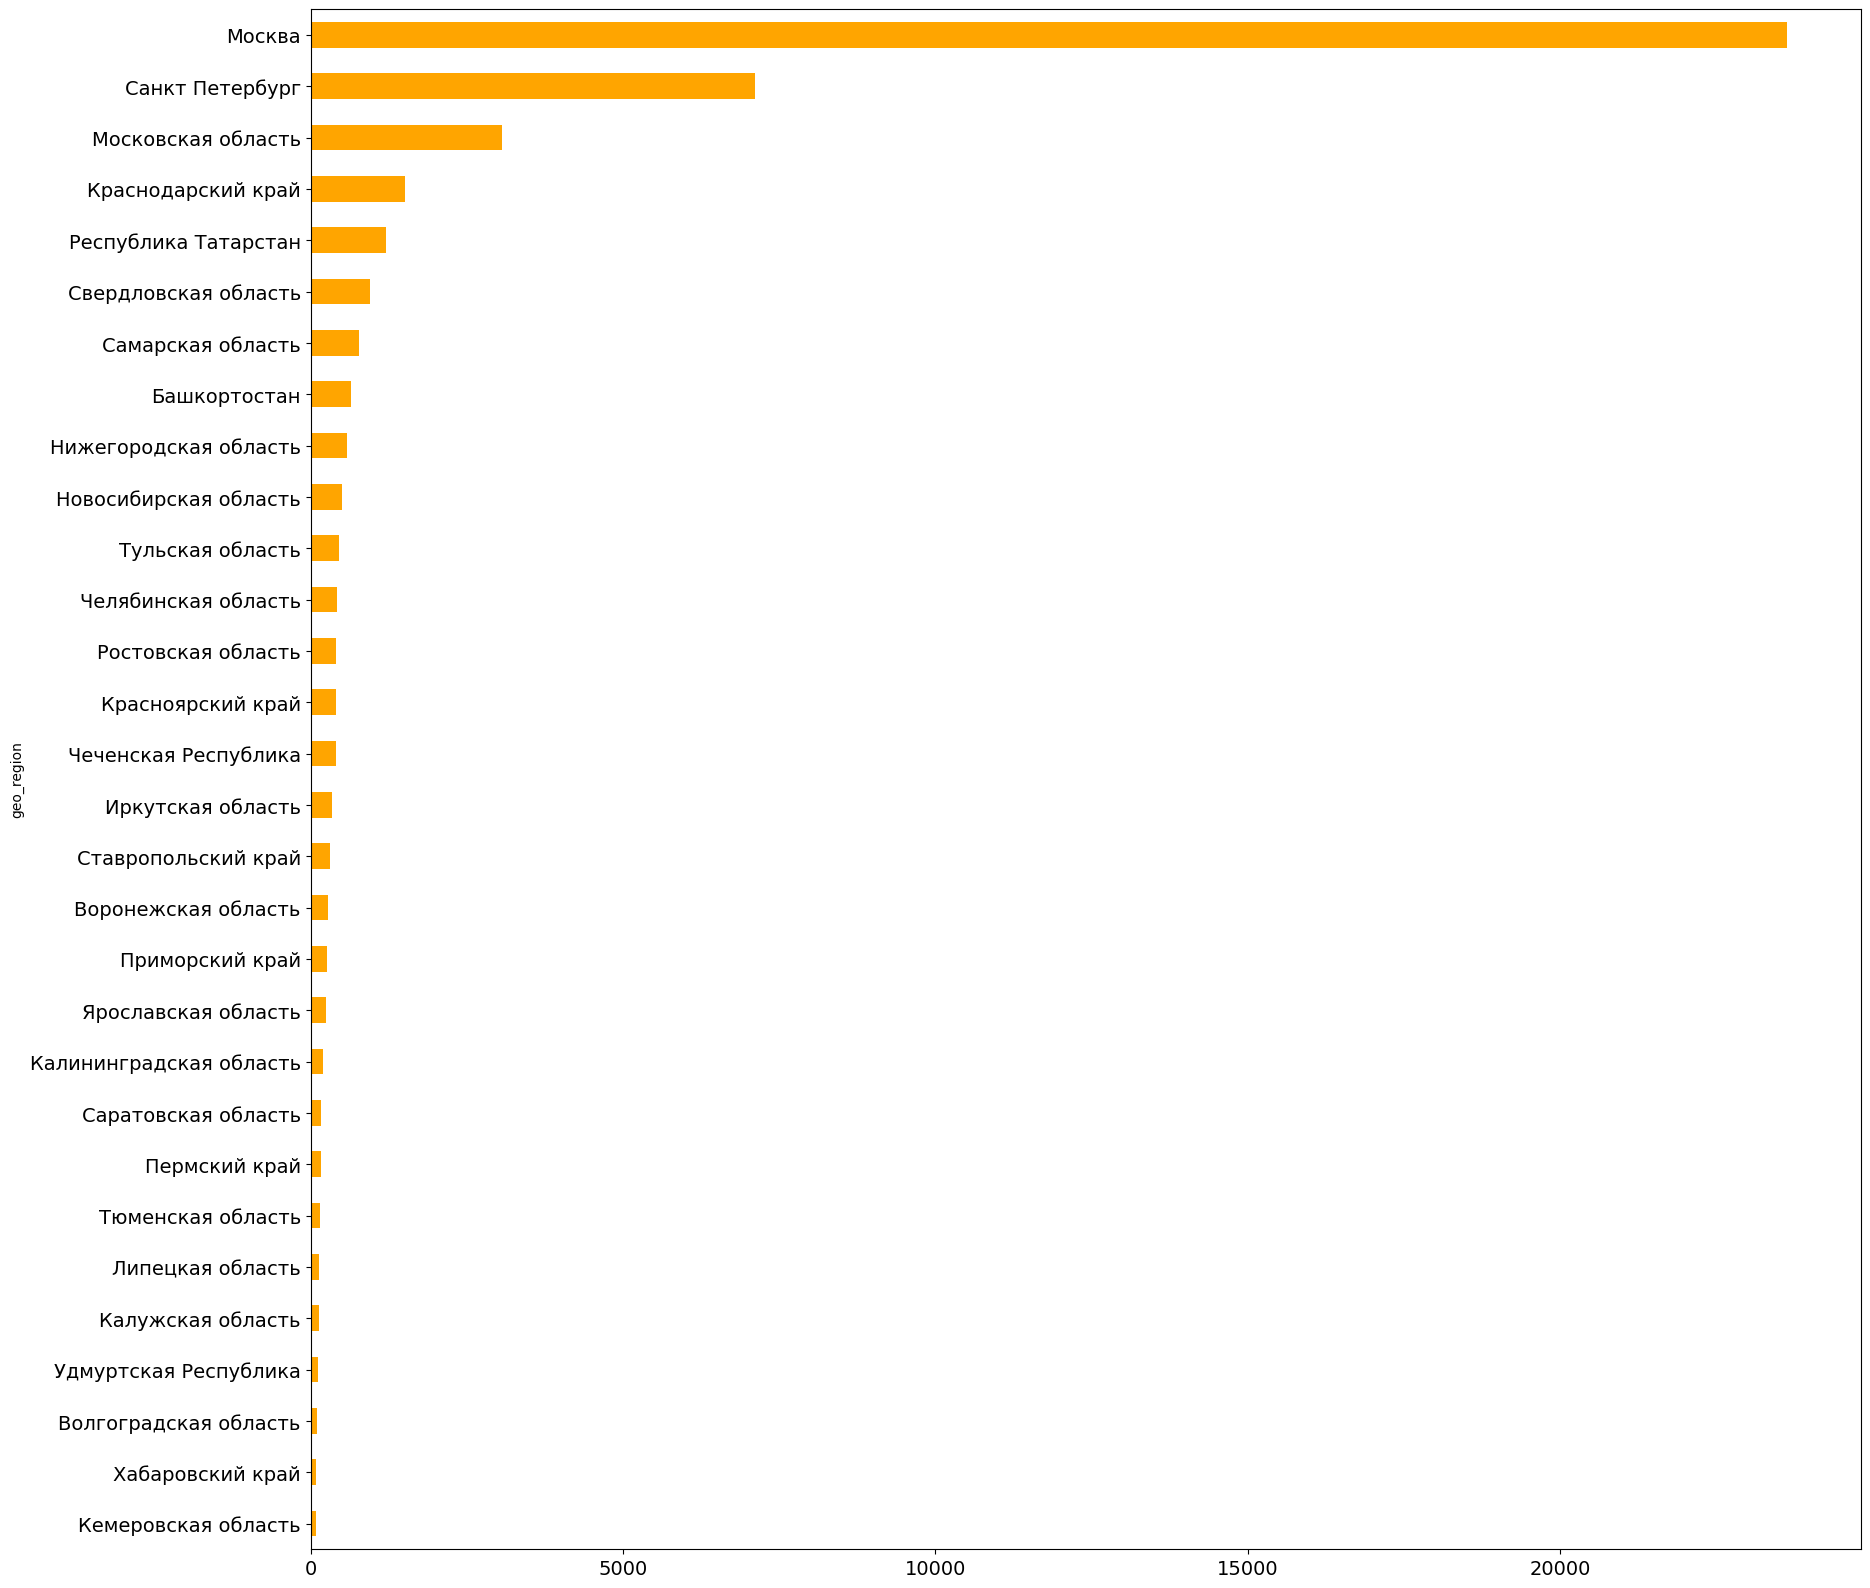

In [516]:
##Объем трафика (целевые действия)
fig, ax = plt.subplots(figsize=(20, 20))
grouped = df_filtered.groupby('geo_region')['target_col'].sum()
grouped = grouped.sort_values(ascending=True)
grouped.plot(kind='barh', color = 'orange')
plt.yticks(size=14)
plt.xticks(size=14)
plt.show()

In [517]:
##Топ 10 регионов с точки зрения трафика
grouped.sort_values(ascending=False).head(10)

geo_region
Москва                   23629
Санкт Петербург           7113
Московская область        3062
Краснодарский край        1505
Республика Татарстан      1214
Свердловская область       951
Самарская область          777
Башкортостан               650
Нижегородская область      582
Новосибирская область      509
Name: target_col, dtype: int64

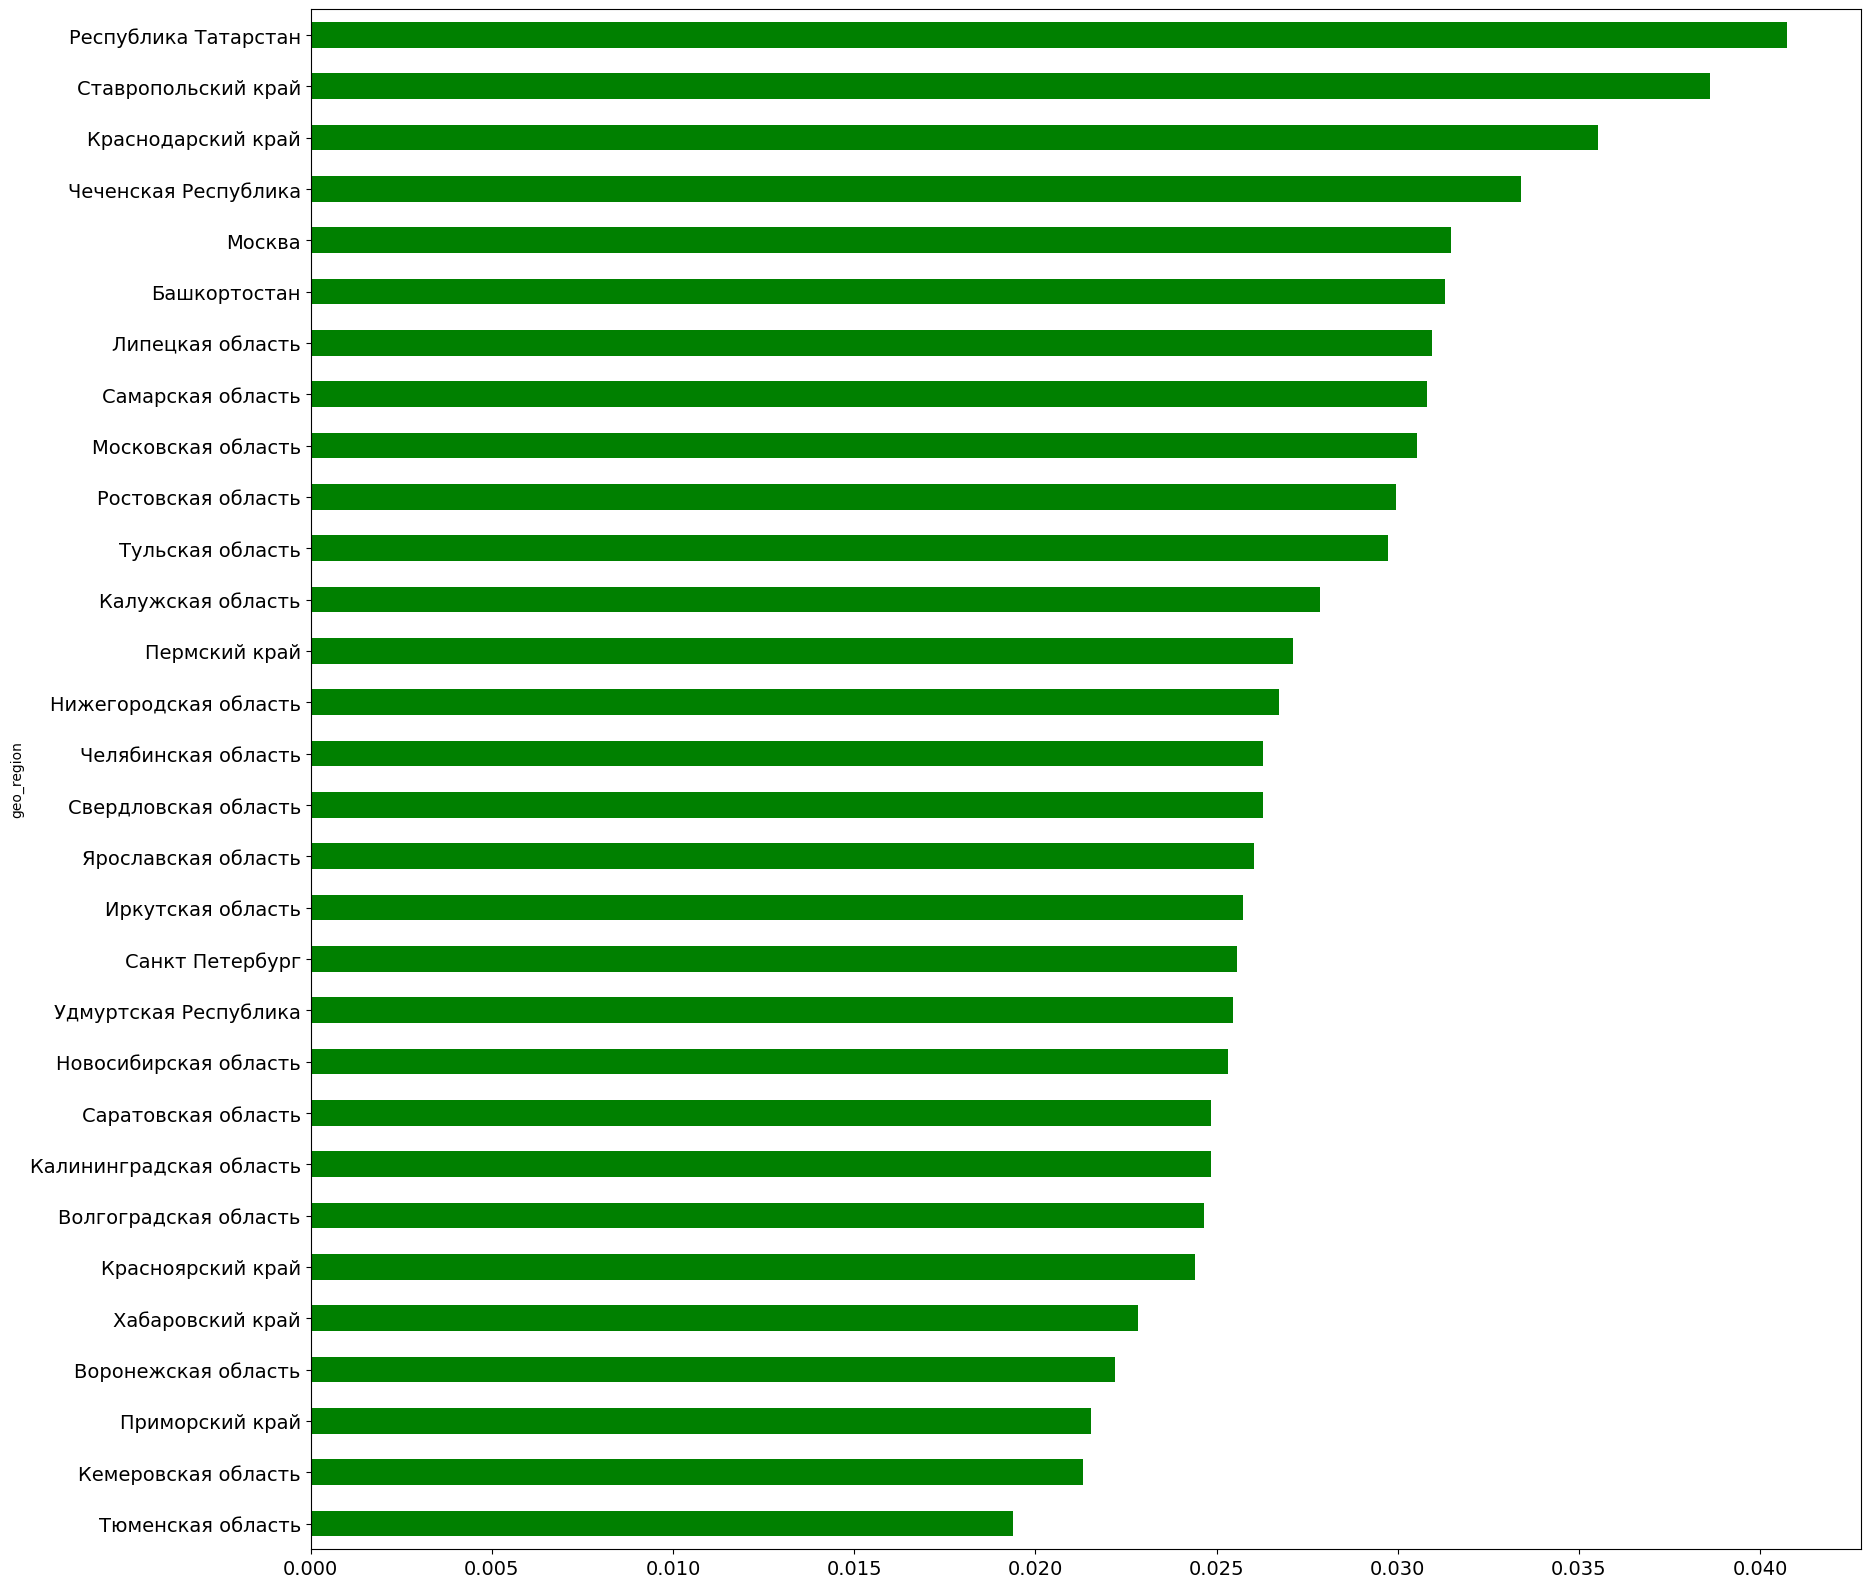

In [511]:
## Конверсия в целевое действие CR
fig, ax = plt.subplots(figsize=(20, 20))
grouped = df_filtered.groupby('geo_region')['target_col'].mean()
grouped = grouped.sort_values(ascending=True)
grouped.plot(kind='barh', color = 'green')
plt.yticks(size=14)
plt.xticks(size=14)
plt.show()

In [513]:
## топ 10 регионов с точки зрения СR
grouped.sort_values(ascending=False).head(10)

geo_region
Республика Татарстан    0.040731
Ставропольский край     0.038617
Краснодарский край      0.035514
Чеченская Республика    0.033408
Москва                  0.031466
Башкортостан            0.031307
Липецкая область        0.030930
Самарская область       0.030814
Московская область      0.030528
Ростовская область      0.029938
Name: target_col, dtype: float64

Самый высоки показатель CR у Республики Татарстан - 4%

#### device_OS - операционная система устройства

In [366]:
df_full_copy = df_full.copy()

In [369]:
counts = df_full_copy.device_os.value_counts()
df_full_copy['device_os'] = df_full_copy['device_os'].apply(lambda x: 'other' if counts[x] < 100 else x)

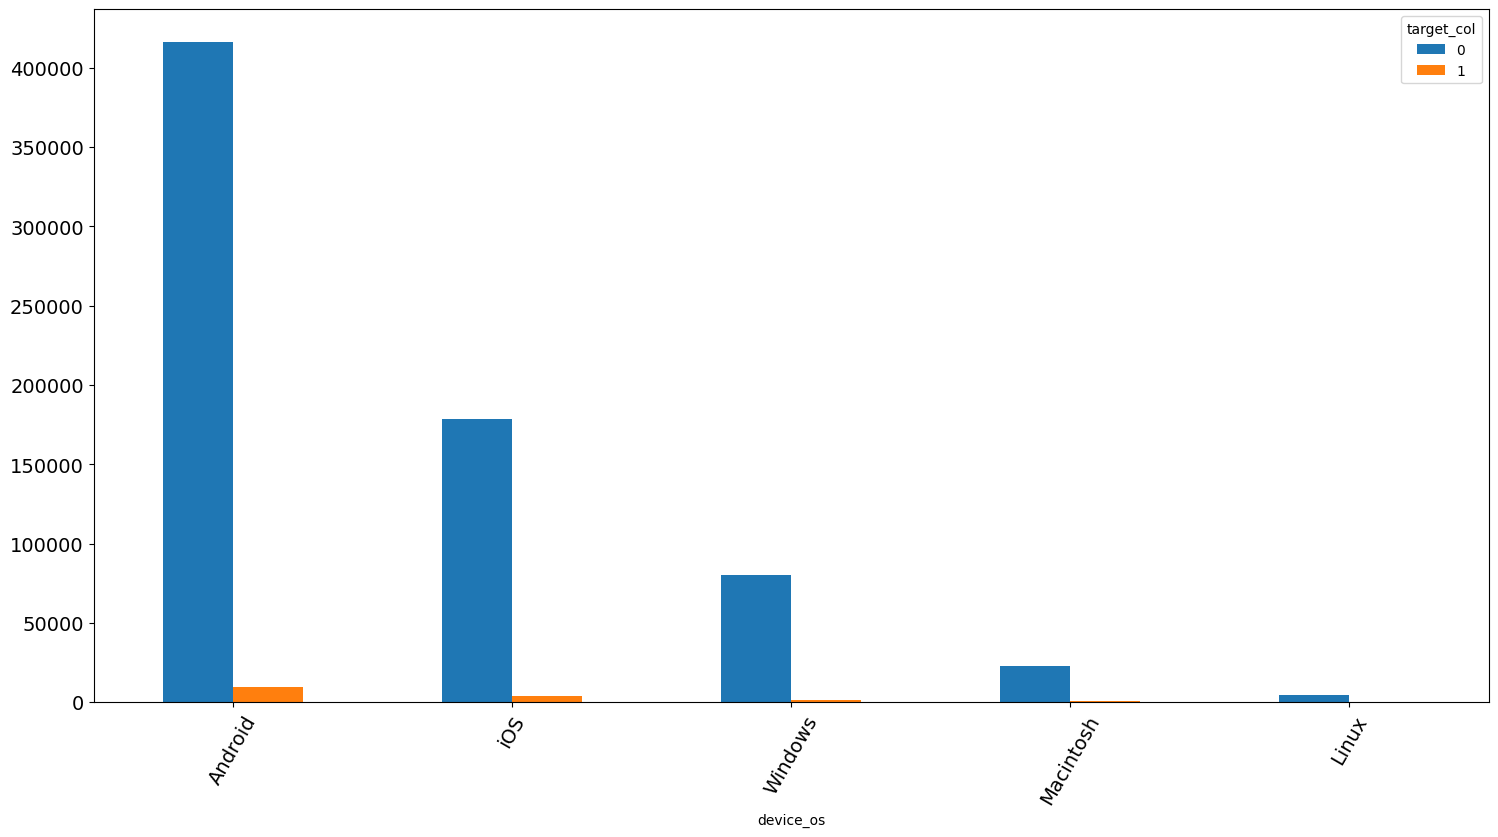

In [375]:
df_filtered = df_full_copy[df_full_copy['device_os'] != 'other']
fig, ax = plt.subplots(figsize=(18, 9))
df_filtered.groupby(['device_os', 'target_col']).size().unstack().sort_values(by=1, ascending=False).plot(kind='bar', ax=ax)
plt.xticks(rotation=60, size=14)
plt.yticks(size=14)
plt.show()

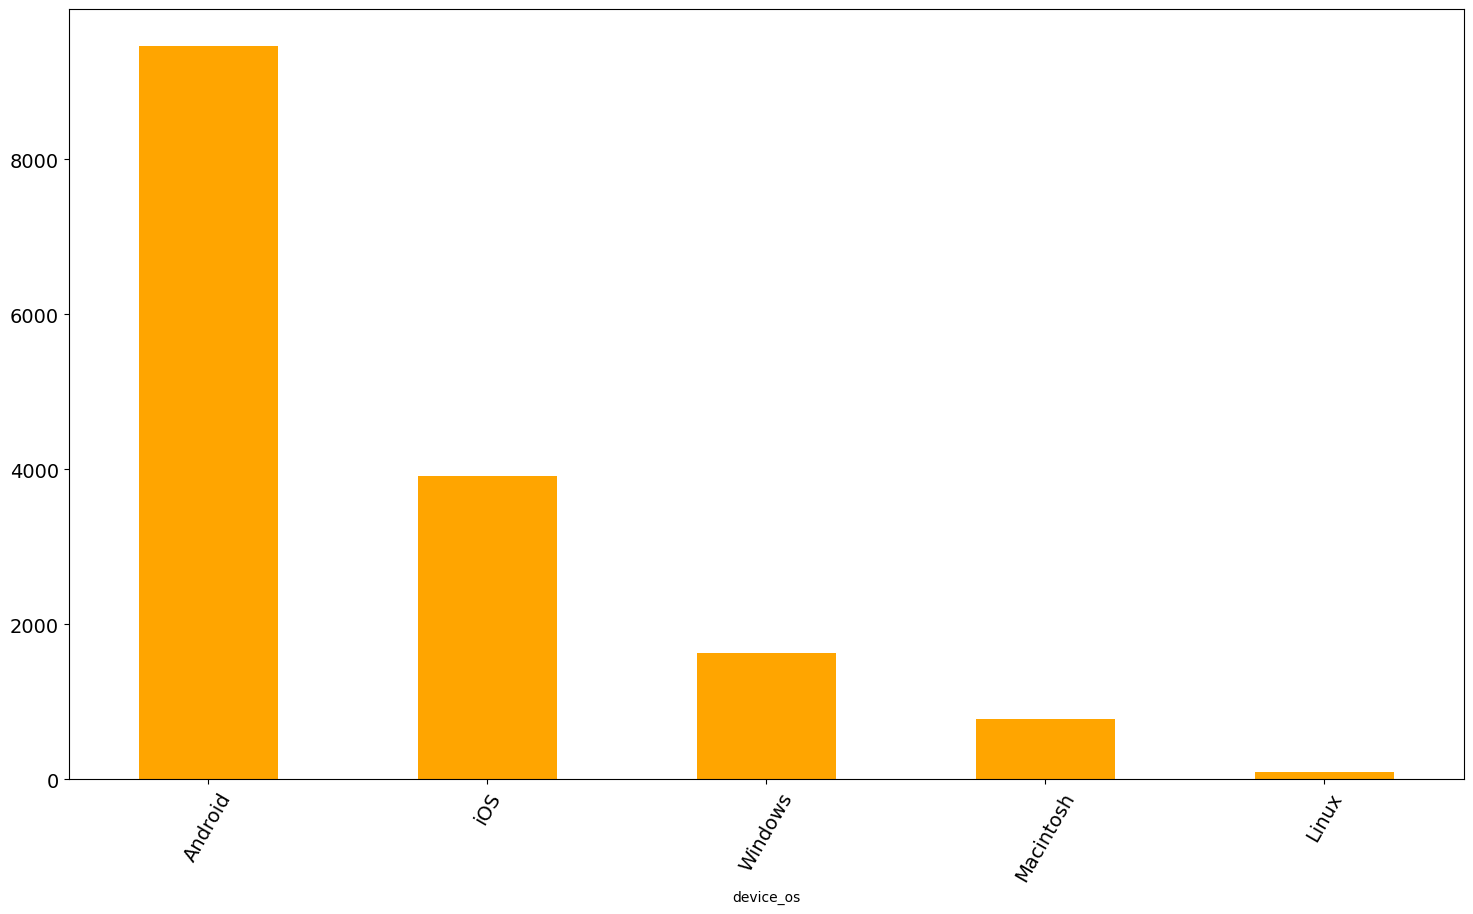

In [384]:
##Объем трафика (целевые действия)
fig, ax = plt.subplots(figsize=(18, 10))
grouped = df_filtered.groupby('device_os')['target_col'].sum()
grouped = grouped.sort_values(ascending=False)
grouped.plot(kind='bar', color = 'orange')
plt.xticks(rotation=60, size=14)
plt.yticks(size=14)
plt.show()

In [379]:
## Трафик
grouped.sort_values(ascending=False)

device_os
Android      9463
iOS          3919
Windows      1633
Macintosh     772
Linux          90
Name: target_col, dtype: int64

С точки зрения трафика лидирует android

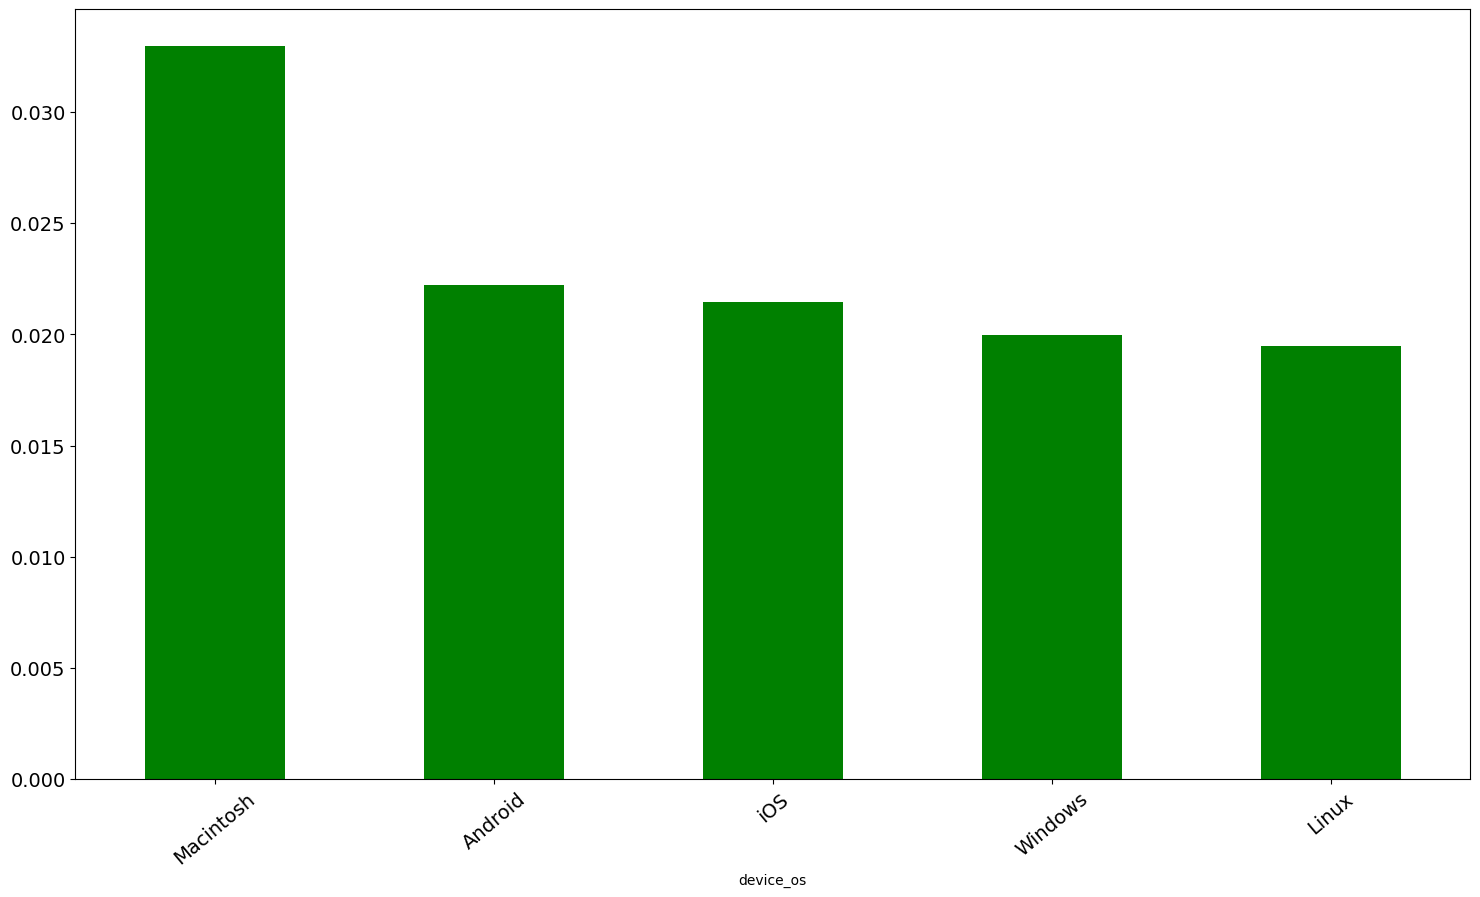

In [386]:
## Конверсия в целевое действие CR
fig, ax = plt.subplots(figsize=(18, 10))
grouped = df_filtered.groupby('device_os')['target_col'].mean()
grouped = grouped.sort_values(ascending=False)
grouped.plot(kind='bar', color = 'green')
plt.xticks(rotation=40, size=14)
plt.yticks(size=14)
plt.show()

In [387]:
## CR
grouped.sort_values(ascending=False)

device_os
Macintosh    0.032970
Android      0.022239
iOS          0.021463
Windows      0.019978
Linux        0.019497
Name: target_col, dtype: float64

С точки срения CR максимальный показатель у Macintosh - 3%

#### device_category - категория устройства

In [388]:
df_full_copy = df_full.copy()

In [391]:
counts = df_full_copy.device_category.value_counts()

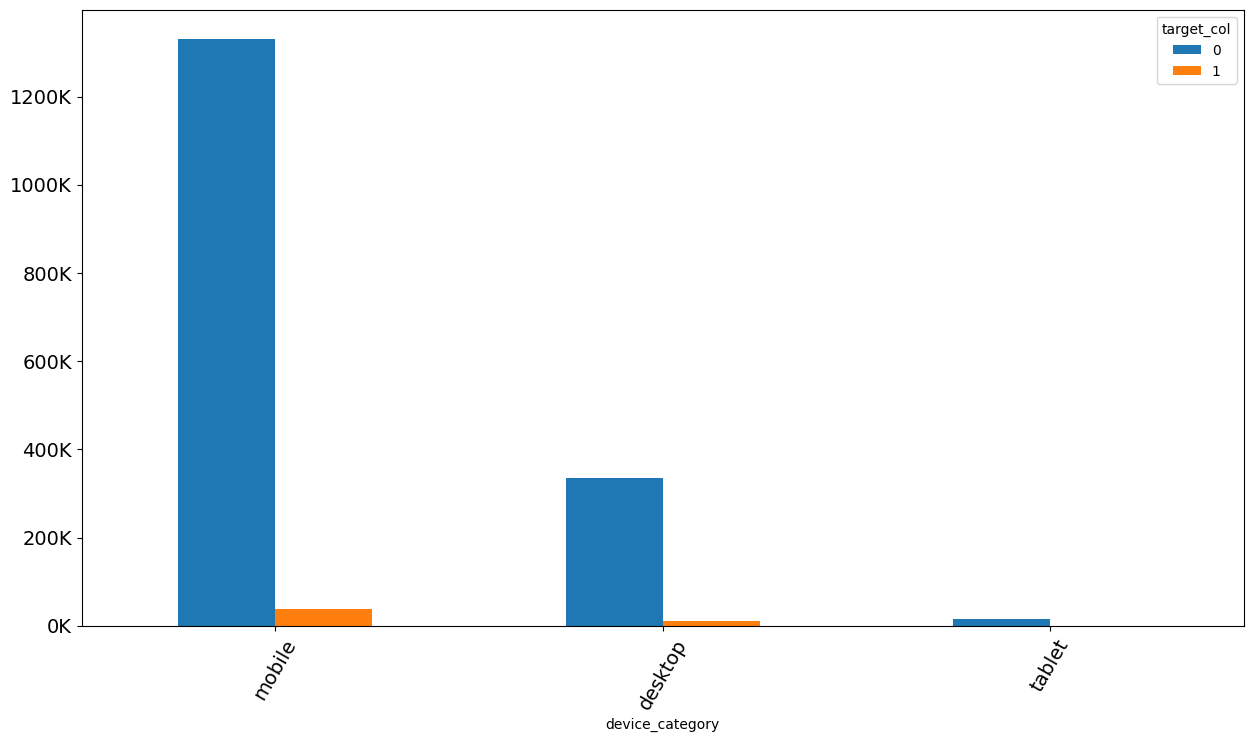

In [393]:
fig, ax = plt.subplots(figsize=(15, 8))
df_full_copy.groupby(['device_category', 'target_col']).size().unstack().sort_values(by=1, ascending=False).plot(kind='bar', ax=ax)
plt.xticks(rotation=60, size=14)
plt.yticks(size=14)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1000:.0f}K'))
plt.show()

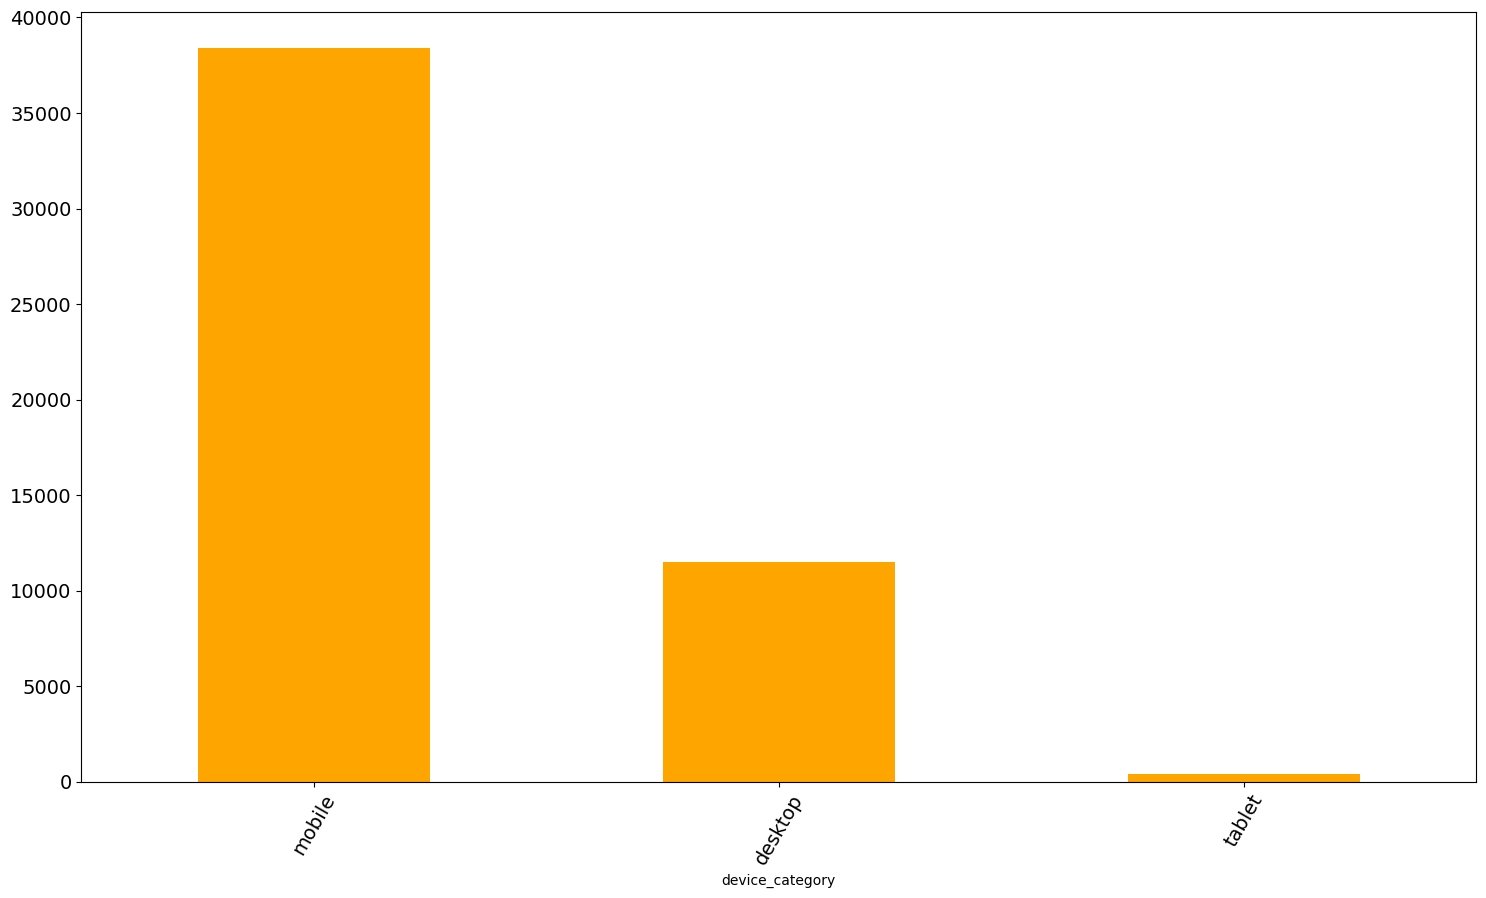

In [394]:
##Объем трафика (целевые действия)
fig, ax = plt.subplots(figsize=(18, 10))
grouped = df_full_copy.groupby('device_category')['target_col'].sum()
grouped = grouped.sort_values(ascending=False)
grouped.plot(kind='bar', color = 'orange')
plt.xticks(rotation=60, size=14)
plt.yticks(size=14)
plt.show()

In [395]:
grouped.sort_values(ascending=False)

device_category
mobile     38379
desktop    11513
tablet       422
Name: target_col, dtype: int64

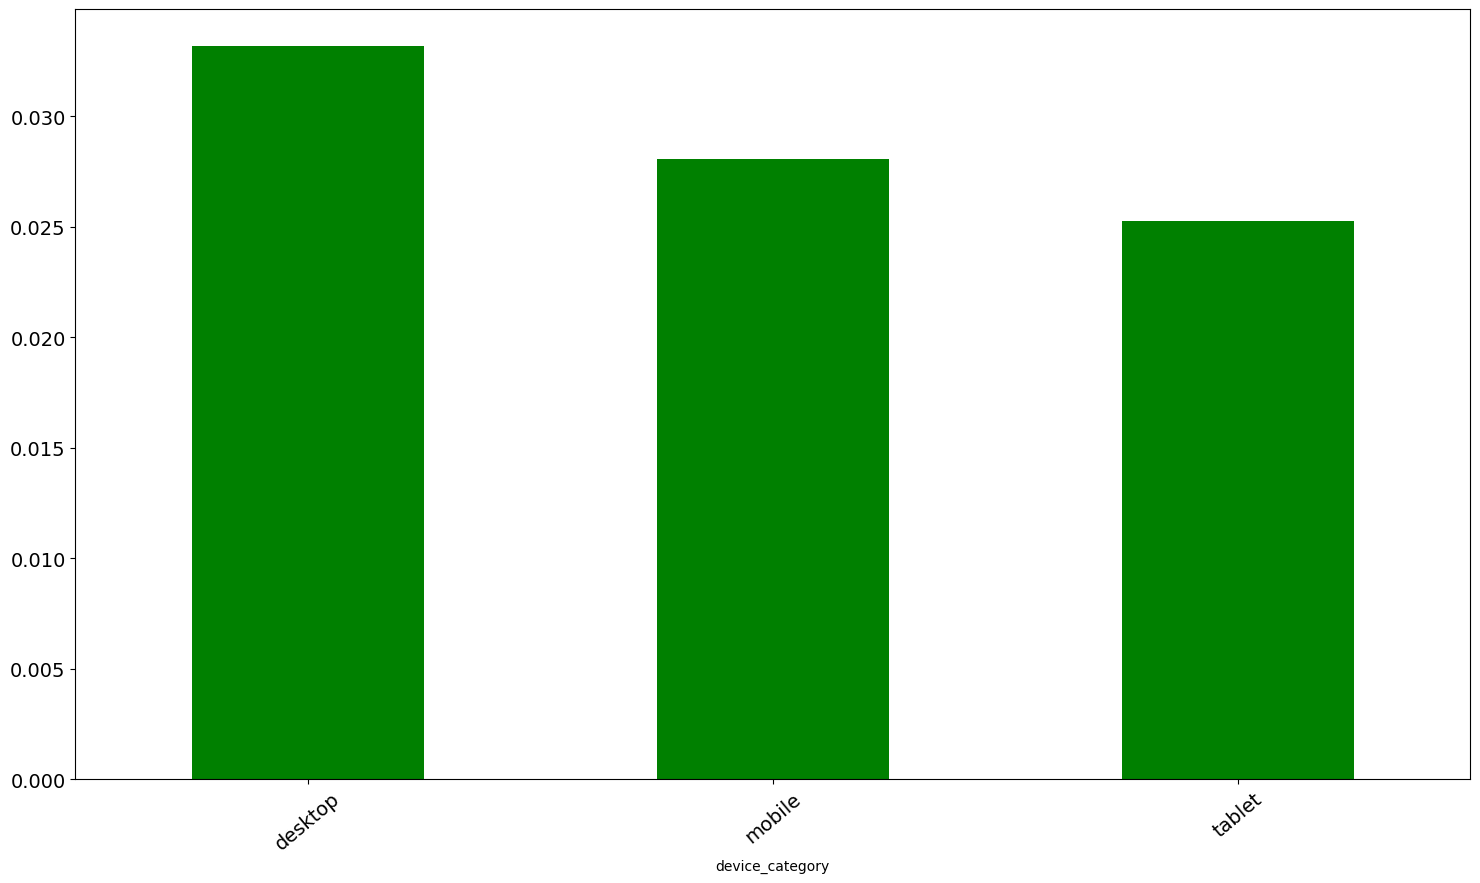

In [396]:
## Конверсия в целевое действие CR
fig, ax = plt.subplots(figsize=(18, 10))
grouped = df_full_copy.groupby('device_category')['target_col'].mean()
grouped = grouped.sort_values(ascending=False)
grouped.plot(kind='bar', color = 'green')
plt.xticks(rotation=40, size=14)
plt.yticks(size=14)
plt.show()

In [397]:
grouped.sort_values(ascending=False)

device_category
desktop    0.033189
mobile     0.028041
tablet     0.025276
Name: target_col, dtype: float64

Трафик с мобильных устройств намного больше, чем с десктопных, одкако CR у мобильных ниже. 

### Какие авто пользуются наибольшим спросом? У каких авто самый лучший показатель CR (Conversion Rate) в целевые события?

In [400]:
## Производители автомобилей были проанализированы в прошлом пункте (car_name - марка автомобиля). 
## Тут будем анализировать конкретные модели

In [414]:
df_full_copy = df_full.copy()

In [415]:
def concat_columns(row):
    if row['car_model'] != 'other':
        return row['car_name'] + ' ' + row['car_model']
    else:
        return 'other other'

df_full_copy['car'] = df_full_copy.apply(concat_columns, axis=1)

In [416]:
df_full_copy.head(10)

session_id     client_id  visit_number  \
0  9055434745589932991.1637753792.1637753792  2.108383e+09             1   
1   905544597018549464.1636867290.1636867290  2.108385e+08             1   
2  9055446045651783499.1640648526.1640648526  2.108385e+09             1   
3  9055447046360770272.1622255328.1622255328  2.108386e+09             1   
4  9055447046360770272.1622255345.1622255345  2.108386e+09             2   
5  9055447192389856083.1622453074.1622453074  2.108386e+09             1   
6  9055455318486370642.1640843788.1640843788  2.108387e+09             1   
7  9055461992850812764.1626107740.1626107740  2.108389e+09             1   
8  9055462349345527315.1638536723.1638536723  2.108389e+09             1   
9  9055466554104774132.1624800757.1624800757  2.108390e+09             1   

  utm_medium device_category device_os device_brand device_screen_resolution  \
0     banner          mobile   Android       Huawei                  360x720   
1        cpm          mobile   Android      Samsung                  385x854   
2     banner          mobile   Android       Huawei                  360x720   
3        cpc          mobile     other       Xiaomi                  393x786   
4        cpc          mobile     other       Xiaomi                  393x786   
5    organic          mobile     other        Apple                  375x812   
6        cpc          tablet   Android       Lenovo                 602x1029   
7     banner          mobile     other      Samsung                  360x640   
8     banner          mobile       iOS        Apple                  390x844   
9     banner          mobile     other      Samsung                  412x915   

     device_browser geo_country  ...            event_action  \
0            Chrome      Russia  ...             sub_landing   
1  Samsung Internet      Russia  ...             sub_landing   
2            Chrome      Russia  ...      search_form_region   
3            Chrome      Russia  ...             sub_landing   
4            Chrome      Russia  ...               quiz_show   
5            Safari      Russia  ...             sub_landing   
6         YaBrowser      Russia  ...           view_new_card   
7            Chrome      Russia  ...  search_form_search_btn   
8            Safari      Russia  ...             sub_landing   
9            Chrome      Russia  ...             sub_landing   

            event_label car_model  car_name  target_col traffic month  \
0                 other     other     other           0       0    11   
1                 other     other     other           0       0    11   
2  KWTCzSIXzoqUWjfUQMgP     other     other           0       0    12   
3  KclpemfoHstknWHFiLit     other     other           0       0     5   
4  KclpemfoHstknWHFiLit     other     other           0       0     5   
5  KclpemfoHstknWHFiLit     other     other           0       1     5   
6                 other     rapid     skoda           0       0    12   
7  ghOrjqpgskpGHSFfBBsi     other     other           0       0     7   
8                 other     other     other           0       0    12   
9  KclpemfoHstknWHFiLit     other     other           0       0     6   

  day_of_week hour          car  
0           2   14  other other  
1           6    8  other other  
2           1    2  other other  
3           5    5  other other  
4           5    5  other other  
5           0   12  other other  
6           3    8  skoda rapid  
7           0   19  other other  
8           4   16  other other  
9           6   16  other other  

[10 rows x 27 columns]

In [418]:
counts = df_full_copy.car.value_counts()
df_full_copy['car'] = df_full_copy['car'].apply(lambda x: 'other other' if counts[x] < 100 else x)

In [419]:
df_full_copy.car.value_counts()

car
other other                 1512933
skoda rapid                   31664
lada-vaz vesta                27139
volkswagen polo               19603
mercedes-benz e-klasse        14275
skoda karoq                   11710
nissan qashqai                11030
renault duster                 6987
nissan x-trail                 5963
kia rio                        5122
renault logan                  5101
mercedes-benz glb              4148
skoda octavia                  4042
toyota camry                   3907
kia seltos                     3855
kia sorento                    3837
lexus rx                       3646
volvo s90                      3212
porsche cayenne                3164
mercedes-benz gla-klasse       3017
haval jolion                   2867
volkswagen tiguan              2859
bmw 5-serii                    2233
mercedes-benz g-klasse         2175
mini hatch                     2166
mercedes-benz gle              2122
mercedes-benz glc              1858
bmw 2-serii             

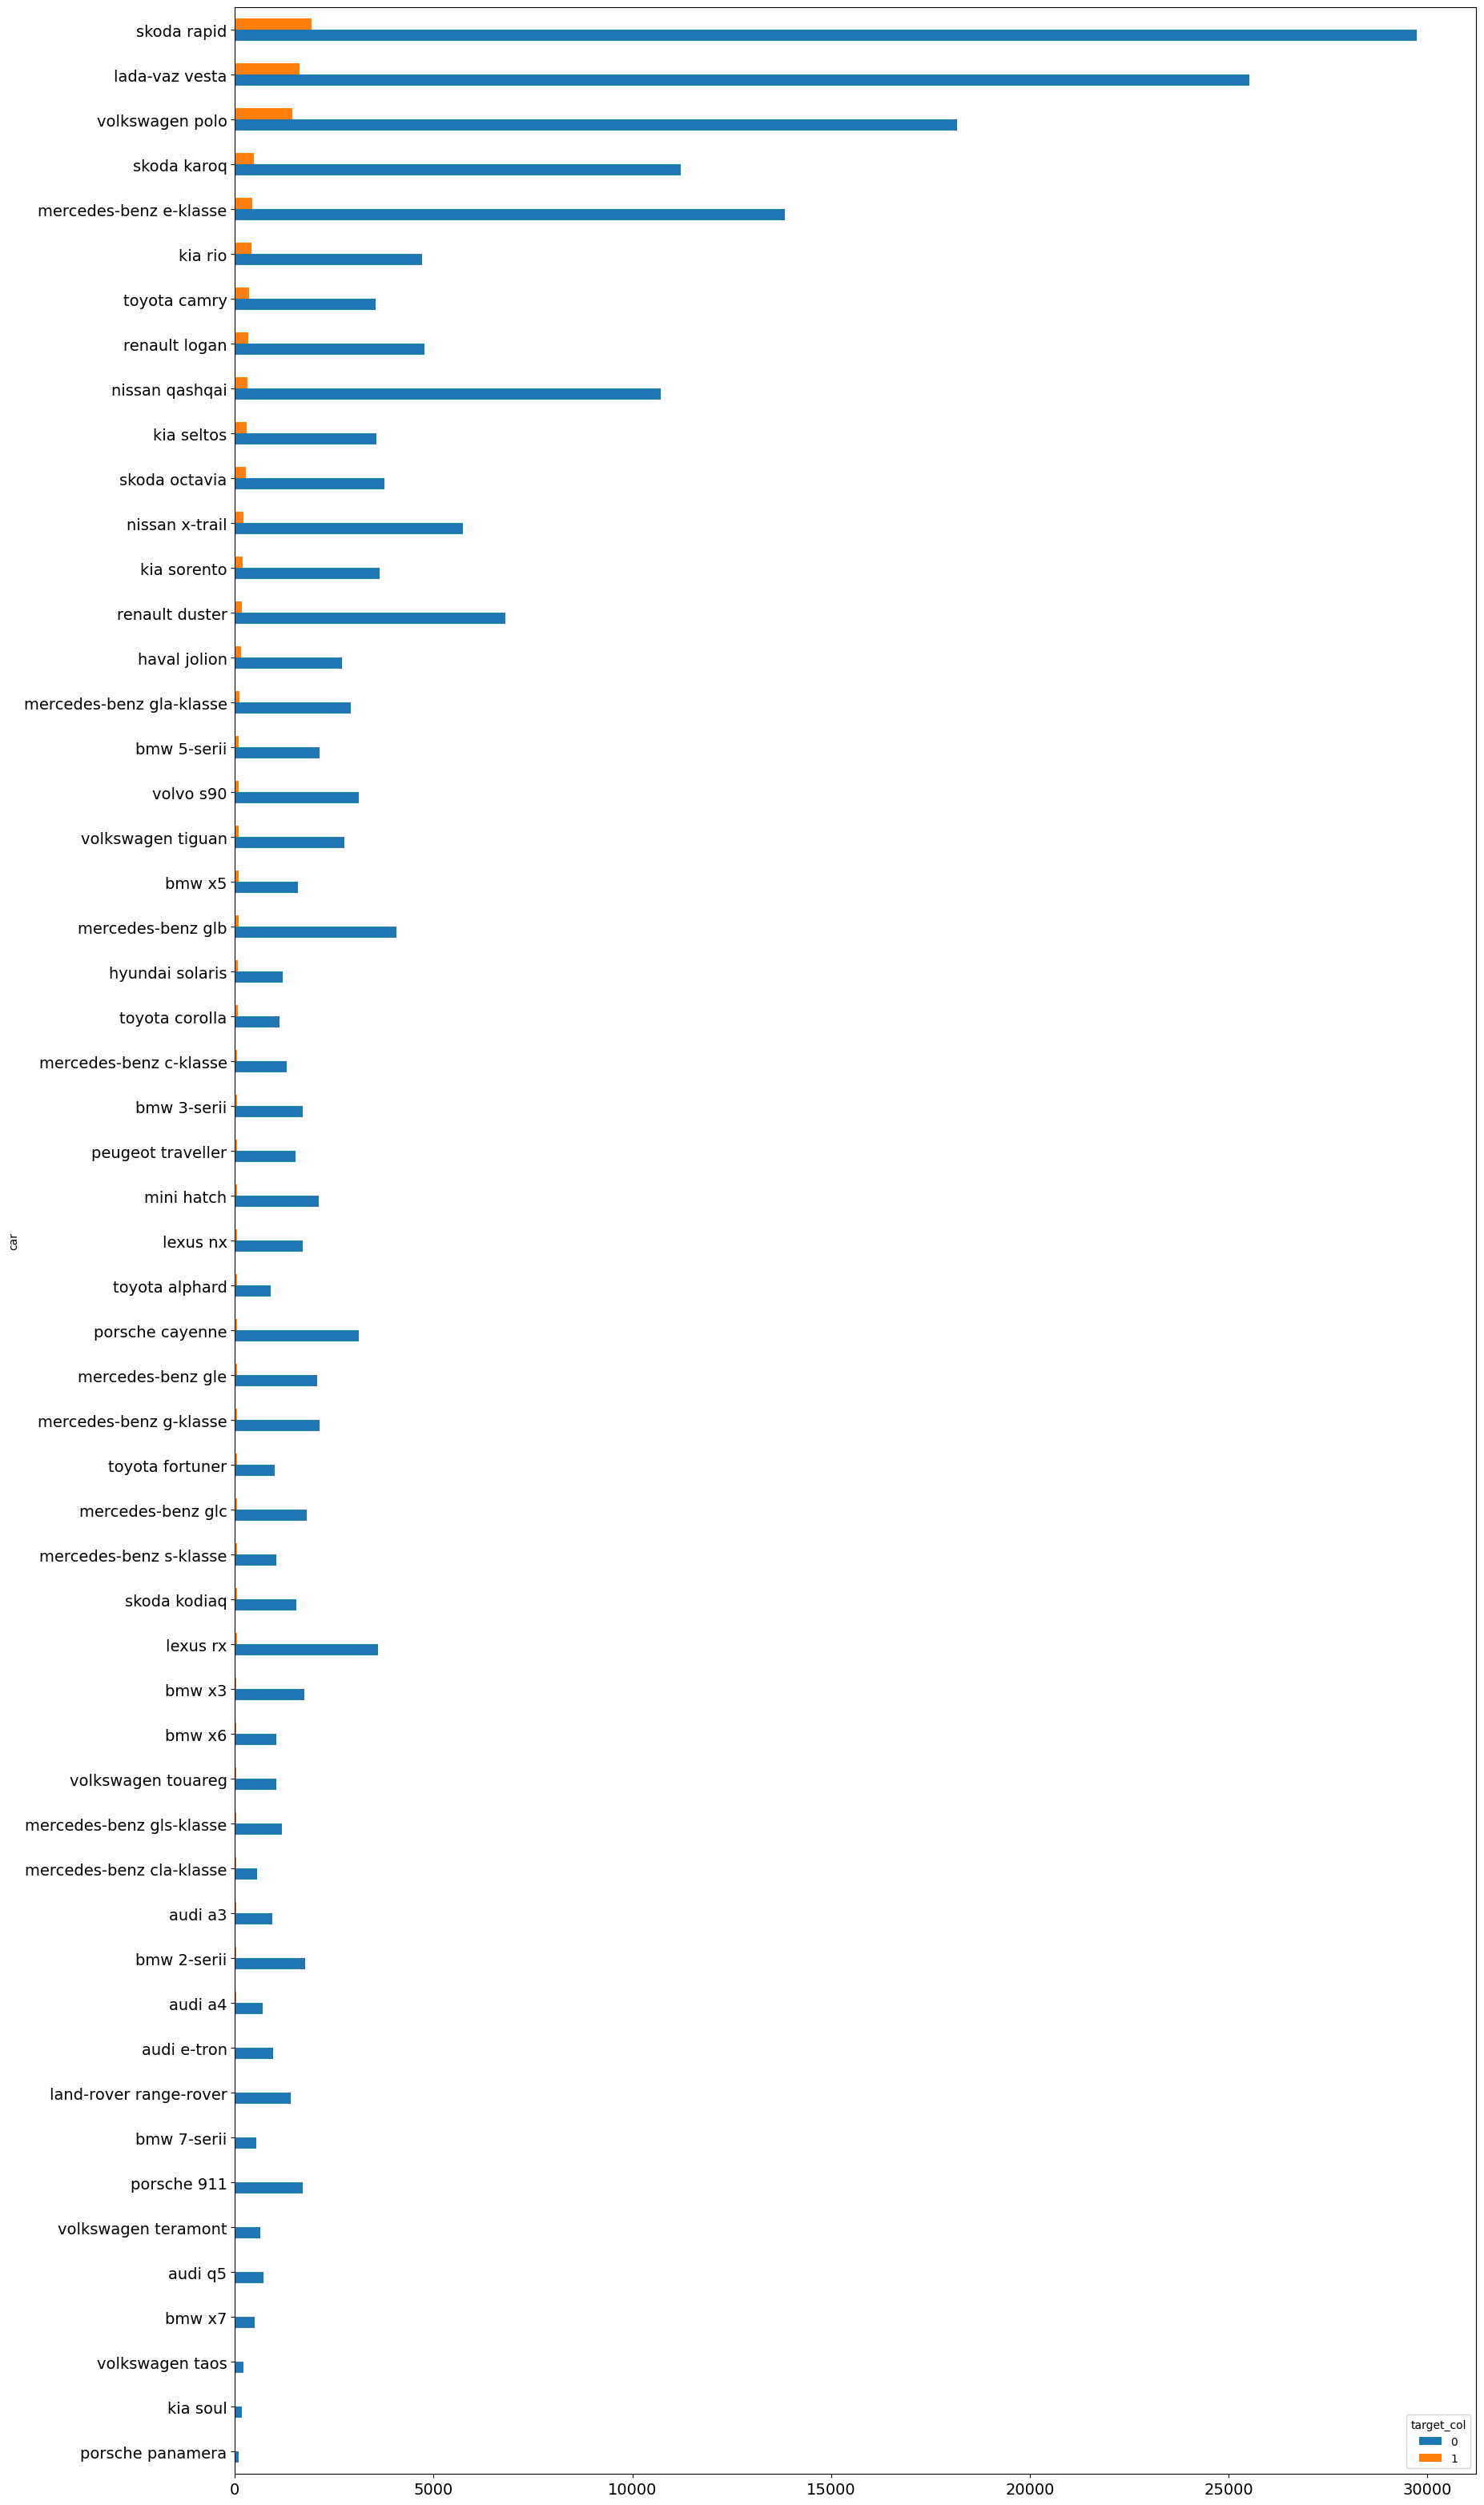

In [422]:
df_filtered = df_full_copy[df_full_copy['car'] != 'other other']
fig, ax = plt.subplots(figsize=(20, 40))
df_filtered.groupby(['car', 'target_col']).size().unstack().sort_values(by=1).plot(kind='barh', ax=ax)
plt.yticks(size=14)
plt.xticks(size=14)
plt.show()

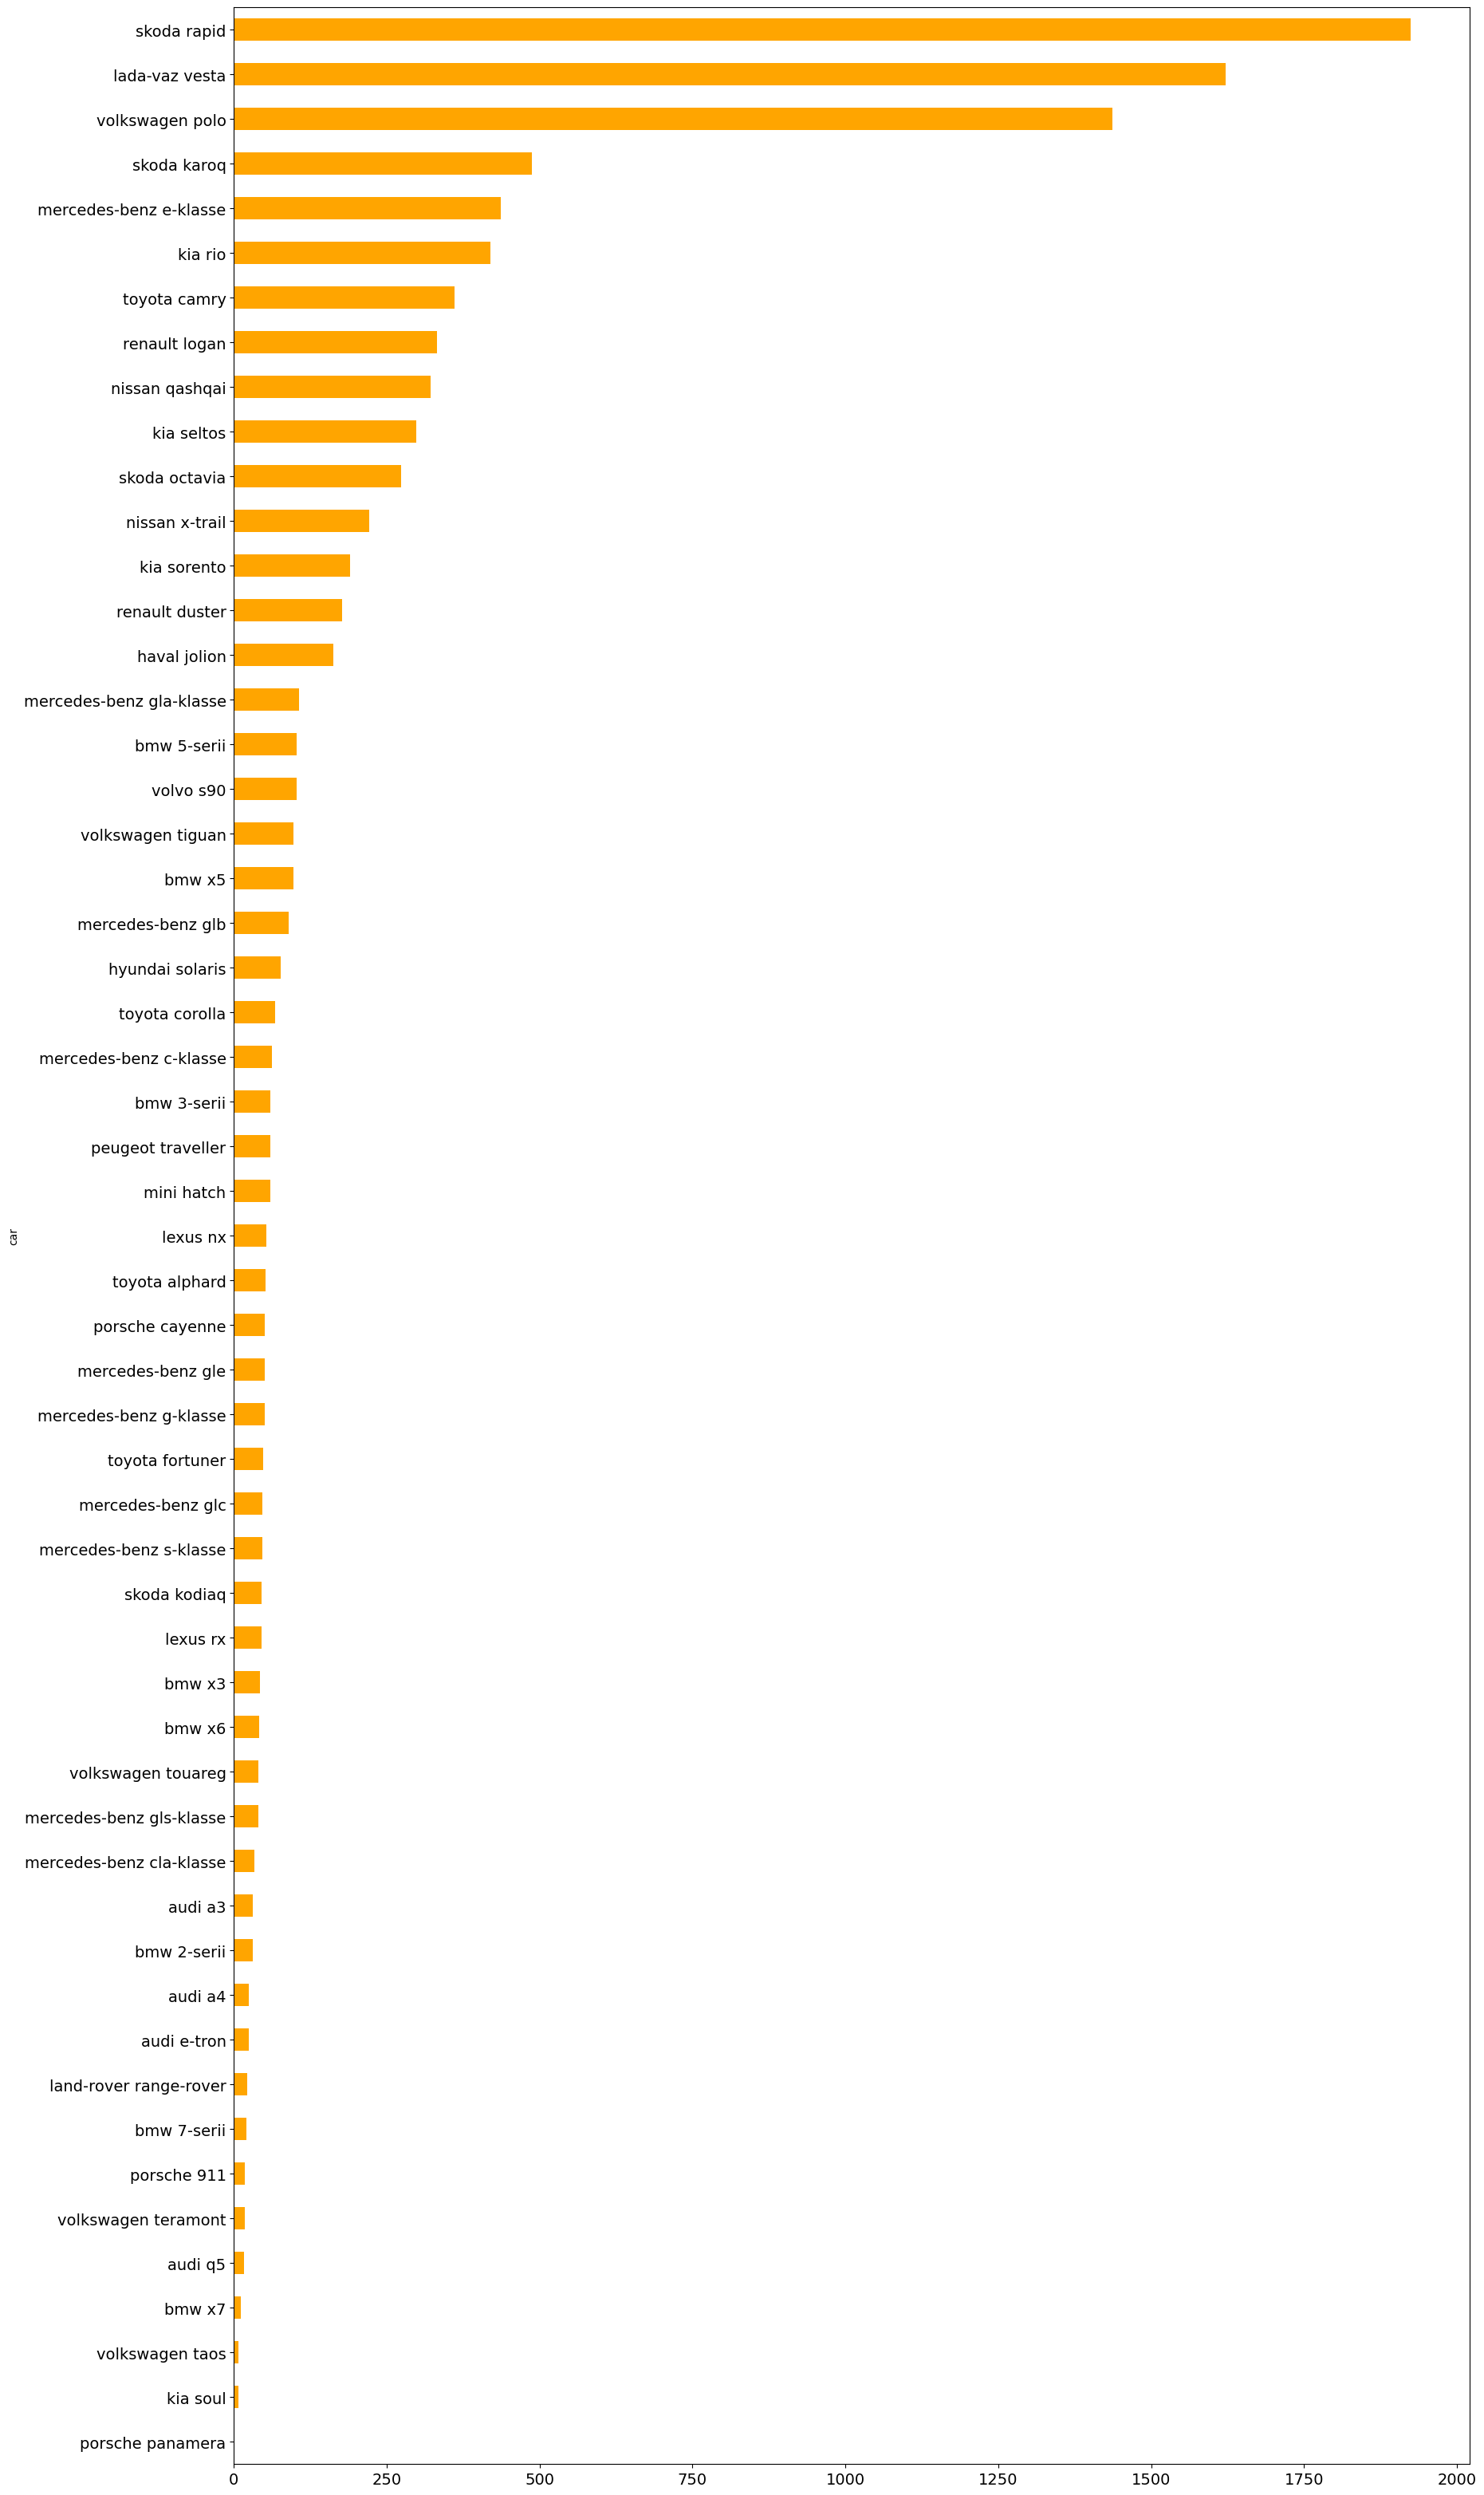

In [423]:
##Объем трафика (целевые действия)
fig, ax = plt.subplots(figsize=(20, 40))
grouped = df_filtered.groupby('car')['target_col'].sum()
grouped = grouped.sort_values(ascending=True)
grouped.plot(kind='barh', color = 'orange')
plt.yticks(size=14)
plt.xticks(size=14)
plt.show()

In [424]:
##Наибролее популярные автомобили с точки зрения трафика
grouped.sort_values(ascending=False)

car
skoda rapid                 1925
lada-vaz vesta              1622
volkswagen polo             1437
skoda karoq                  487
mercedes-benz e-klasse       436
kia rio                      420
toyota camry                 361
renault logan                332
nissan qashqai               322
kia seltos                   298
skoda octavia                273
nissan x-trail               221
kia sorento                  190
renault duster               177
haval jolion                 163
mercedes-benz gla-klasse     107
bmw 5-serii                  103
volvo s90                    103
volkswagen tiguan             98
bmw x5                        97
mercedes-benz glb             90
hyundai solaris               76
toyota corolla                67
mercedes-benz c-klasse        62
bmw 3-serii                   60
mini hatch                    59
peugeot traveller             59
lexus nx                      53
toyota alphard                52
porsche cayenne               51
merced

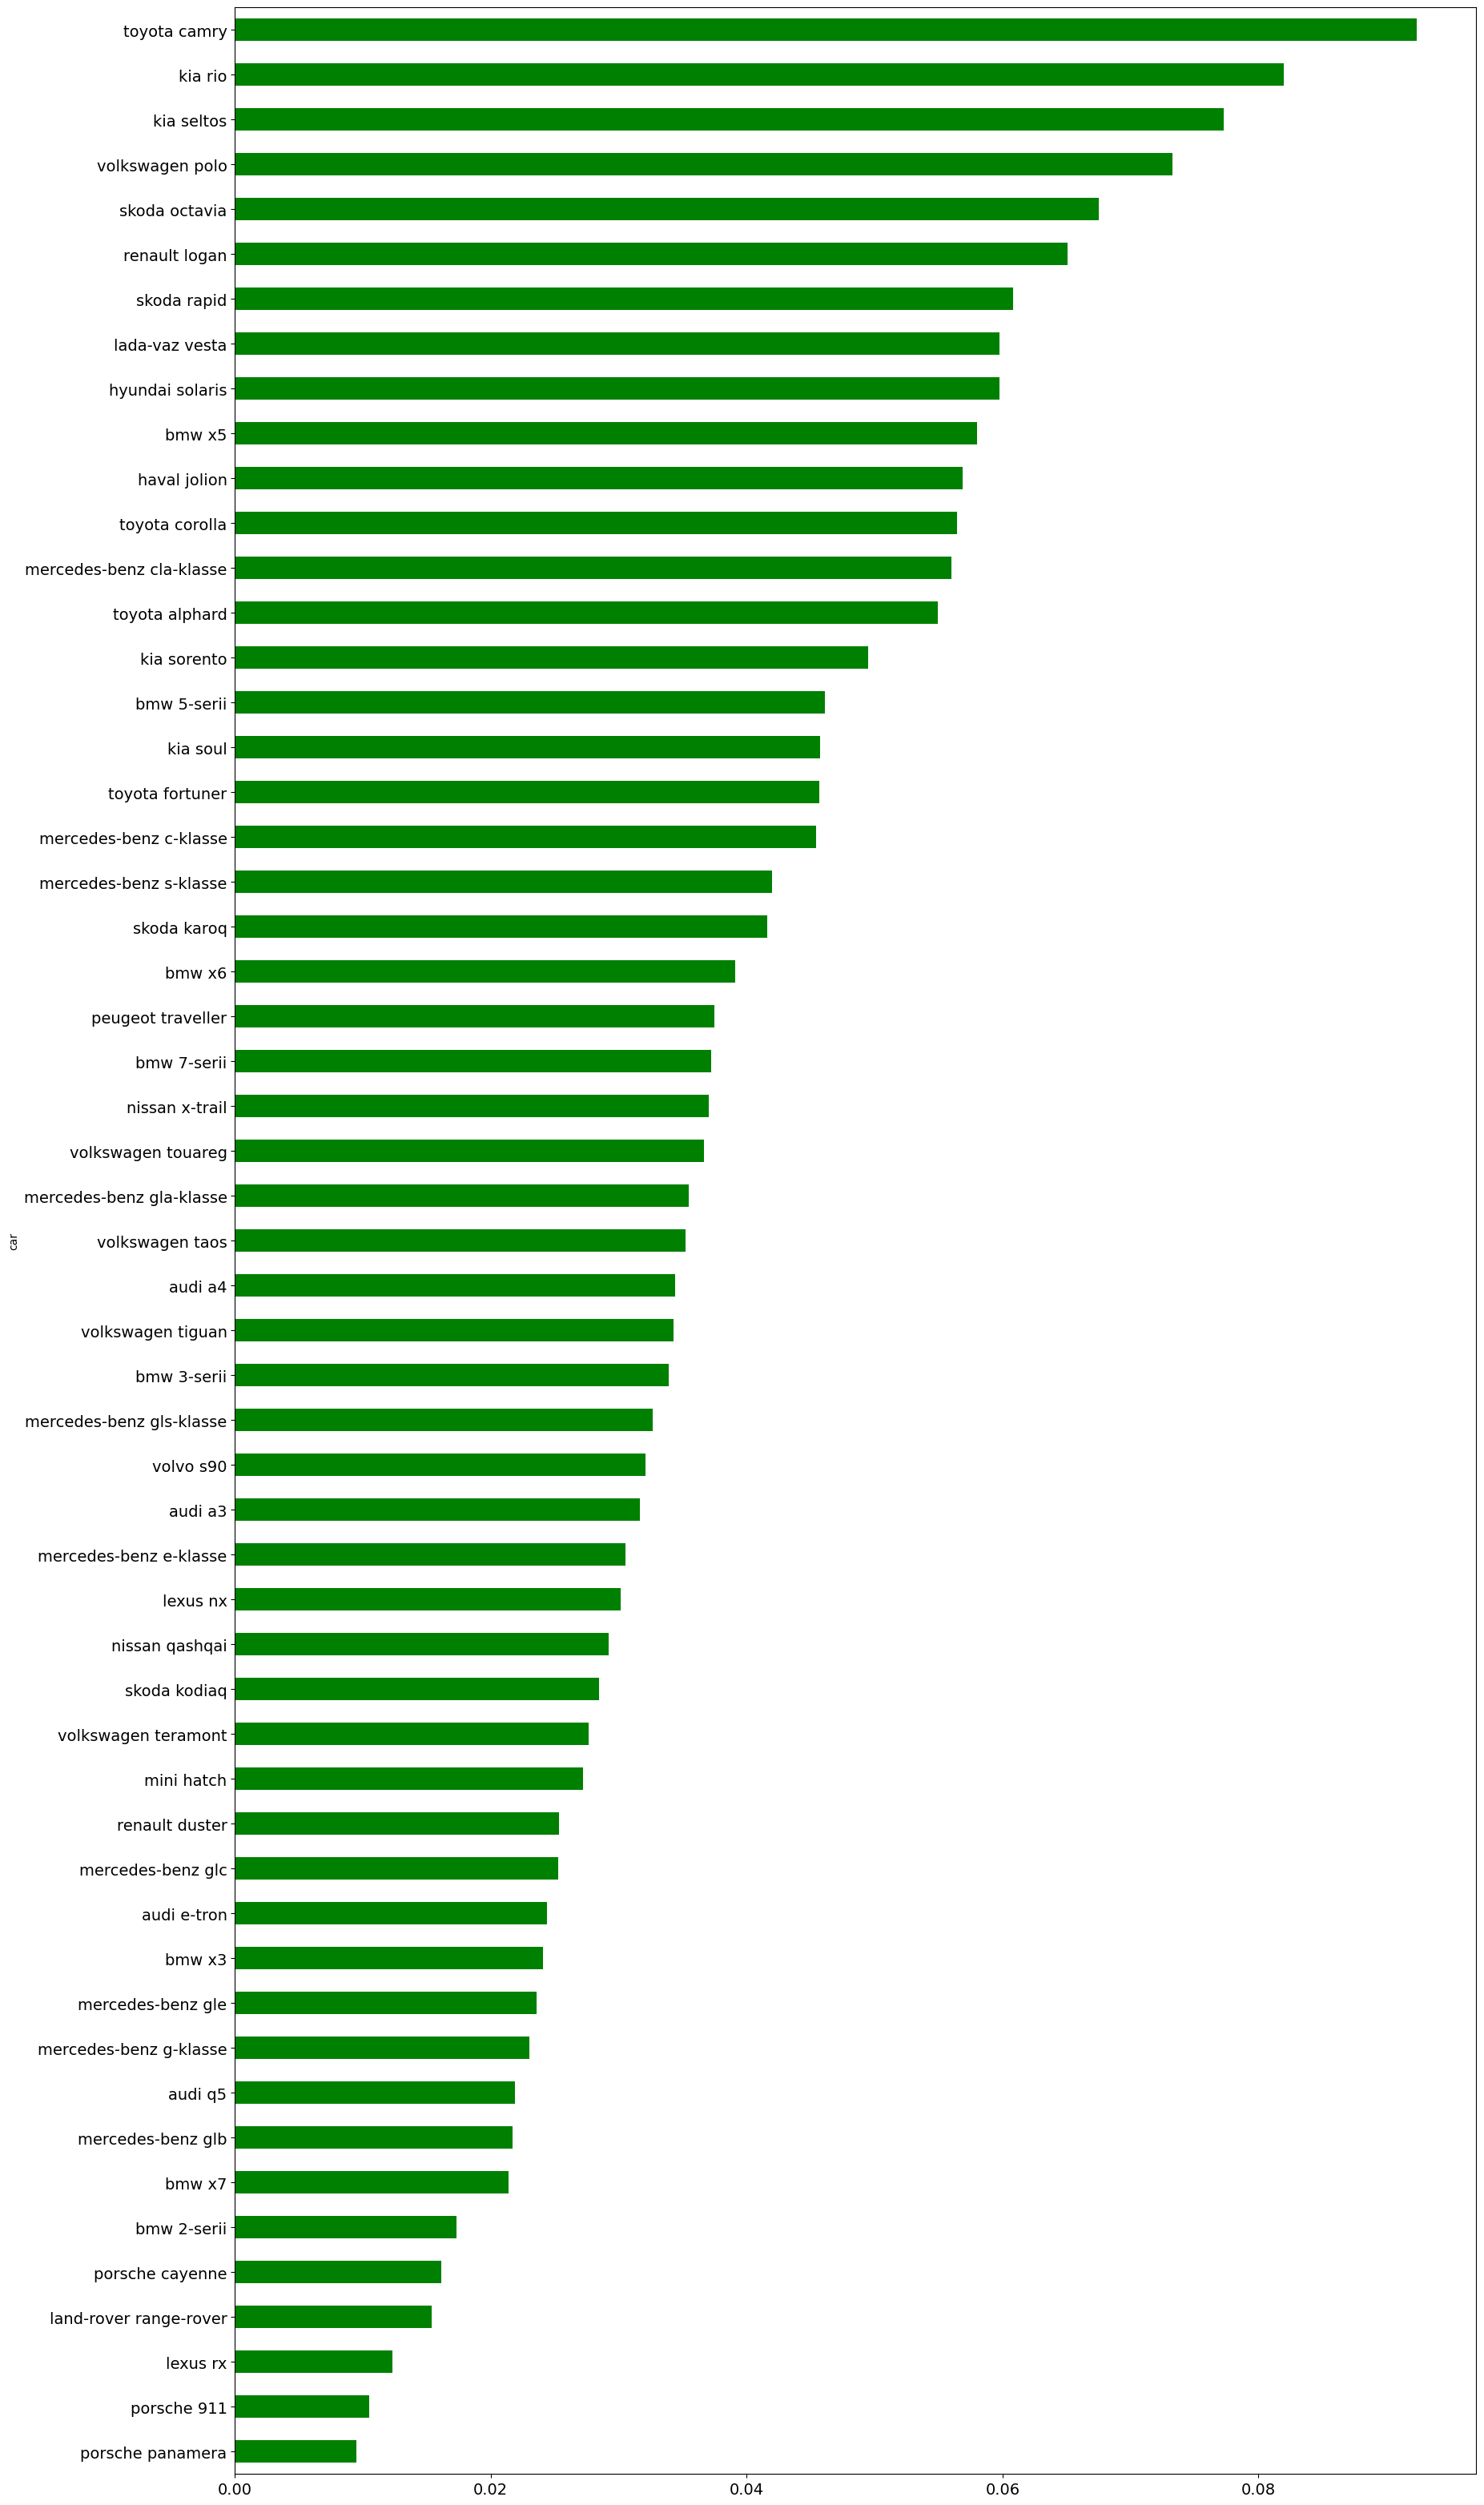

In [425]:
## Конверсия в целевое действие CR
fig, ax = plt.subplots(figsize=(20, 40))
grouped = df_filtered.groupby('car')['target_col'].mean()
grouped = grouped.sort_values(ascending=True)
grouped.plot(kind='barh', color = 'green')
plt.yticks(size=14)
plt.xticks(size=14)
plt.show()

In [426]:
##Наиболее попоулярыные модели с точки зрения CR
grouped.sort_values(ascending=False)

car
toyota camry                0.092398
kia rio                     0.081999
kia seltos                  0.077302
volkswagen polo             0.073305
skoda octavia               0.067541
renault logan               0.065085
skoda rapid                 0.060795
lada-vaz vesta              0.059766
hyundai solaris             0.059748
bmw x5                      0.057980
haval jolion                0.056854
toyota corolla              0.056445
mercedes-benz cla-klasse    0.056027
toyota alphard              0.054968
kia sorento                 0.049518
bmw 5-serii                 0.046126
kia soul                    0.045714
toyota fortuner             0.045671
mercedes-benz c-klasse      0.045455
mercedes-benz s-klasse      0.041971
skoda karoq                 0.041588
bmw x6                      0.039106
peugeot traveller           0.037460
bmw 7-serii                 0.037234
nissan x-trail              0.037062
volkswagen touareg          0.036664
mercedes-benz gla-klasse    0.0354

### Стоит ли нам увеличивать своё присутствие в соцсетях и давать там больше рекламы?

Для оценки эффективности рекламы в социальных сетях можно использовать следующие показатели:

CTR (click-through rate) - отношение числа кликов на рекламу к числу ее показов, CPC (cost per click) - стоимость одного клика на рекламу, CPM (cost per mille) - стоимость тысячи показов рекламы, ROI (return on investment) - соотношение прибыли и затрат на рекламу и CR (conversion rate)

Данных о затратах, прибыли и общем числе показов рекламы в соцсетях у нас нет, поэтому используем только CR

In [435]:
result = df_full_copy.groupby(['social_media', 'target_col']).size().unstack(fill_value=0)
result['CR %'] = result[1] / (result[0] + result[1])*100
print(result)

target_col          0      1      CR %
social_media                          
0             1429693  46293  3.136412
1              252259   4021  1.568987


Конверсия в целевое действие у рекламы в социальных сетях составляет 1.5%, в то время как конверсия в целевое действие из других каналов привлечения составляет 3%. 
Исходя из этого можно сделать предварительный вывод, что реклама в социальных сетях в данный момент неэффективна и увеличивать присутсвие в социальных сетях нецелесообразно. Для более поллной оценки нужны данные затратах, прибыли и общем числе показов рекламы, а также перечень каналов привлечения для более детального сравнения. 